In [1]:
from pyexpat import features

#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, ConvLSTM1D, Flatten, Dense, Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow.keras.regularizers import l2

import shap
from tqdm import tqdm
# Surpressing Warnings
import warnings
import tensorflow as tf

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
# Suppress Keras UserWarning about input shape in RNN layers
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Suppress statsmodels ValueWarning about no frequency information
warnings.filterwarnings("ignore", category=ValueWarning, module='statsmodels')

# Suppress statsmodels ConvergenceWarning about optimization failure
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

# Suppress statsmodels FutureWarning about optimization failure
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

# To suppress all TensorFlow warnings
# warnings.filterwarnings('ignore', category=tf.errors.UserWarning)
warnings.filterwarnings('ignore', message="6 out of the last .* calls to .* triggered tf.function retracing.*", category=UserWarning)



# Loading Transformed Data

In [6]:

file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
all_Series_CPI_target_dir = "AllSamplesCPItarget/"
target = "CPI_t+1"

df = pd.read_csv(filepath_or_buffer = t_Data_Dir + 'full_cpi_target_data_norm.csv', index_col = 0)
df.index.name = 'DATE' # Set the name of the index


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


# Column Definitions

In [7]:
# main variables columns
main_vars_cols = pd.read_csv('combined2' + '.csv', header=1, skiprows=[0], index_col = 0).columns.tolist()
# CPI VAE columns
vae_cpi_cols = ['z1', 'z2', 'z3', 'z4', 'z5', 'CPI_t+1']

# Utility Functions

In [8]:

sns.set_theme(style="whitegrid") # Apply seaborn visual theme

def plot_forecast(forecasted_series, actual_series, title_name='Forecasted vs Actual CPIAUCSL'):

    fig = plt.figure(figsize=(12, 6)) # Store figure object

    actual_series.index = pd.to_datetime(actual_series.index) # Try converting to DateTimeIndex

    plt.plot(actual_series.index, forecasted_series, label='Forecasted', color='#e41a1c', linestyle='dashed', linewidth=2) # Red for forecast
    plt.plot(actual_series.index, actual_series, label='Actual', color='#377eb8', linestyle='solid', linewidth=2) # Blue for actual

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.title(title_name, fontsize=12)

    # Date formatting for x-axis (using logic from your improved plot_series)
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate x-axis labels, adjust font size
    plt.gcf().autofmt_xdate() # Auto-format dates

    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout() # Adjust layout

    return fig # Return the figure object (do NOT use plt.show() here if you want to control display later)

def plot_observed_vs_fitted_var(var_model_fit, train_df, target_column='CPIAUCSL', title='VAR Model - Observed vs Fitted (Training)'):

    fitted_values = var_model_fit.fittedvalues # Get fitted values from the VAR model
    observed_train = train_df[target_column]   # Observed values from the training data

    # Extract fitted values for the target column
    fitted_cpiauscl = fitted_values[target_column]

    # Ensure index is DateTimeIndex if possible (align with actual_series index if needed)
    try:
        fitted_cpiauscl.index = pd.to_datetime(fitted_cpiauscl.index)
        observed_train.index = pd.to_datetime(observed_train.index) # Align observed index too for plotting
        if not fitted_cpiauscl.index.equals(observed_train.index): # If indexes still not the same, try to align based on actual index
            fitted_cpiauscl.index = observed_train.index # Force index alignment for plotting if possible
    except ValueError:
        print("Warning: Could not convert index to DateTime for Observed vs Fitted plot.")
        pass # Plot without DateTimeIndex if conversion fails

    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_cpiauscl.index, fitted_cpiauscl, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator() # Use observed_train index for locator
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predictions(y_actual, y_pred, train_index, title='CNN-LSTM: Actual vs Forecasted Values'):
    """Plots actual vs forecasted values."""
    train_index = pd.to_datetime(train_index)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_index, y_actual, label='Actual', color='blue', linestyle='solid')
    plt.plot(train_index, y_pred, label='Forecasted', color='red', linestyle='dashed')

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title, fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_loss(history):
    # Plots loss function
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM - Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

def plot_observed_vs_fitted(y_train, predictions_train, train_index):
    fig = plt.figure(figsize=(12, 6))
    train_index = pd.to_datetime(train_index)
    plt.plot(train_index, y_train, label="Observed (Train)", linestyle="solid")
    plt.plot(train_index, predictions_train, label="Fitted (Train)", linestyle="solid")
    plt.title("CNN-LSTM - Observed vs. Fitted Values")

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_arima_observed_vs_fitted(arima_model_fit, train_data, target_column, title='ARIMA Model - Observed vs Fitted (Training)'):
    """
    Plots observed vs fitted values for an ARIMA model on the training data,
    handling cases where fittedvalues might not have an index and ensuring index alignment.
    Includes enhanced index debugging.
    """

    observed_train = train_data[target_column] if isinstance(train_data, pd.DataFrame) else train_data # Handle DataFrame or Series input for train_data
    fitted_series = arima_model_fit.fittedvalues    # Ensure only train data is plotted (if fittedvalues has more values)

    num_values_to_keep = observed_train.index.shape[0]
    fitted_series_train = fitted_series[:num_values_to_keep]

    fitted_series_reduced = pd.Series(fitted_series_train, index=observed_train.index)

    # Extract fitted values for the target column
    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_series_reduced.index, fitted_series_train, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    return fig


# CPI

# Creating Train and Test Data

In [10]:
test_size = 12

In [11]:
# Most significant explanatory variables from granger test in data preprocessing plus target
granger_sig_exp_vars = ['AGRPROD', 'EPI', 'EW', 'GOODFBT', 'HICP', 'IPI', 'LTIR', 'PPIIP', 'RETAILGF', 'RETAILGSR', 'RETAILMV', 'RETAILXMV', 'STOXX50E', 'WPI', 'CPI_t+1']

var_df = df[granger_sig_exp_vars]
var_train = var_df.iloc[:-test_size]
var_test = var_df.iloc[-test_size:]
print(var_df.columns)

Index(['AGRPROD', 'EPI', 'EW', 'GOODFBT', 'HICP', 'IPI', 'LTIR', 'PPIIP',
       'RETAILGF', 'RETAILGSR', 'RETAILMV', 'RETAILXMV', 'STOXX50E', 'WPI',
       'CPI_t+1'],
      dtype='object')


# VAR Model Training & Testing
Given that we need more observations than parameters. A rough formula:

Required observations > lag_order × num_variables²

We need to reduce the maxlags or number of variables.


In [12]:

model = VAR(var_train)

# AIC based lag order (your original code)
lag_order_aic = model.select_order(maxlags=5).aic
print(f"AIC-based Lag Order: {lag_order_aic}")

# BIC based lag order
lag_order_bic = model.select_order(maxlags=5).bic
print(f"BIC-based Lag Order: {lag_order_bic}")

# HQIC based lag order
lag_order_hqic = model.select_order(maxlags=5).hqic
print(f"HQIC-based Lag Order: {lag_order_hqic}")

# Choose the lag order based on the criteria you prefer or by comparing performance with different lag orders.
var_lag_order = lag_order_aic # or lag_order_bic, or lag_order_hqic
var_model = model.fit(var_lag_order)
print(var_lag_order)

# var_model.summary()


AIC-based Lag Order: 5
BIC-based Lag Order: 1
HQIC-based Lag Order: 2
5


In [13]:

def var_forecast(model, train_df, test_df, lag_order, forecast_horizon):

    input_data = train_df.values[-lag_order:]
    forecast = model.forecast(y=input_data, steps=forecast_horizon)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # -------------------------------
    # EVALUATE ON TARGET
    # -------------------------------
    actual_cpi = test_df[target]
    forecasted_cpi = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))

    abs_err = np.abs(actual_cpi.values - forecasted_cpi.values)
    # print(f"Abs Err: {abs_err}")

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return model, forecasted_cpi, actual_cpi, train_df, mae, rmse



# ***Results***


Mean Absolute Error (MAE): 0.5880361664859162
Root Mean Squared Error (RMSE): 0.6719615912448345


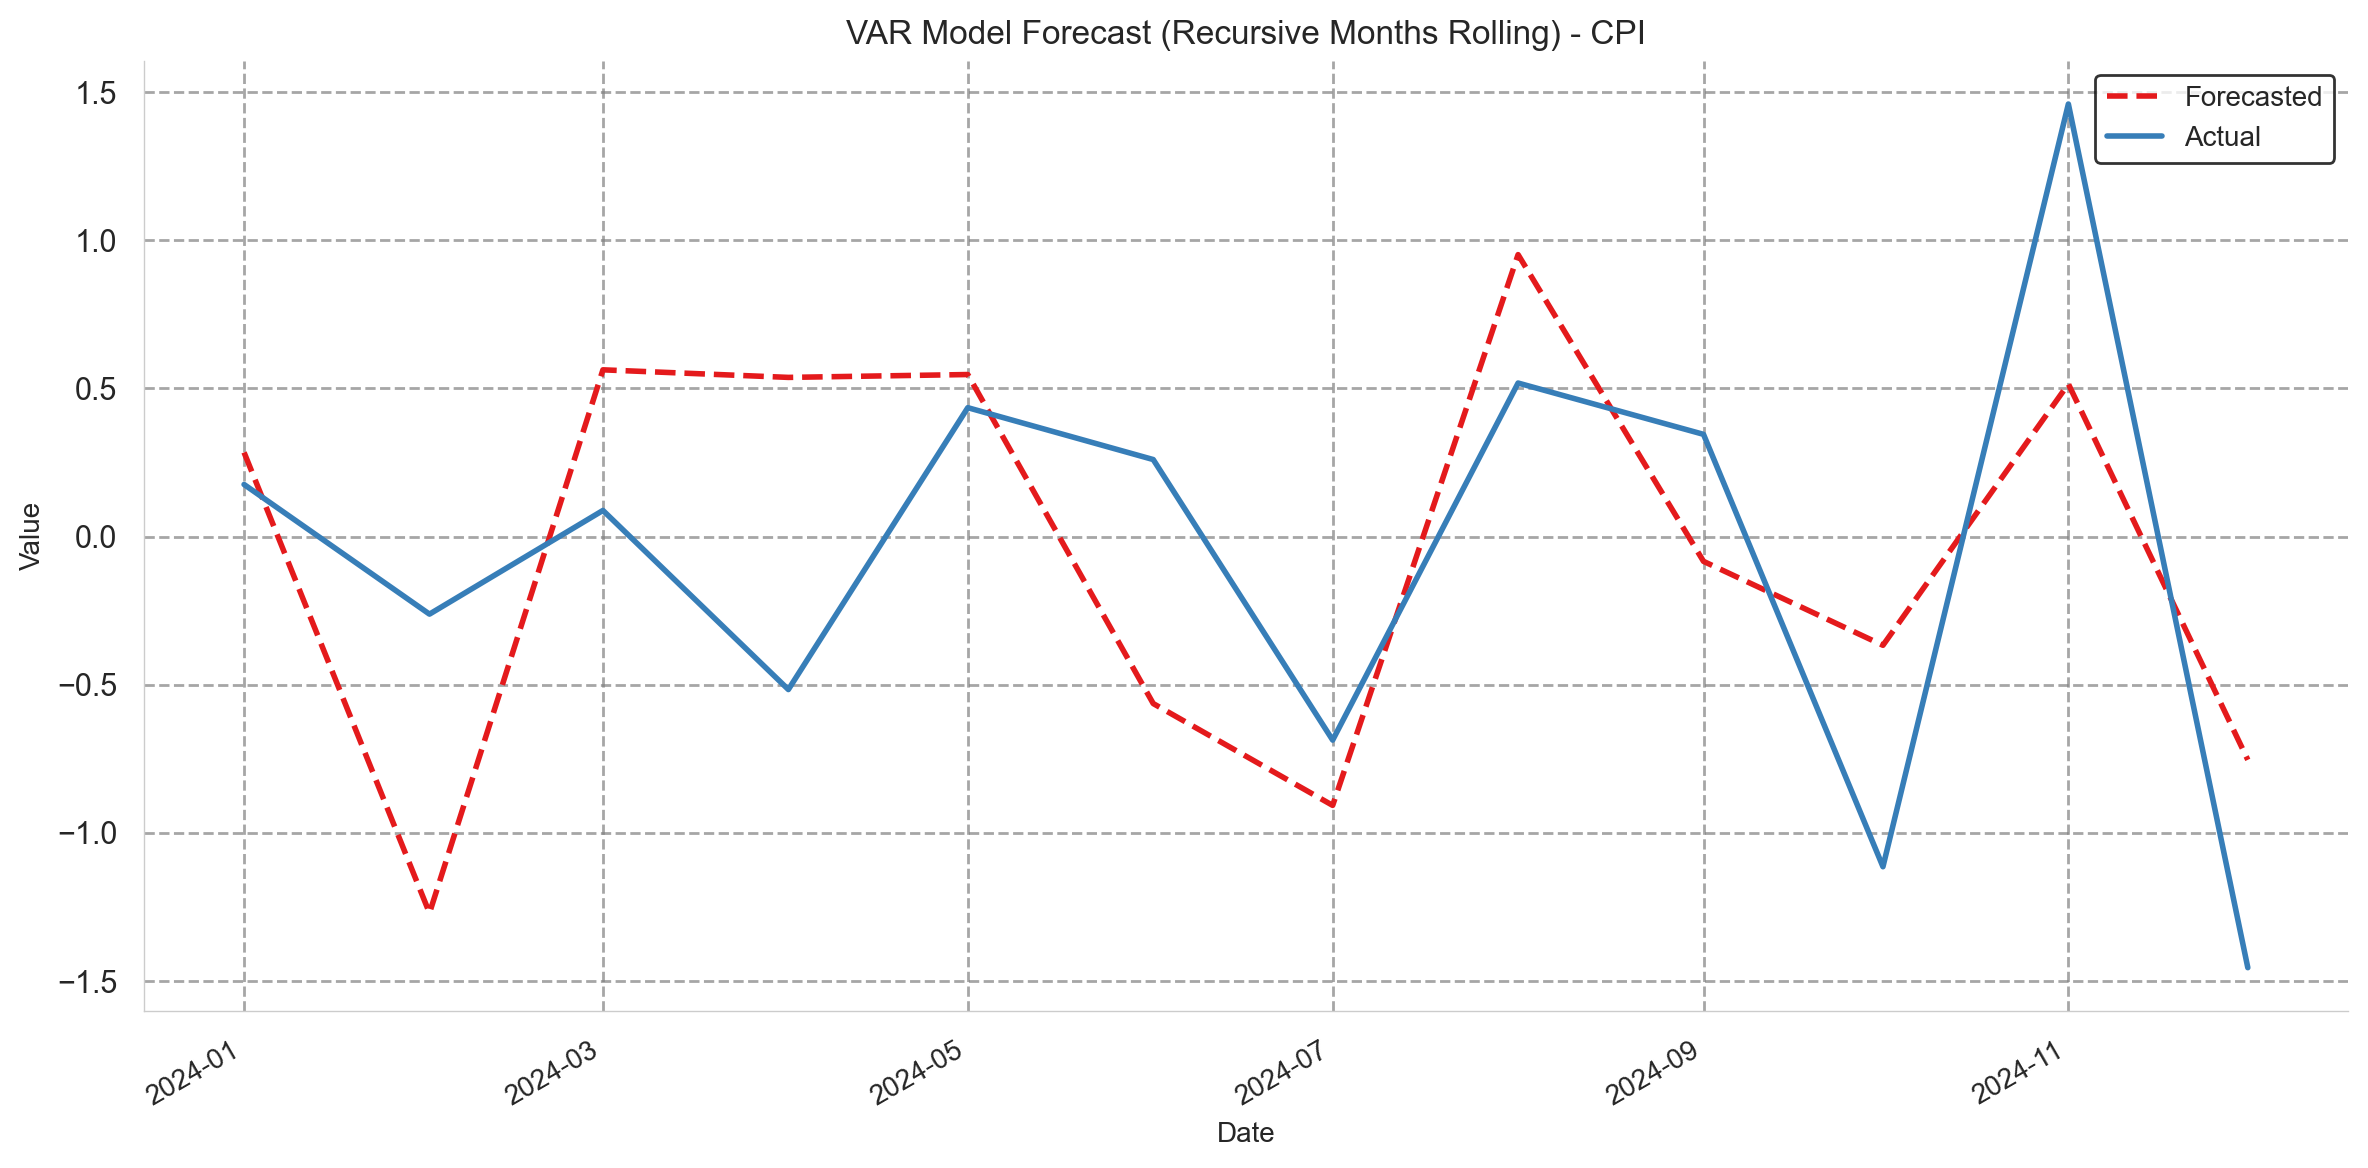

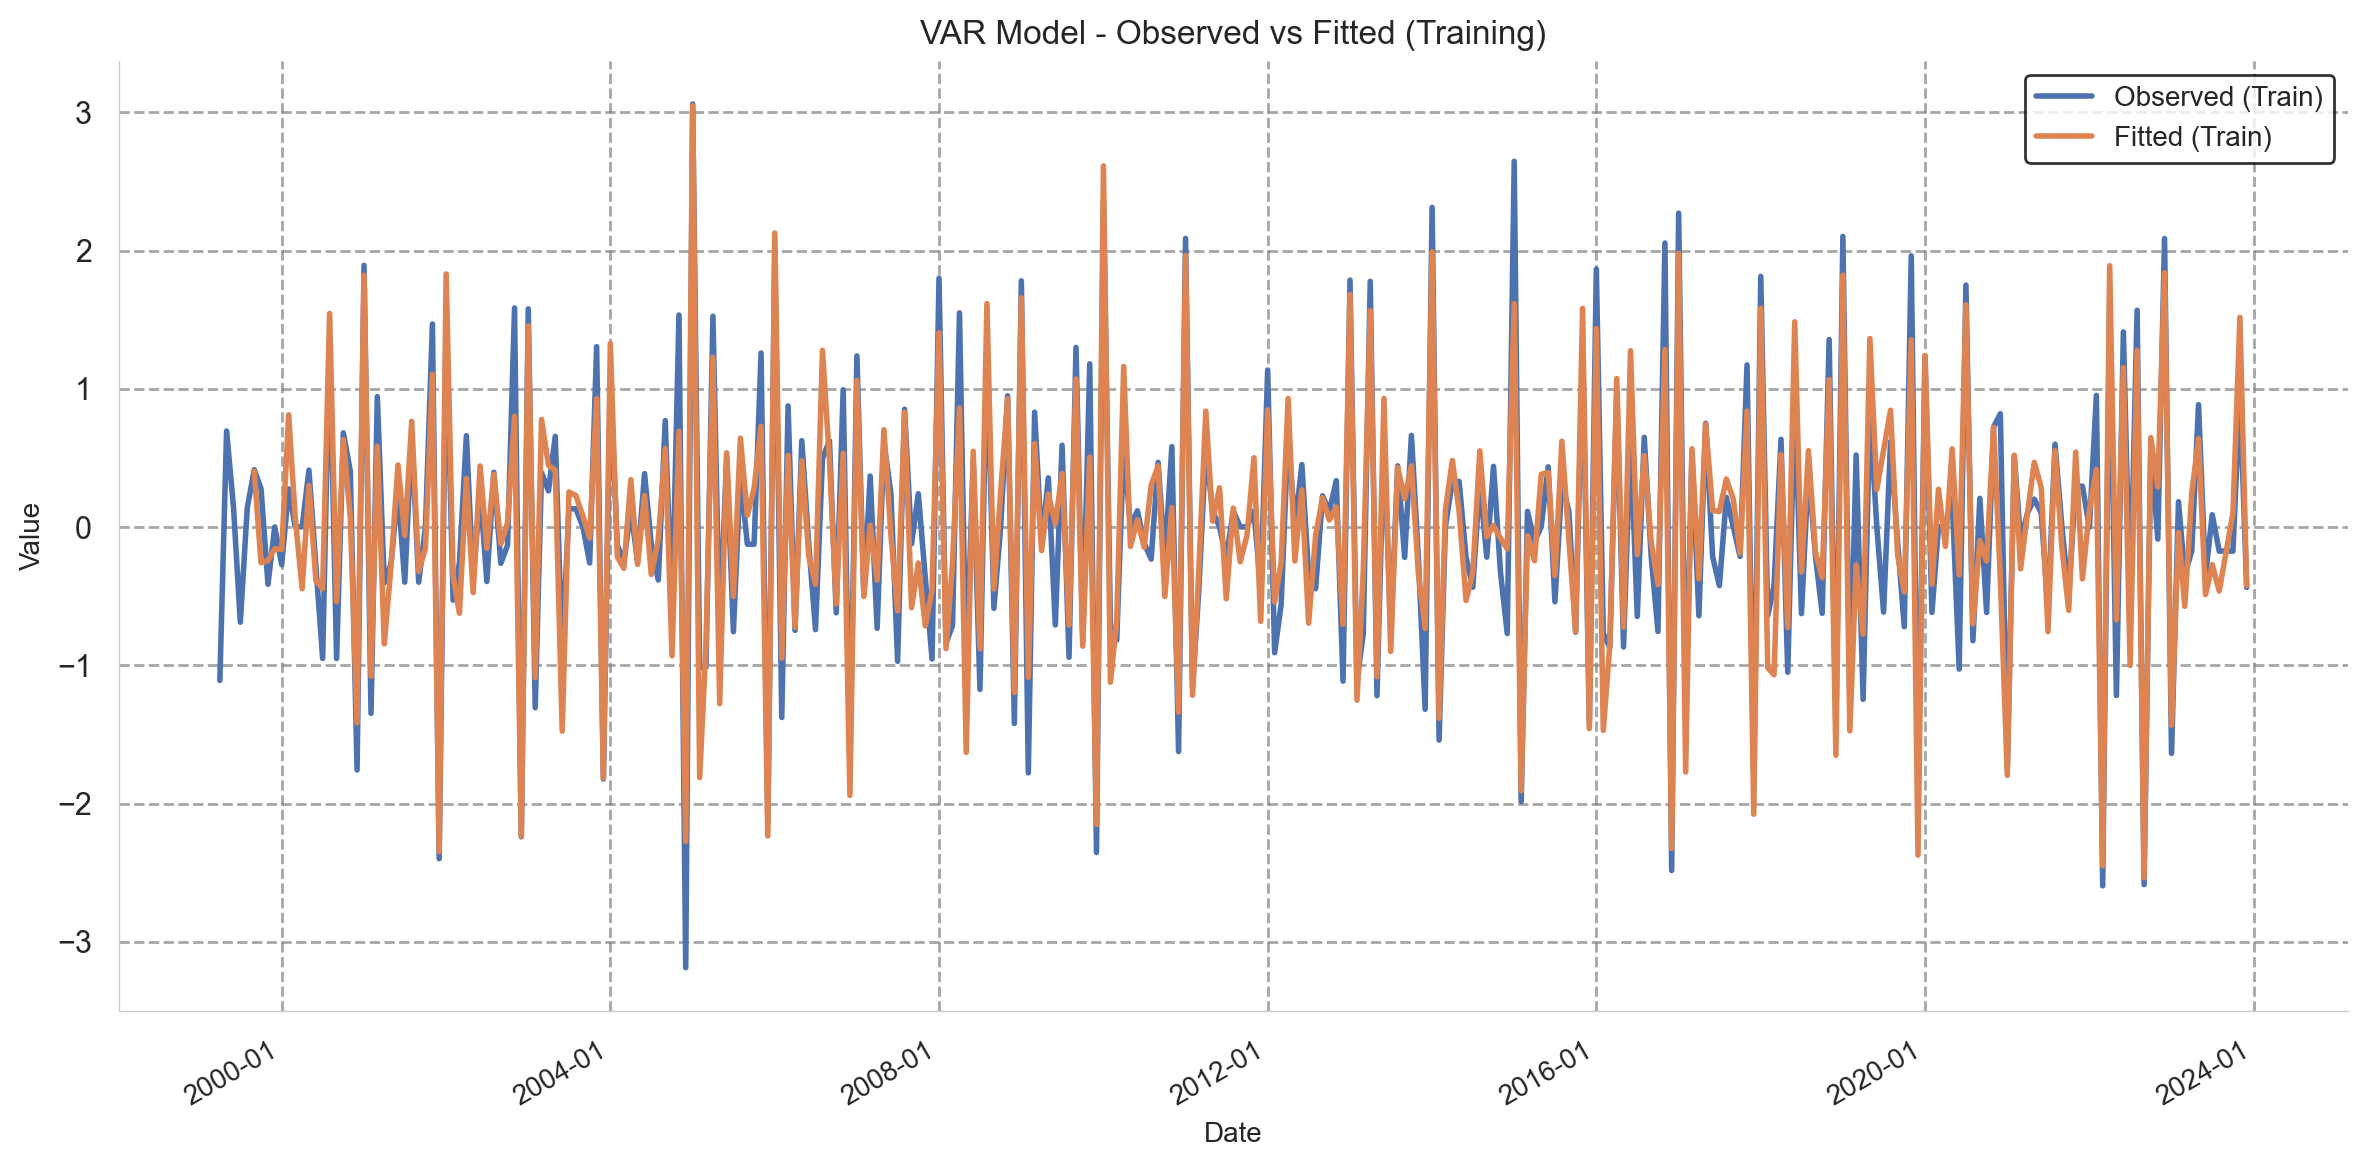

In [14]:
# # Forecast the next 12 months
model, forecasted_cpi, actual_cpi, var_train_df, var_mae, var_rmse = var_forecast(var_model, var_train.copy(), var_test.copy(), var_lag_order, test_size)
var_model_forecast_plot = plot_forecast(forecasted_cpi, actual_cpi, title_name='VAR Model Forecast (Recursive Months Rolling) - CPI')
var_observed_vs_fitted_plot = plot_observed_vs_fitted_var(model, var_train_df, target, 'VAR Model - Observed vs Fitted (Training)')


# ***ARIMA Training and Test***

In [15]:
arima_train_df = df_cpi_target.iloc[:-test_size]
arima_test_df = df_cpi_target.iloc[-test_size:]
# Extract CPI series for ARIMA
train_cpi_arima = arima_train_df.copy()[target]
test_cpi_arima = arima_test_df.copy()[target]

In [16]:

def arima_mm_forecast(train_df, test_df, auto_arima_model, forecast_horizon, title='ARIMA: Observed vs Fitted (24 Months Rolling)', target_column=target):
    """
    Performs a rolling multi-step-ahead ARIMA forecast for the entire test dataset.

    Parameters:
    - train_df (pd.DataFrame): Training data
    - test_df (pd.DataFrame): Test data
    - target_column (str): The target variable for evaluation (default 'CPIAUCSL')
    - steps (int): Number of steps ahead for each rolling forecast

    Returns:
    - forecast_df (pd.DataFrame): Forecasted values for the entire test period
    - mae (float): Mean Absolute Error
    - rmse (float): Root Mean Squared Error
    """

    # Extract target series
    train_series = train_df
    test_series = test_df

    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()

    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Build output DataFrame
    forecast_index = test_series.index[:forecast_horizon]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:forecast_horizon]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))

    print(f"ARIMA Model - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"ARIMA Model - Root Mean Squared Error (RMSE): {rmse:.4f}")

    # # Generate and display plots
    # print("Absolute Error")
    # abs_error = np.abs(actual_series.values - forecast_df[target].values)
    # print(abs_error)

    plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_arima_observed_vs_fitted(model_fit, train_df, target_column=target_column, title=title) # Pass target_column

    plt.show()  # Display plots
    return forecast_df, mae, rmse


In [17]:
# For ARIMA order selection (non-seasonal):
auto_arima_model_arima = auto_arima(train_cpi_arima, seasonal=False, stepwise=True,
                                    suppress_warnings=True, error_action="ignore", max_order=10, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=324.149, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=850.334, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=608.355, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=520.668, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=327.614, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=381.371, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=381.243, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=326.914, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=396.768, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=325.058, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=374.778, Time=0.03 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=326.548, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=381.996, Time=0.11 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 0.732 seconds


# Results

ARIMA Model - Mean Absolute Error (MAE): 0.6432
ARIMA Model - Root Mean Squared Error (RMSE): 0.7756


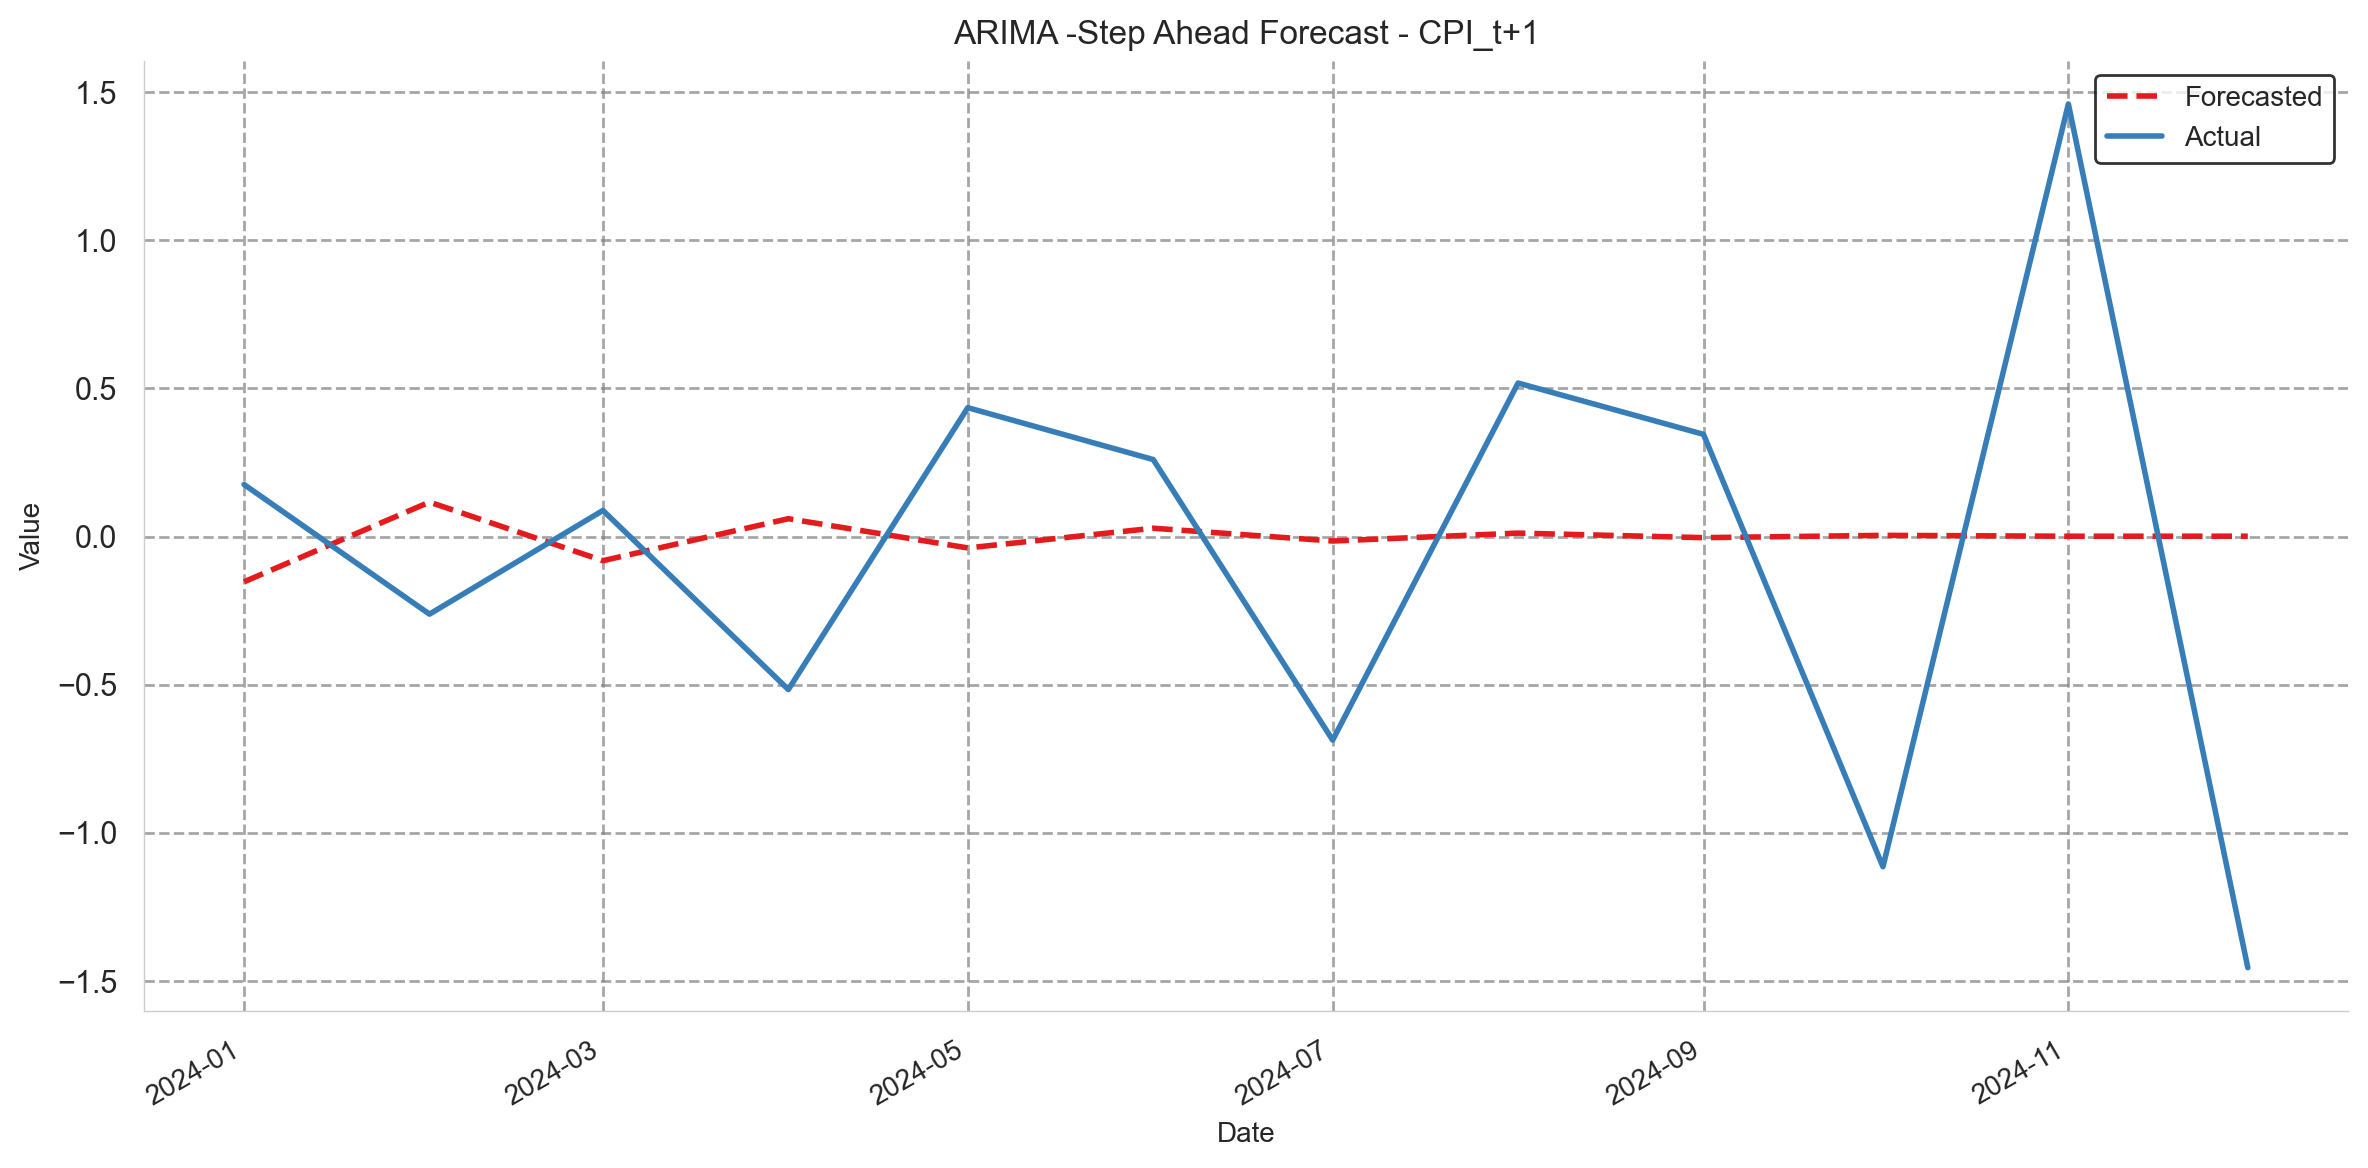

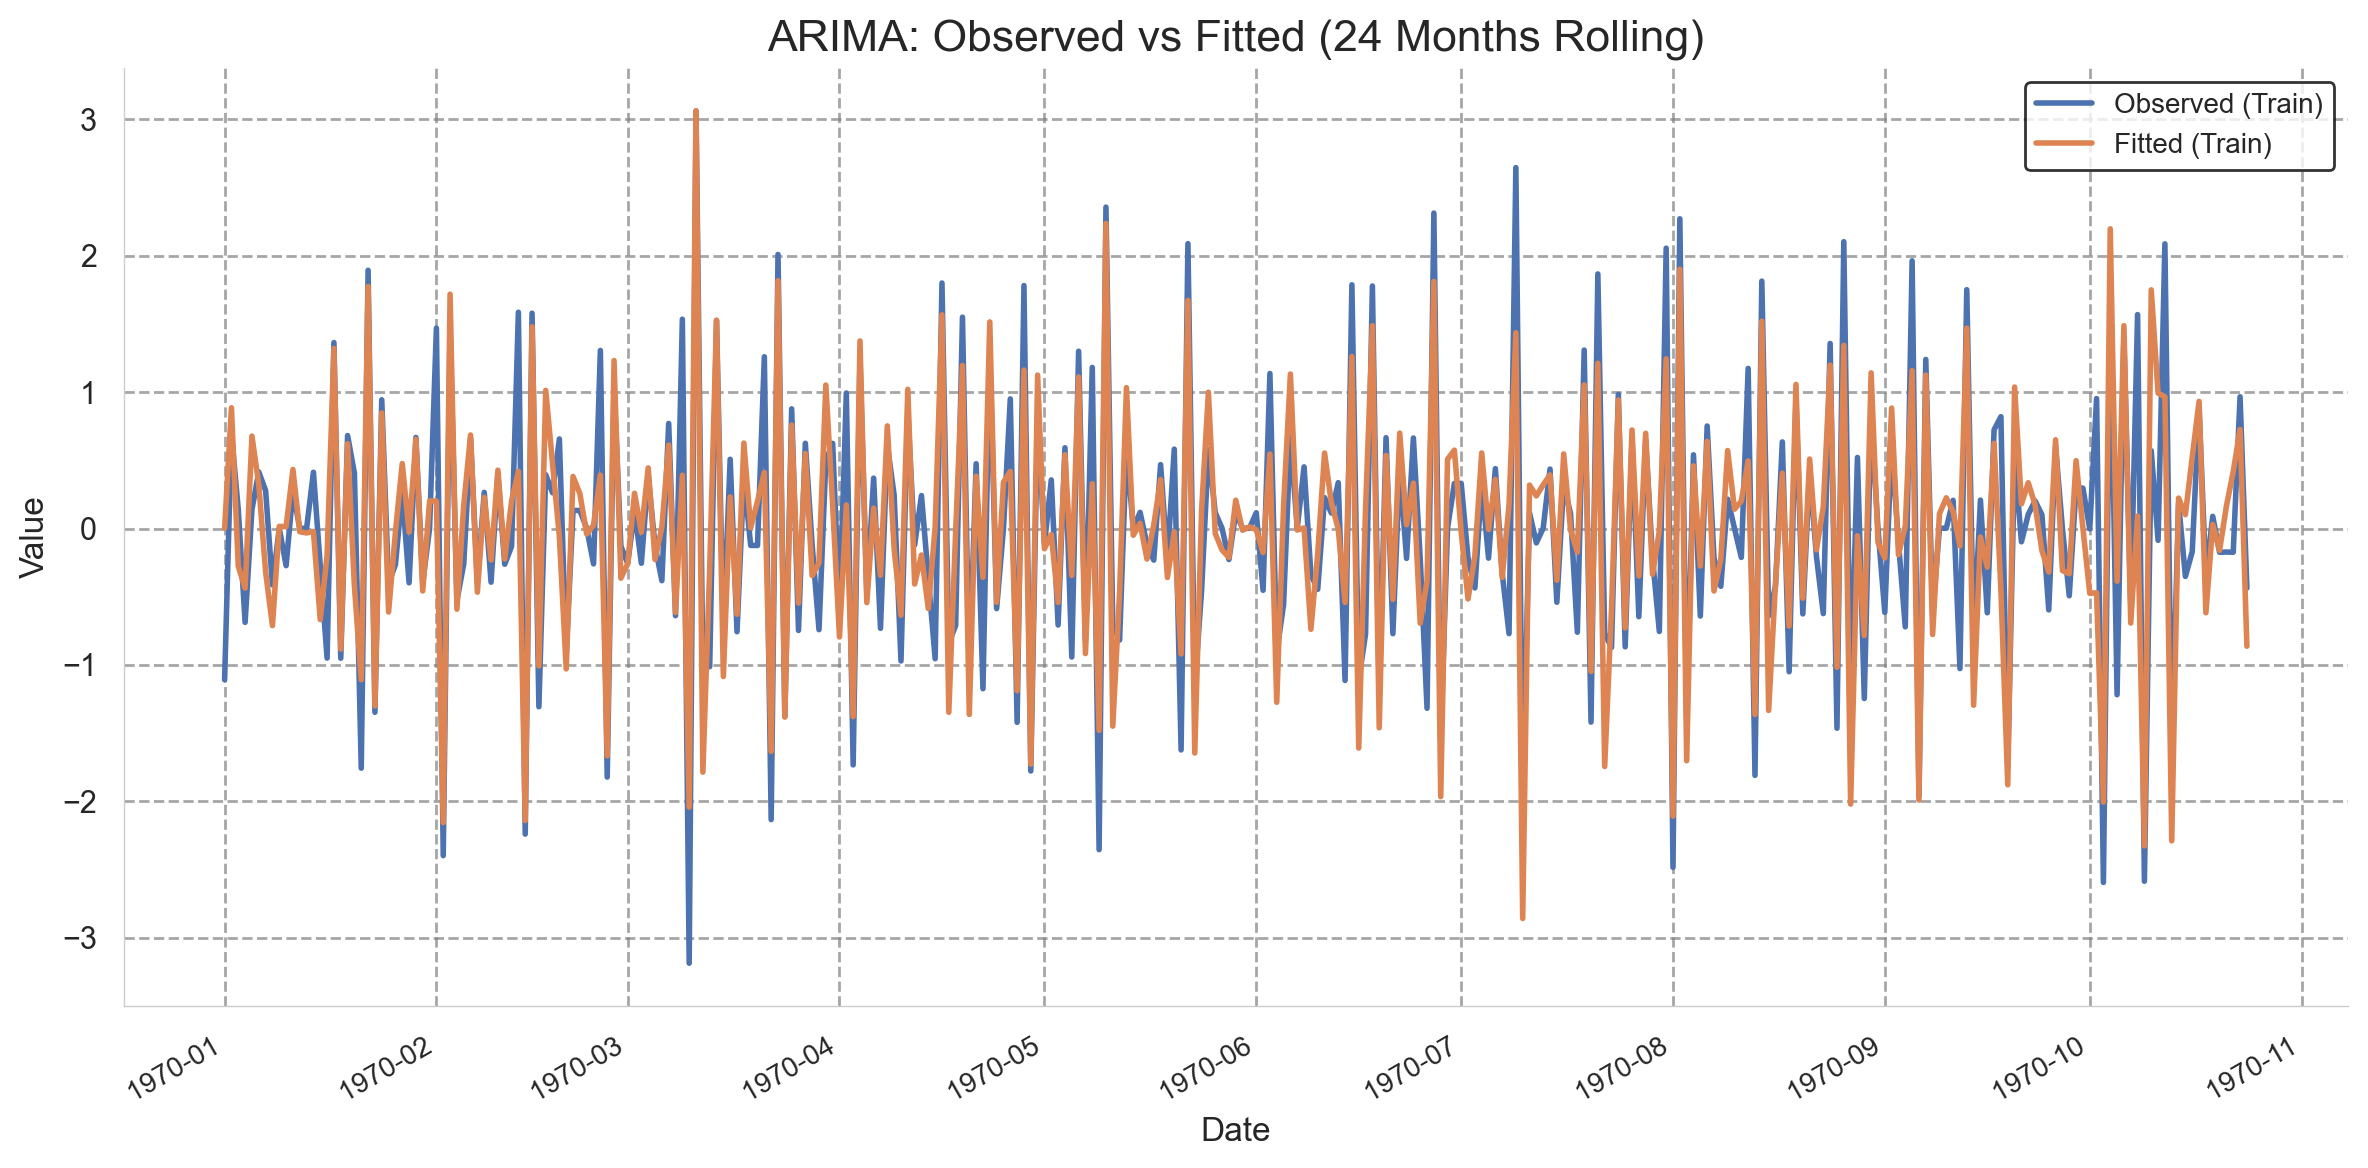

In [18]:
forecast_df, arima_mae, arima_rmse = arima_mm_forecast(train_cpi_arima, test_cpi_arima, auto_arima_model_arima, test_size)


# ***SARIMA Training & Test***


In [19]:
# For SARIMA order selection (seasonal):
auto_arima_model_sarima = auto_arima(train_cpi_arima, seasonal=True, m=12, stepwise=True, # m=12 for monthly seasonality
                                     suppress_warnings=True, error_action="ignore", max_order=10, trace=True,
                                     max_p=10, max_q=10, max_P=10, max_Q=10, verbose=0) # Limit search space


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=852.334, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=522.725, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=850.334, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=610.343, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=481.492, Time=0.24 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=469.413, Time=0.71 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=471.035, Time=0.97 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=470.966, Time=0.35 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=472.572, Time=3.70 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=715.279, Time=0.27 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=420.515, Time=0.72 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=43

In [20]:

def sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size, target_column=target):

    # Extract CPI series for SARIMA
    train_cpiauscl_arima = train_df
    test_cpiauscl_arima = test_df

    # Ensure the index is datetime for proper date manipulation
    train_cpiauscl_arima.index = pd.to_datetime(train_cpiauscl_arima.index)

    history = train_cpiauscl_arima.tolist()
    sarima_model = SARIMAX(history,
                          order=auto_arima_model_sarima.order,
                          seasonal_order=auto_arima_model_sarima.seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)

    forecast_df = pd.DataFrame(forecast, index=test_cpiauscl_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpiauscl_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpiauscl_arima, forecast_df[target_column]))

    # Print evaluation metrics
    print(f'Rolling SARIMA Model - Mean Absolute Error (MAE): {mae_sarima:.4f}')
    print(f'Rolling SARIMA Model - Root Mean Squared Error (RMSE): {rmse_sarima:.4f}')

    plot_forecast(forecast_df[target_column], test_cpiauscl_arima, title_name='Rolling SARIMA Model Forecast - CPI')
    # plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_arima_observed_vs_fitted(sarima_model_fit, train_df, target_column=target_column, title='SARIMA Model - Observed vs Fitted (24 Months Rolling)')
    plt.show()
    plt.show()

    return mae_sarima, rmse_sarima



# Result

Rolling SARIMA Model - Mean Absolute Error (MAE): 0.5534
Rolling SARIMA Model - Root Mean Squared Error (RMSE): 0.7645


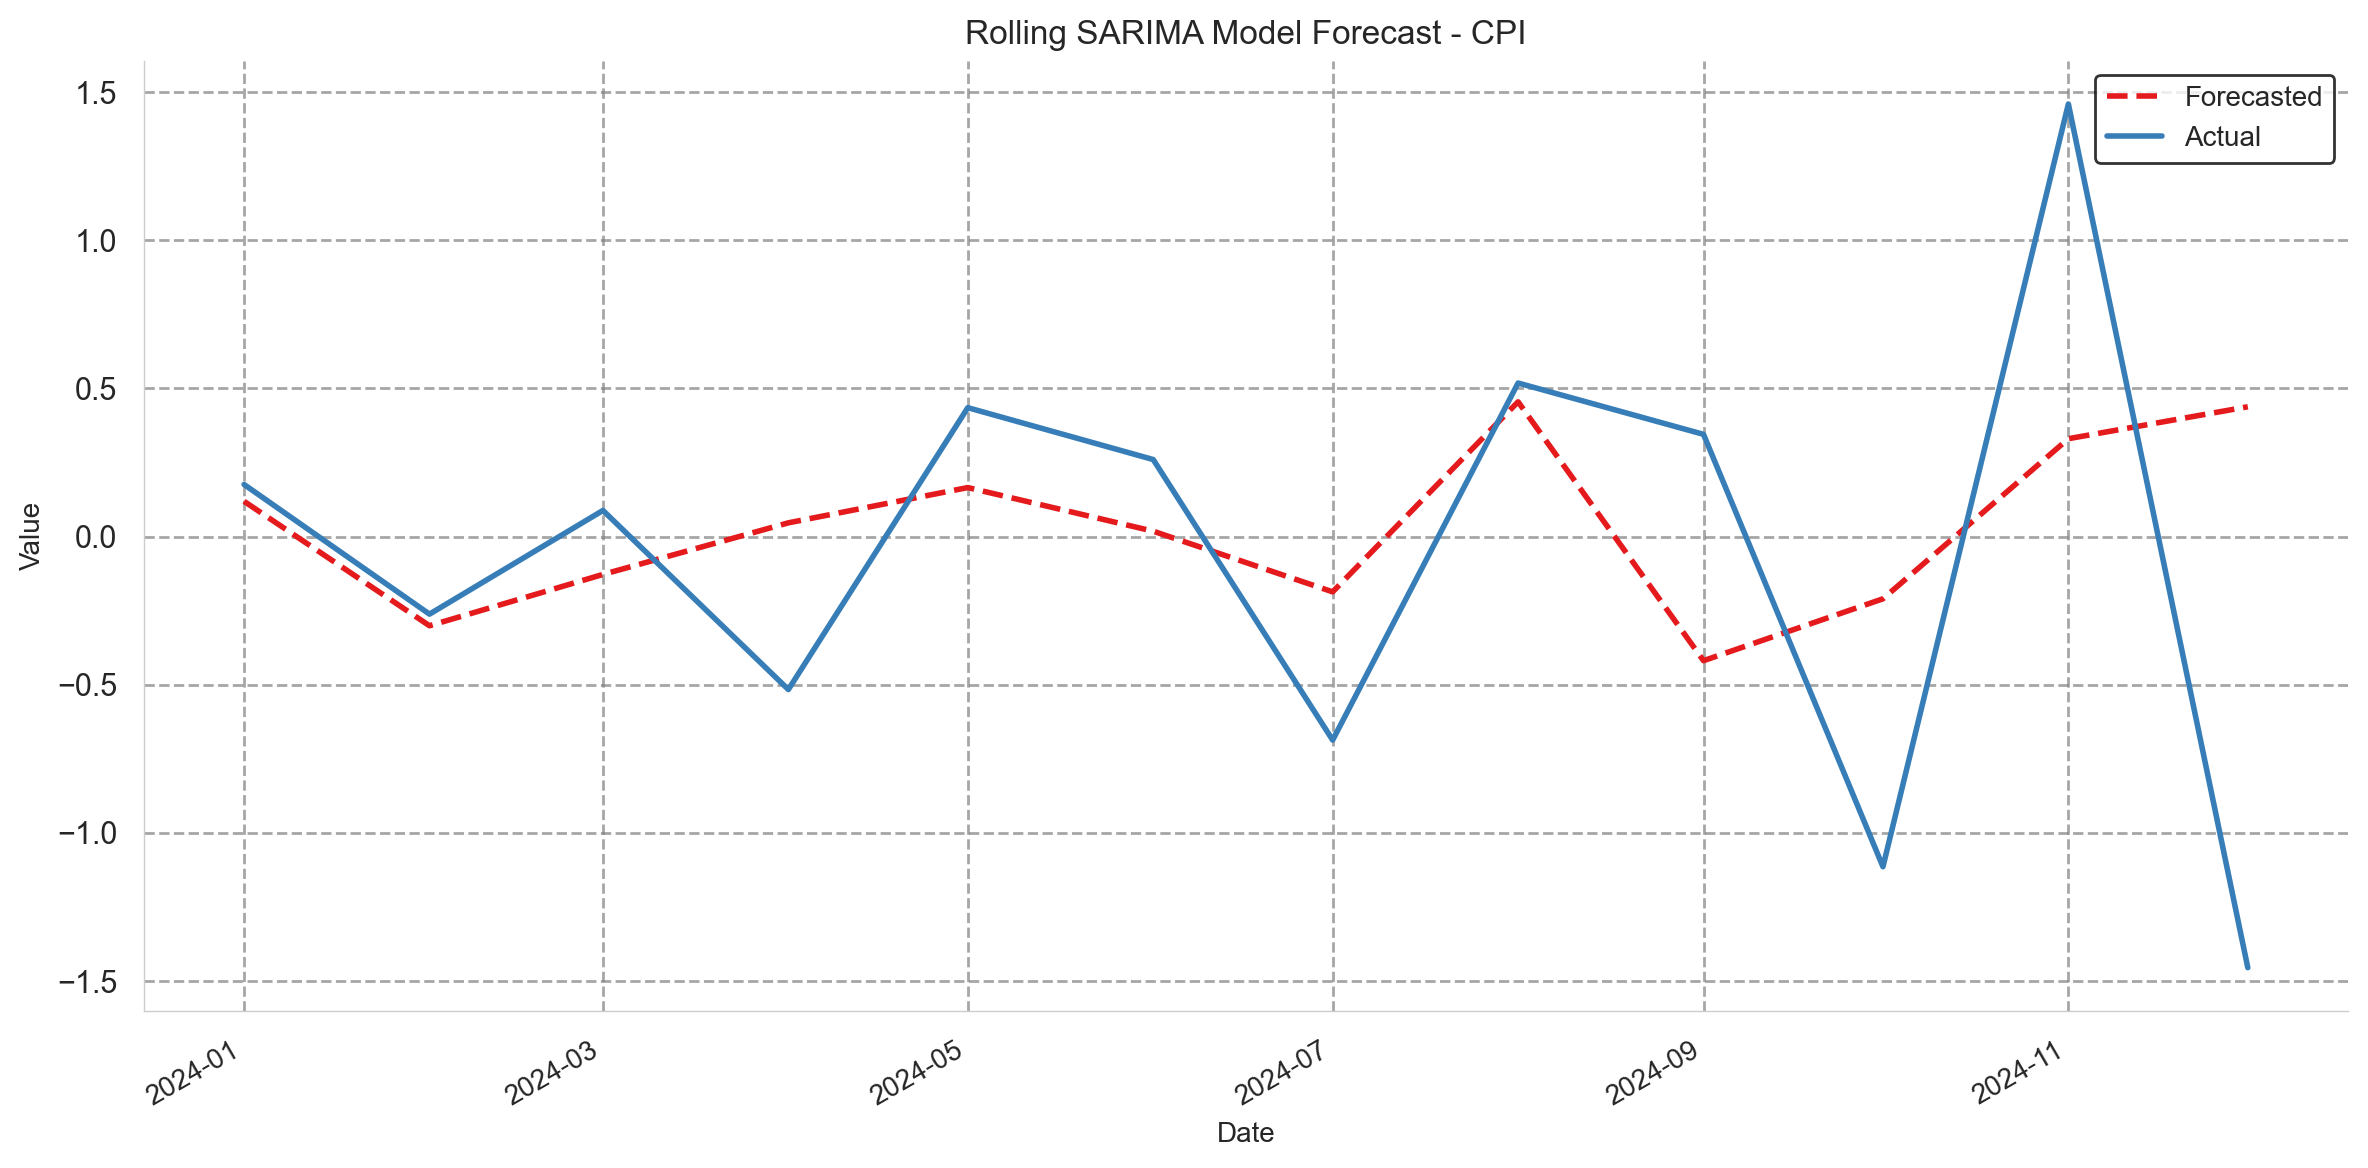

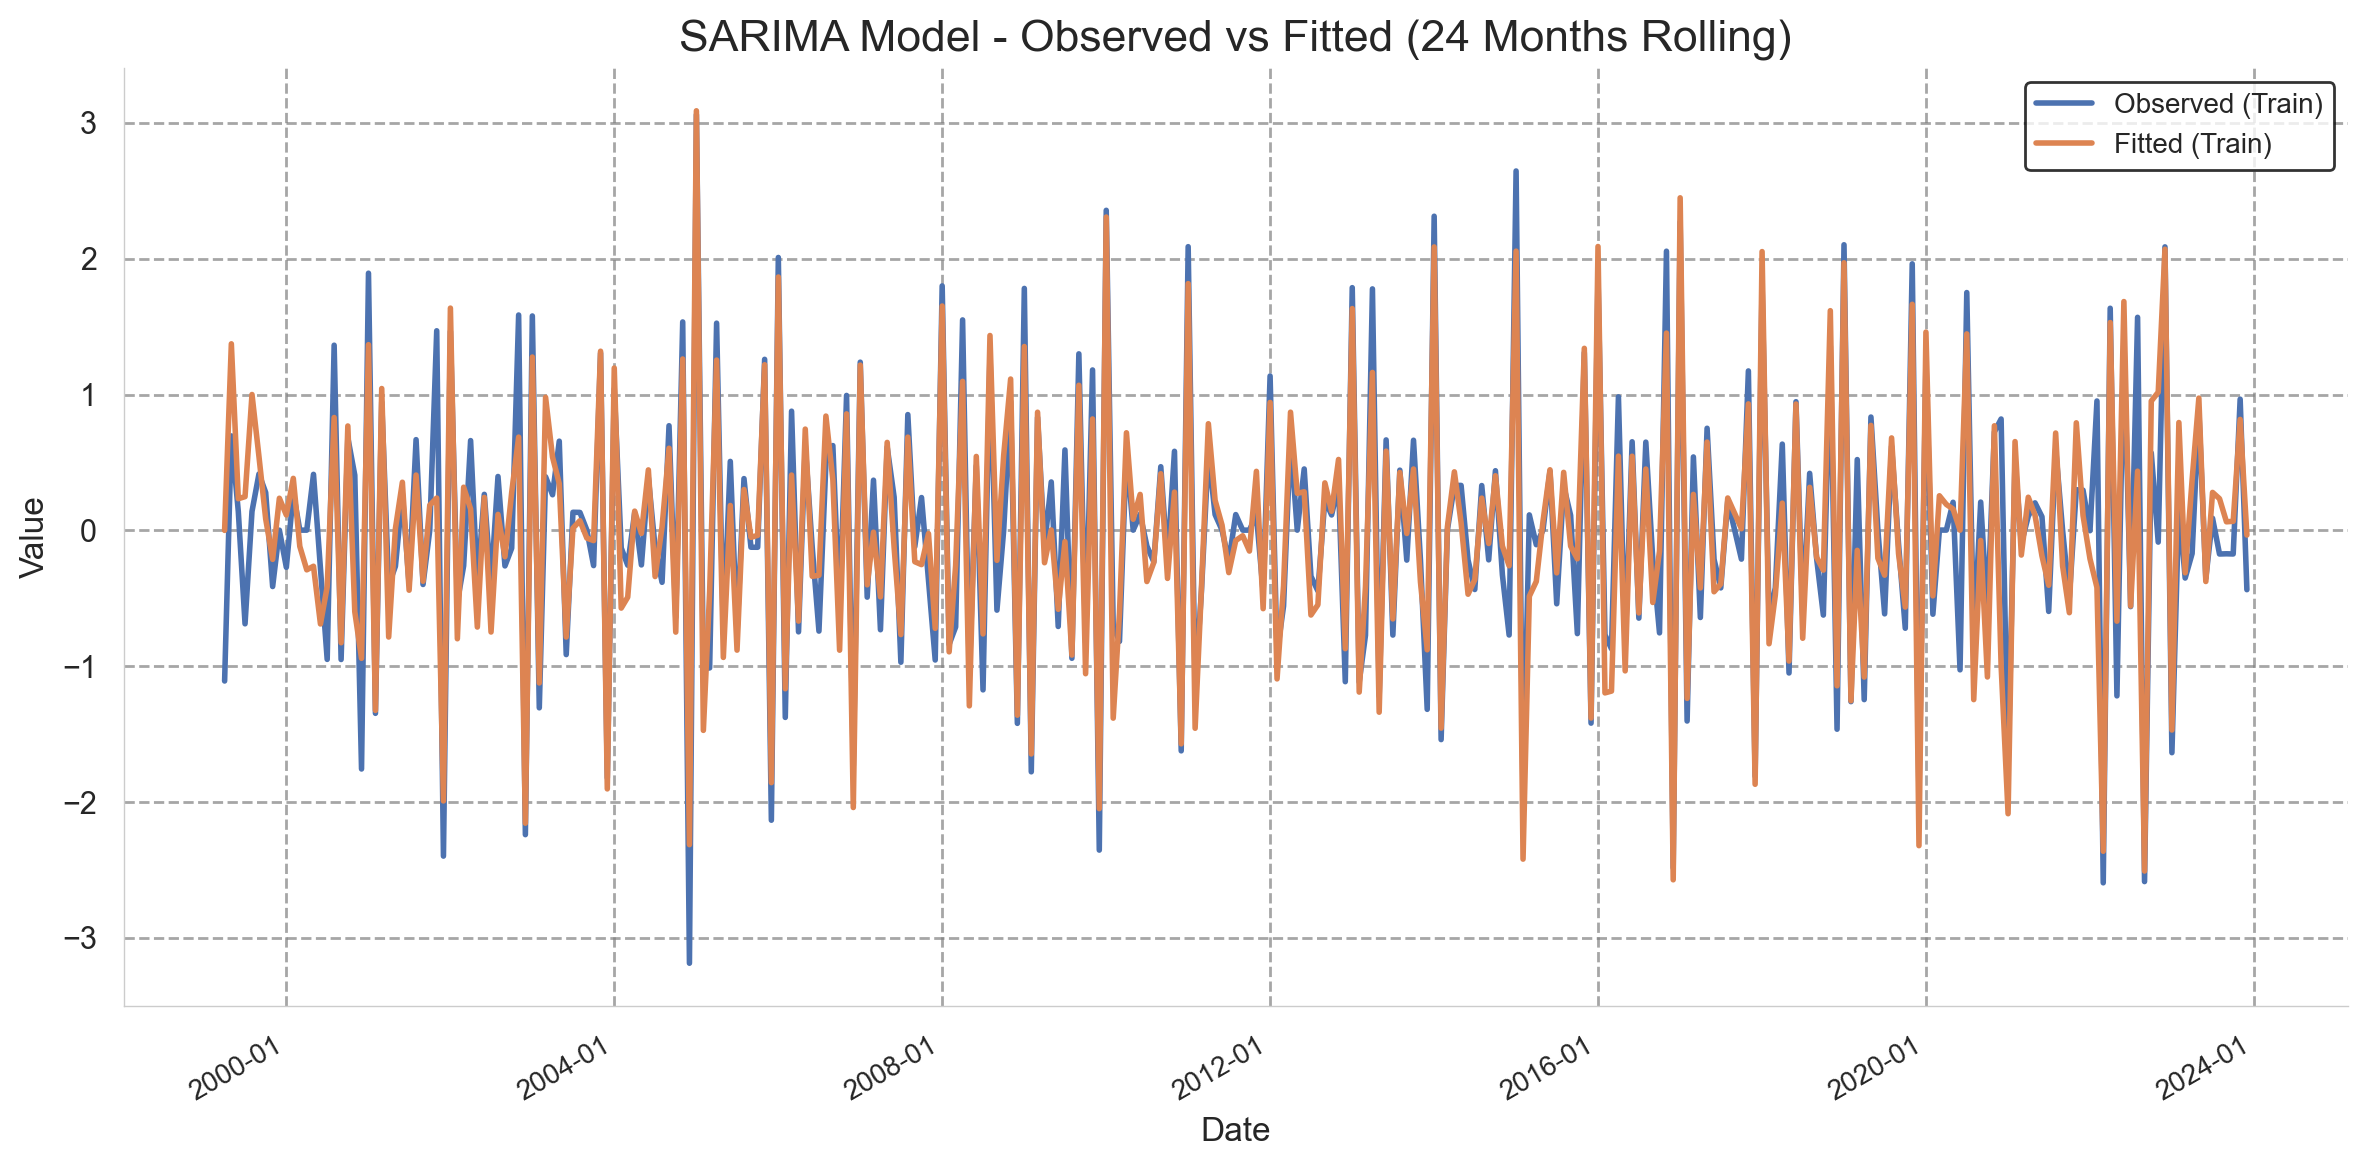

In [21]:

sarima_mae, sarima_rmse = sarima_mm_forecast(train_cpi_arima, test_cpi_arima, auto_arima_model_sarima, test_size)

# ***CNN-LSTM Training & Testing***

In [22]:

def prepare_data_convlstm2D(data, target_column, test_size, sequence_length=3, forecast_horizon=12, grid_shape=(6, 5)):
    """
    Prepares the data for multi-output ConvLSTM2D using temporal sequences.
    Features are reshaped into spatial grids per timestep.
    """
    feature_names = [col for col in data.columns if col != target_column]
    total_features = len(feature_names)
    rows, cols = grid_shape
    grid_size = rows * cols
    assert grid_size >= total_features, f"Grid shape {grid_size} is too small for number of features {total_features}."

    def pad_features_to_grid(features, rows, cols):
        padded_grid = np.zeros((features.shape[0], rows, cols, 1))
        for t in range(features.shape[0]):
            for idx, val in enumerate(features[t]):
                r, c = divmod(idx, cols)
                padded_grid[t, r, c, 0] = val
        return padded_grid

    # Generate sequences
    X, y, indices = [], [], []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        seq_x = data.iloc[i:i+sequence_length][feature_names].values
        seq_y = data.iloc[i + sequence_length:i + sequence_length + forecast_horizon][target_column].values
        X.append(seq_x)
        y.append(seq_y)
        indices.append(data.index[i + sequence_length])

    X = np.array(X)  # shape: (samples, timesteps, features)
    y = np.array(y)  # shape: (samples, forecast_horizon)
    indices = np.array(indices)

    # Normalize
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_flat = X.reshape(-1, total_features)
    X_scaled = scaler_X.fit_transform(X_flat).reshape(X.shape)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape for ConvLSTM2D: (samples, timesteps, rows, cols, channels)
    X_reshaped = np.array([
        pad_features_to_grid(sample, rows, cols) for sample in X_scaled
    ])  # shape: (samples, timesteps, rows, cols, 1)

    X_train = X_reshaped[:-1]
    y_train = y_scaled[:-1]
    X_test = X_reshaped[-1:]
    y_test = y_scaled[-1:]
    train_index = indices[:-1]
    test_index = indices[-forecast_horizon:]

    input_shape = X_reshaped.shape[1:]  # (timesteps, rows, cols, 1)
    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names, input_shape


def prepare_data_conv_1D(data, target_column, test_size, timesteps=3, forecast_horizon=12):
    """
    Prepares data for Conv1D models with sliding window of specified timesteps.
    Returns scaled and reshaped train/test splits along with metadata.
    """
    data = data.copy()
    feature_names_used = data.drop(columns=target_column).columns.tolist()

    # Extract feature and target arrays
    X_all = data.drop(columns=target_column).values
    y_all = data[target_column].values.reshape(-1, 1)

    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_all_scaled = scaler_X.fit_transform(X_all)
    y_all_scaled = scaler_y.fit_transform(y_all)

    # Build sequences
    X_seq = []
    y_seq = []

    for i in range(len(X_all_scaled) - timesteps - forecast_horizon + 1):
        X_seq.append(X_all_scaled[i:i+timesteps])
        y_seq.append(y_all_scaled[i+timesteps:i+timesteps+forecast_horizon].flatten())

    # X_seq, y_seq = create_sequences_multi(X_all_scaled, y_all_scaled, timesteps, forecast_horizon)
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    X_train = X_seq[:-1]  # All except the last input window
    y_train = y_seq[:-1]
    X_test = X_seq[-1:]   # Only last window predicts the final 12 steps
    y_test = y_seq[-1:]

    train_index = data.index[timesteps - 1: timesteps - 1 + len(X_train)]
    test_index = data.index[-forecast_horizon:]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape


def add_time_features(data):
    df = data.copy()
    df.index = pd.to_datetime(df.index)

    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    return df.drop(columns=['month', 'quarter', 'year'])  # drop only if you keep cyclical encodings


In [23]:

def build_model_convlstm2D(input_shape):
    """
    Builds and compiles a ConvLSTM2D model with input shape:
    (timesteps, rows, cols, channels)
    """
    model = Sequential([
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=True, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.003)),
        Dropout(0.3),
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=False, padding='same', kernel_regularizer=l2(0.003)),
        Dropout(0.3),
        Flatten(),
        Dense(12)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_model_conv1D(input_shape, output_horizon=12):
    model = Sequential([
        Conv1D(filters=8, kernel_size=3, activation='tanh', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Conv1D(filters=8, kernel_size=3, activation='tanh', padding='same', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Flatten(),
        # Dense(32, activation='linear'),
        Dense(output_horizon)
    ])
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

def build_model_convlstm1D(input_shape):
    """Builds a hybrid CNN-LSTM model."""
    model = Sequential([
        Conv1D(filters=8, kernel_size=3, activation='tanh', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.003)),
        LSTM(8, return_sequences=True),
        Dropout(0.3),
        Conv1D(filters=8, kernel_size=3, activation='tanh',padding='same', kernel_regularizer=l2(0.003)),
        LSTM(8, return_sequences=True),
        Dropout(0.3),
        # LSTM(16),
        Flatten(),
        Dense(12)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_model(model, X_train, y_train, batch_size=16):
    """Trains the model with early stopping."""
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_dataset, epochs=600, callbacks=[early_stopping], verbose=0)
    return history

def evaluate_model(model, X_test, y_test, batch_size=16):
    """Evaluates the model and returns the test loss and predictions."""
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)
    loss = model.evaluate(test_dataset, verbose=0)
    predictions = model.predict(test_dataset, verbose=0)
    return loss, predictions

def inverse_transform(scaler, data):
    """Inverse transforms the scaled data."""
    return scaler.inverse_transform(data)

def model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    predictions_train = model.predict(X_train, verbose=0) # Predict on X_train
    predictions_train_actual = inverse_transform(scaler_y, predictions_train) # Inverse transform fitted values
    y_train_actual = inverse_transform(scaler_y, y_train) # Inverse transform y_train

    print(f'Mean Absolute Error (MAE): {mae:.8f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.8f}')
    # Plot only the 1st forecast horizon step (or average over all)
    plot_cnn_forecast = plot_predictions(
        y_test_actual[0], predictions_actual[0], test_index
    )
    plot_cnn_obs_vs_fitted = plot_observed_vs_fitted(
        y_train_actual[:, 0], predictions_train_actual[:, 0], train_index
    )
    return model, X_train, X_test, mae, rmse



Variant CNN Models

In [24]:
def conv1D(data, target, test_size=test_size, lookback=1):
    assert lookback >= 1, "Lookback must be at least 1: To represent values at time t"
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_conv1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def convlstm2D(data, target, test_size=test_size, lookback=1):
    assert lookback >= 1, "Lookback must be at least 1: To represent values at time t"
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size, sequence_length=lookback)
    model = build_model_convlstm2D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def convlstm1D(data, target, test_size=test_size, lookback=1):
    assert lookback >= 1, "Lookback must be at least 1: To represent values at time t"
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_convlstm1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used


1 CNN 1D (C1D) No feature engineering:
Base CNN Model NFE + 12 step look back

In [25]:
main_vars_n_target_cols = np.append(main_vars_cols, "CPI_t+1")
print(main_vars_n_target_cols)
df_nfe = df[main_vars_n_target_cols]

['UNERWG' 'ECBIRRO' 'ECBDFR' 'ECBMLFR' 'MMR' 'CPI' 'RETAILMV' 'RETAILXMV'
 'RETAILGSR' 'RETAILGF' 'GOODFBT' 'AGRPROD' 'PPIIP' 'WPI' 'EPI' 'IPI'
 'HICP' 'LTIR' 'UR' 'DAX' 'STOXX50E' 'EW' 'CPI_t+1']


Mean Absolute Error (MAE): 0.31348083
Root Mean Squared Error (RMSE): 0.41704505


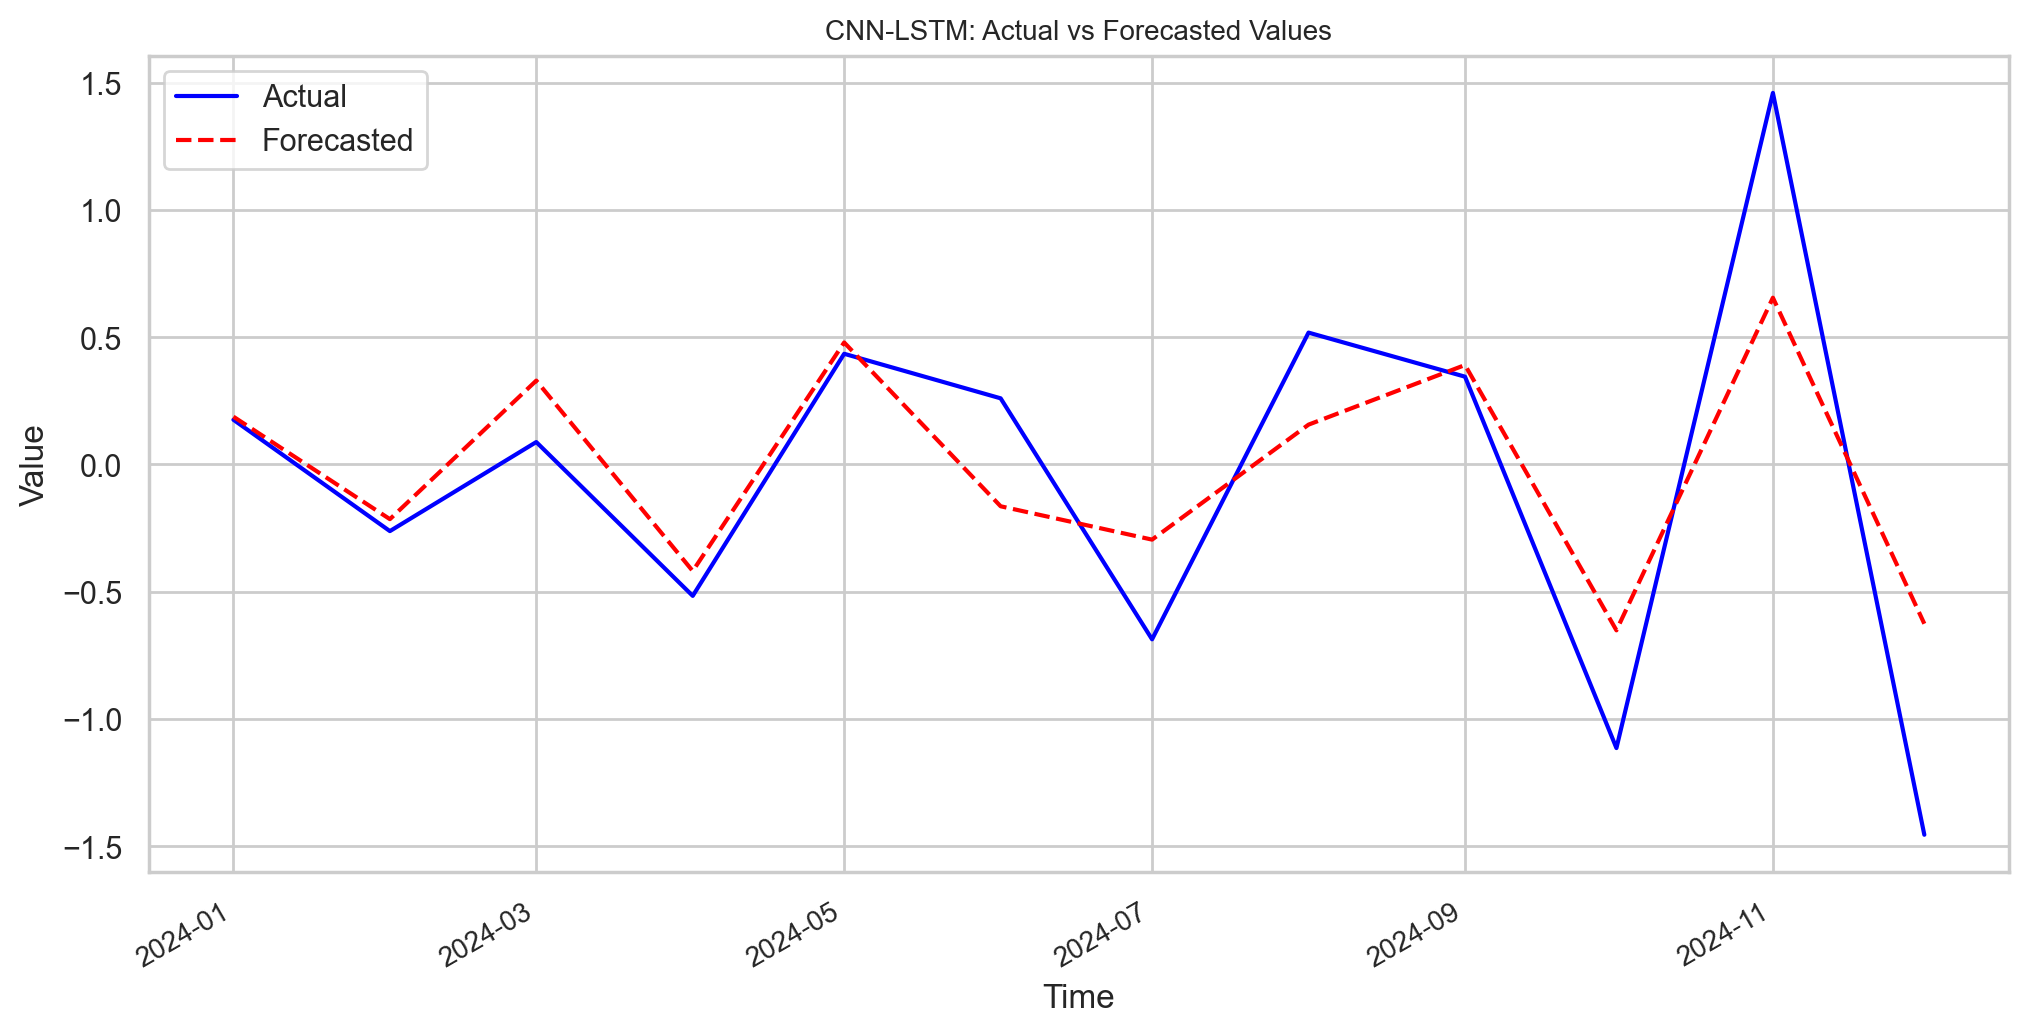

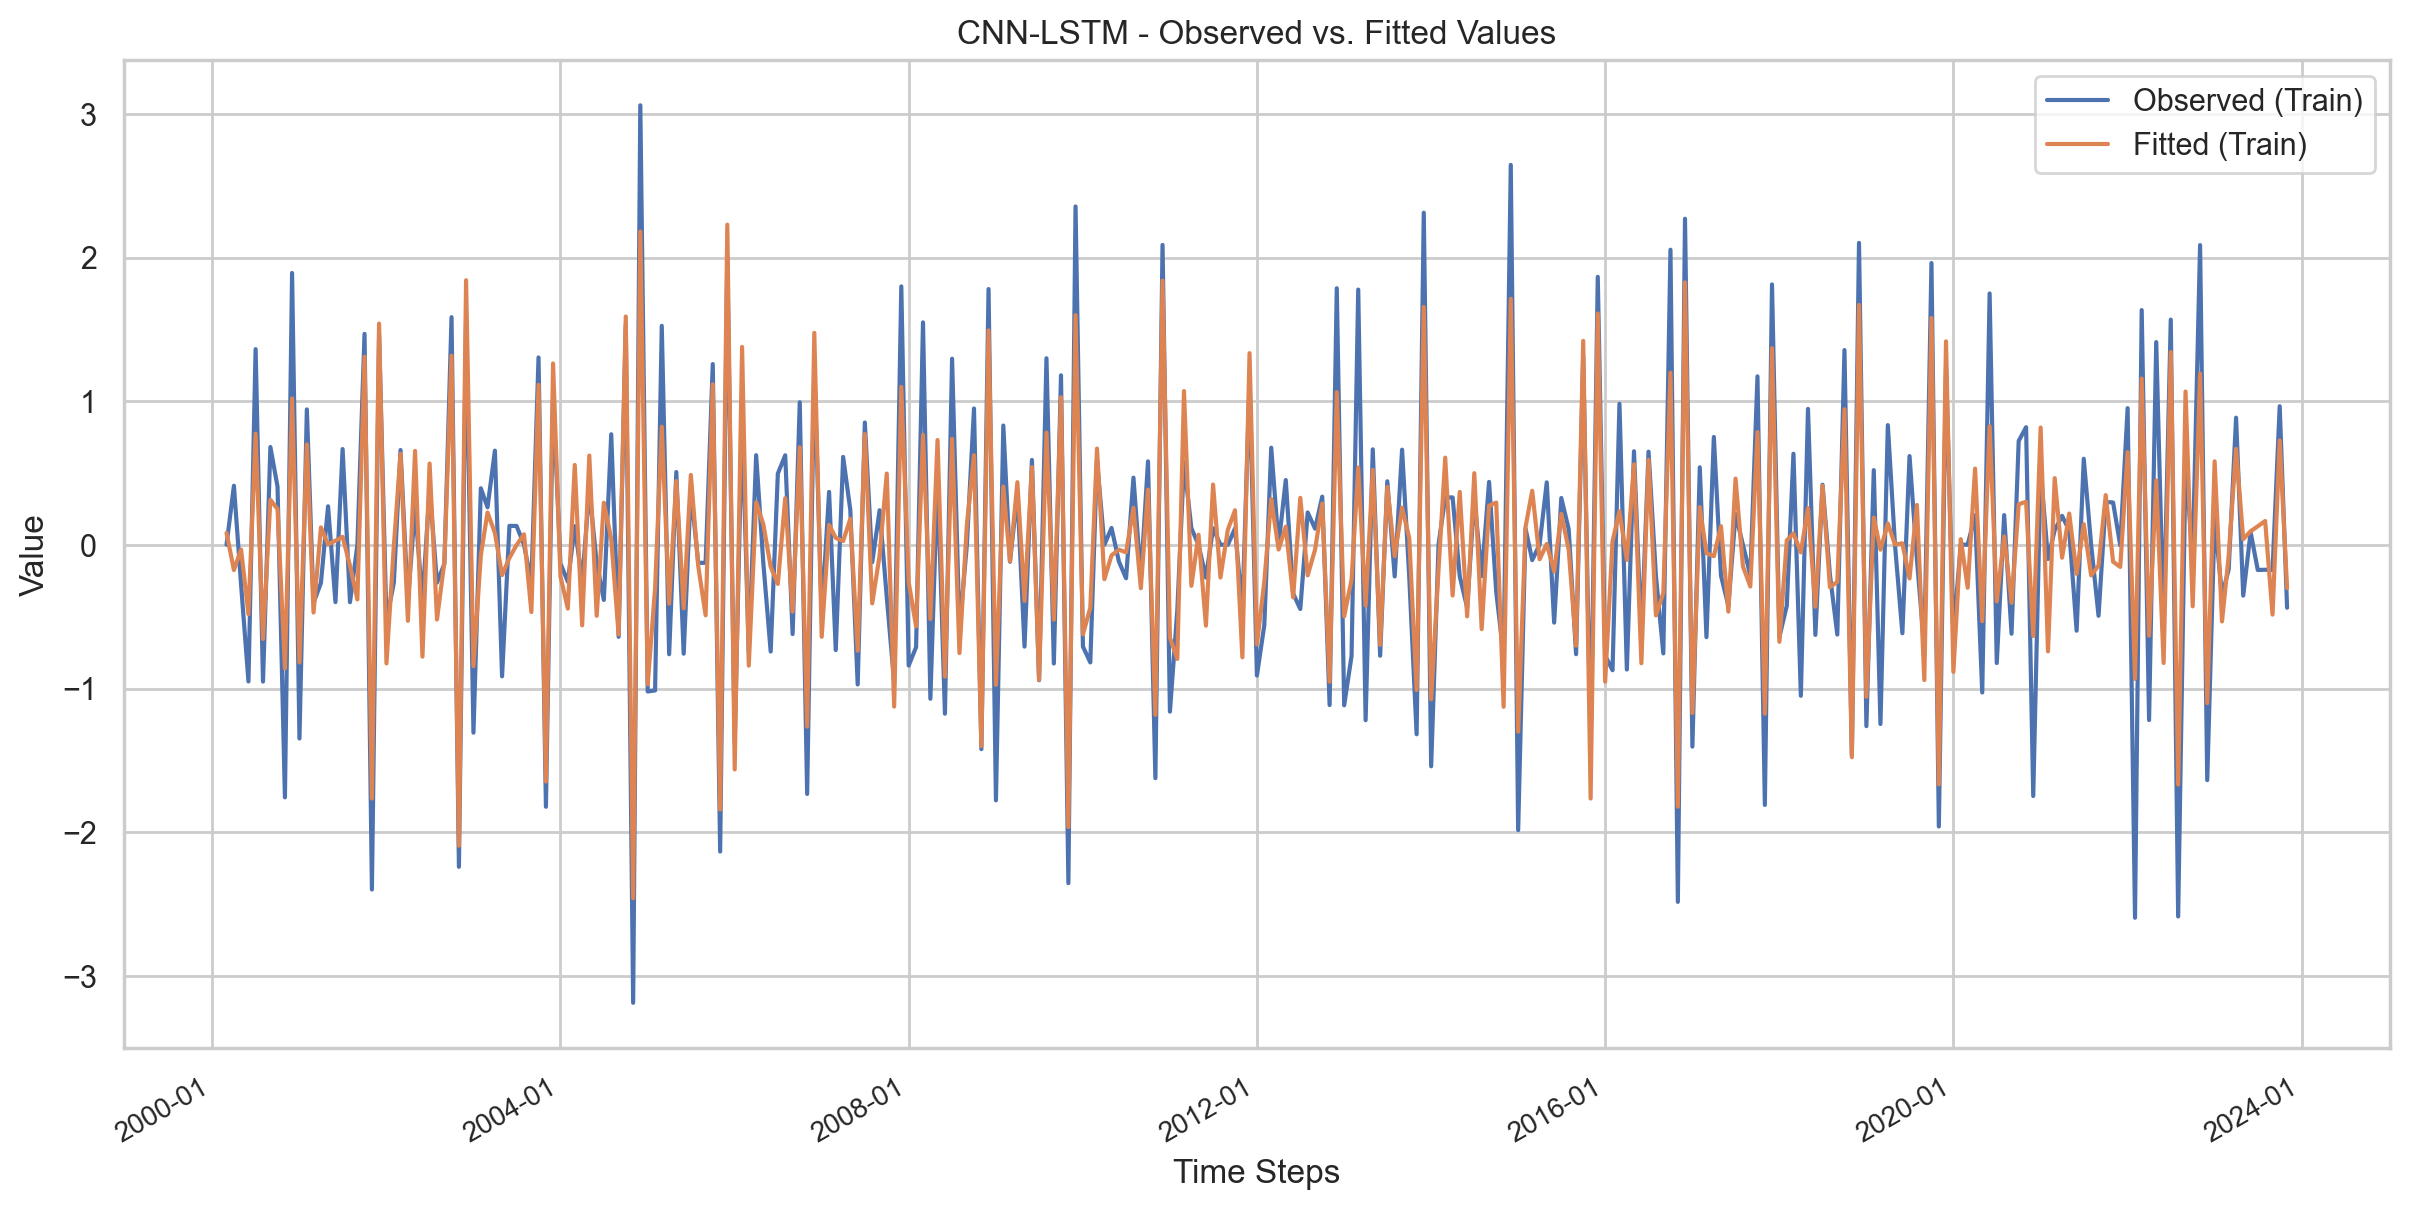

In [26]:
model_C1D_nfe, X_train_C1D_nfe, X_test_C1D_nfe, mae_C1D_nfe, rmse_C1D_nfe, fnames_C1D_nfe = conv1D(df_nfe, target, test_size, 12)

2 CNN 1D (C1D) + Time feature: 2. Base CNN Model + Time Engineering + 30 step look back (ACF/PACF guided)

Mean Absolute Error (MAE): 0.28473943
Root Mean Squared Error (RMSE): 0.35279409


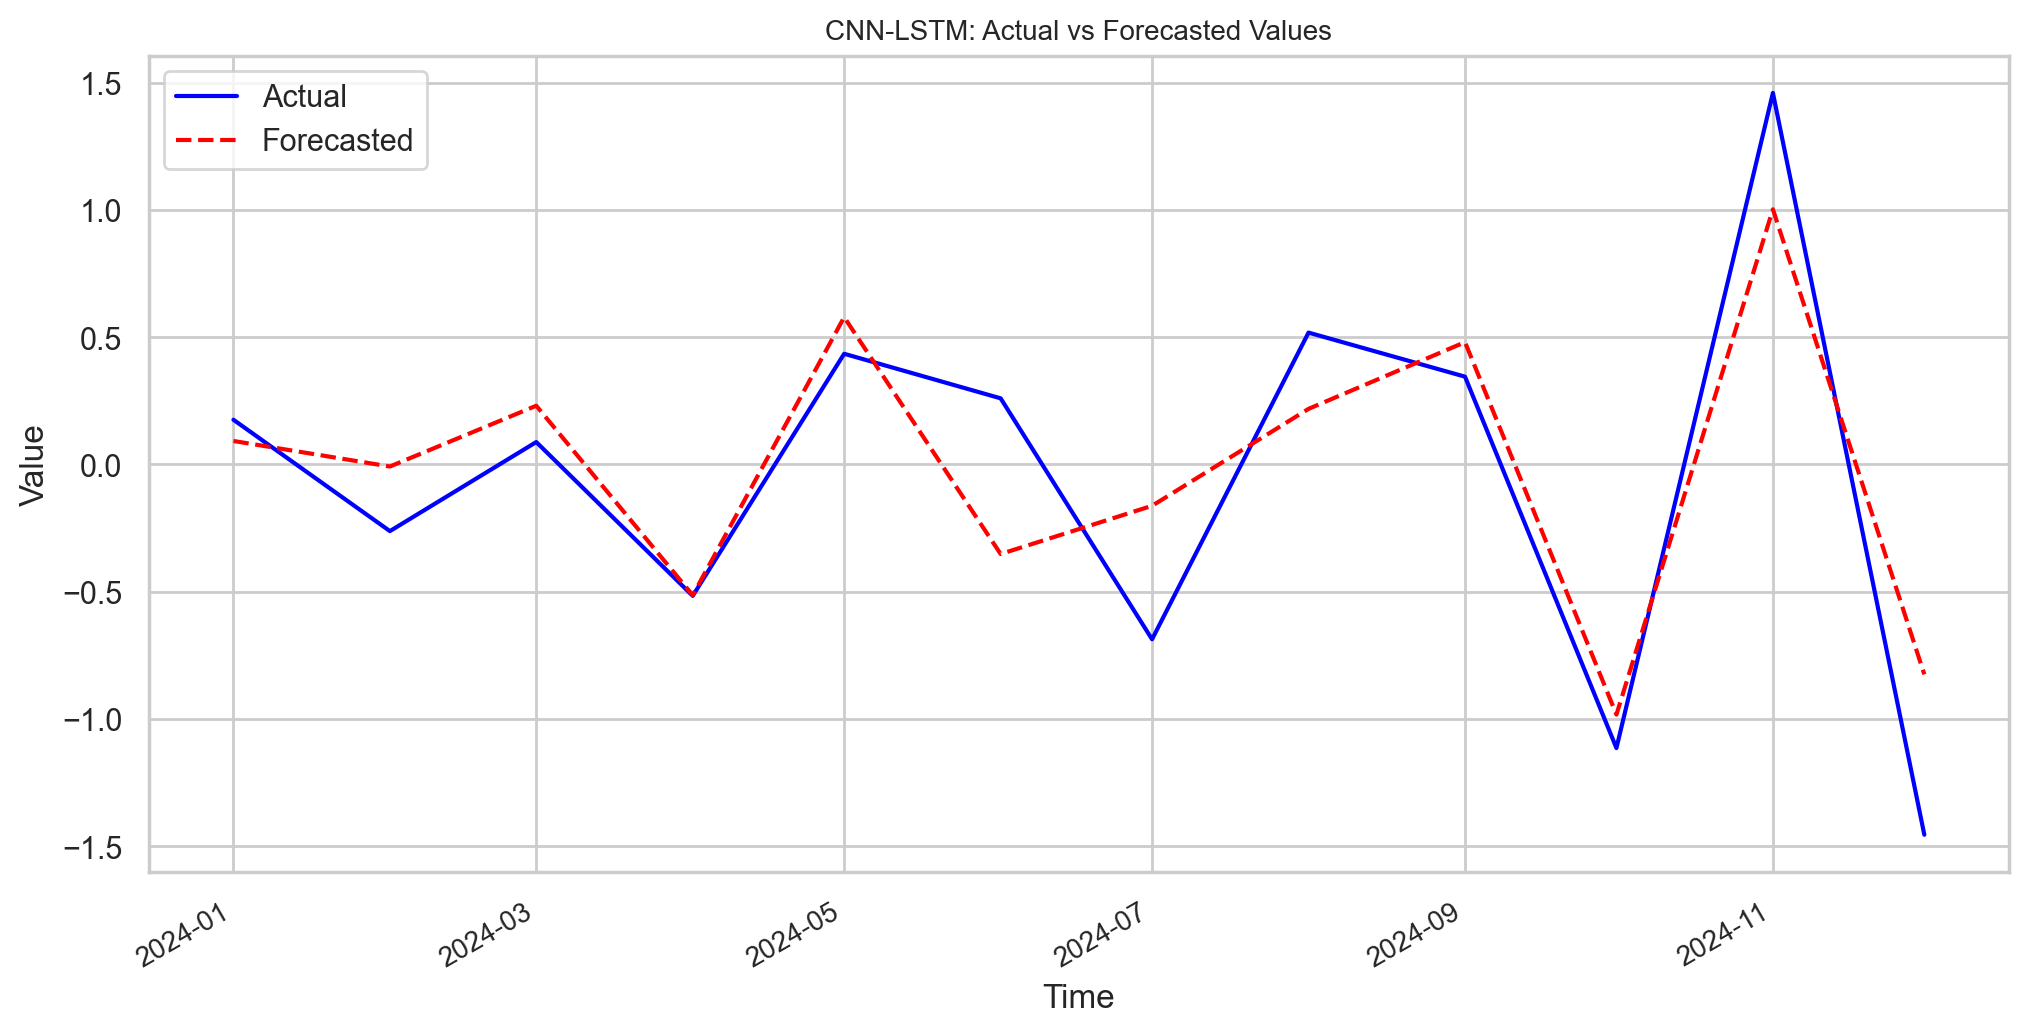

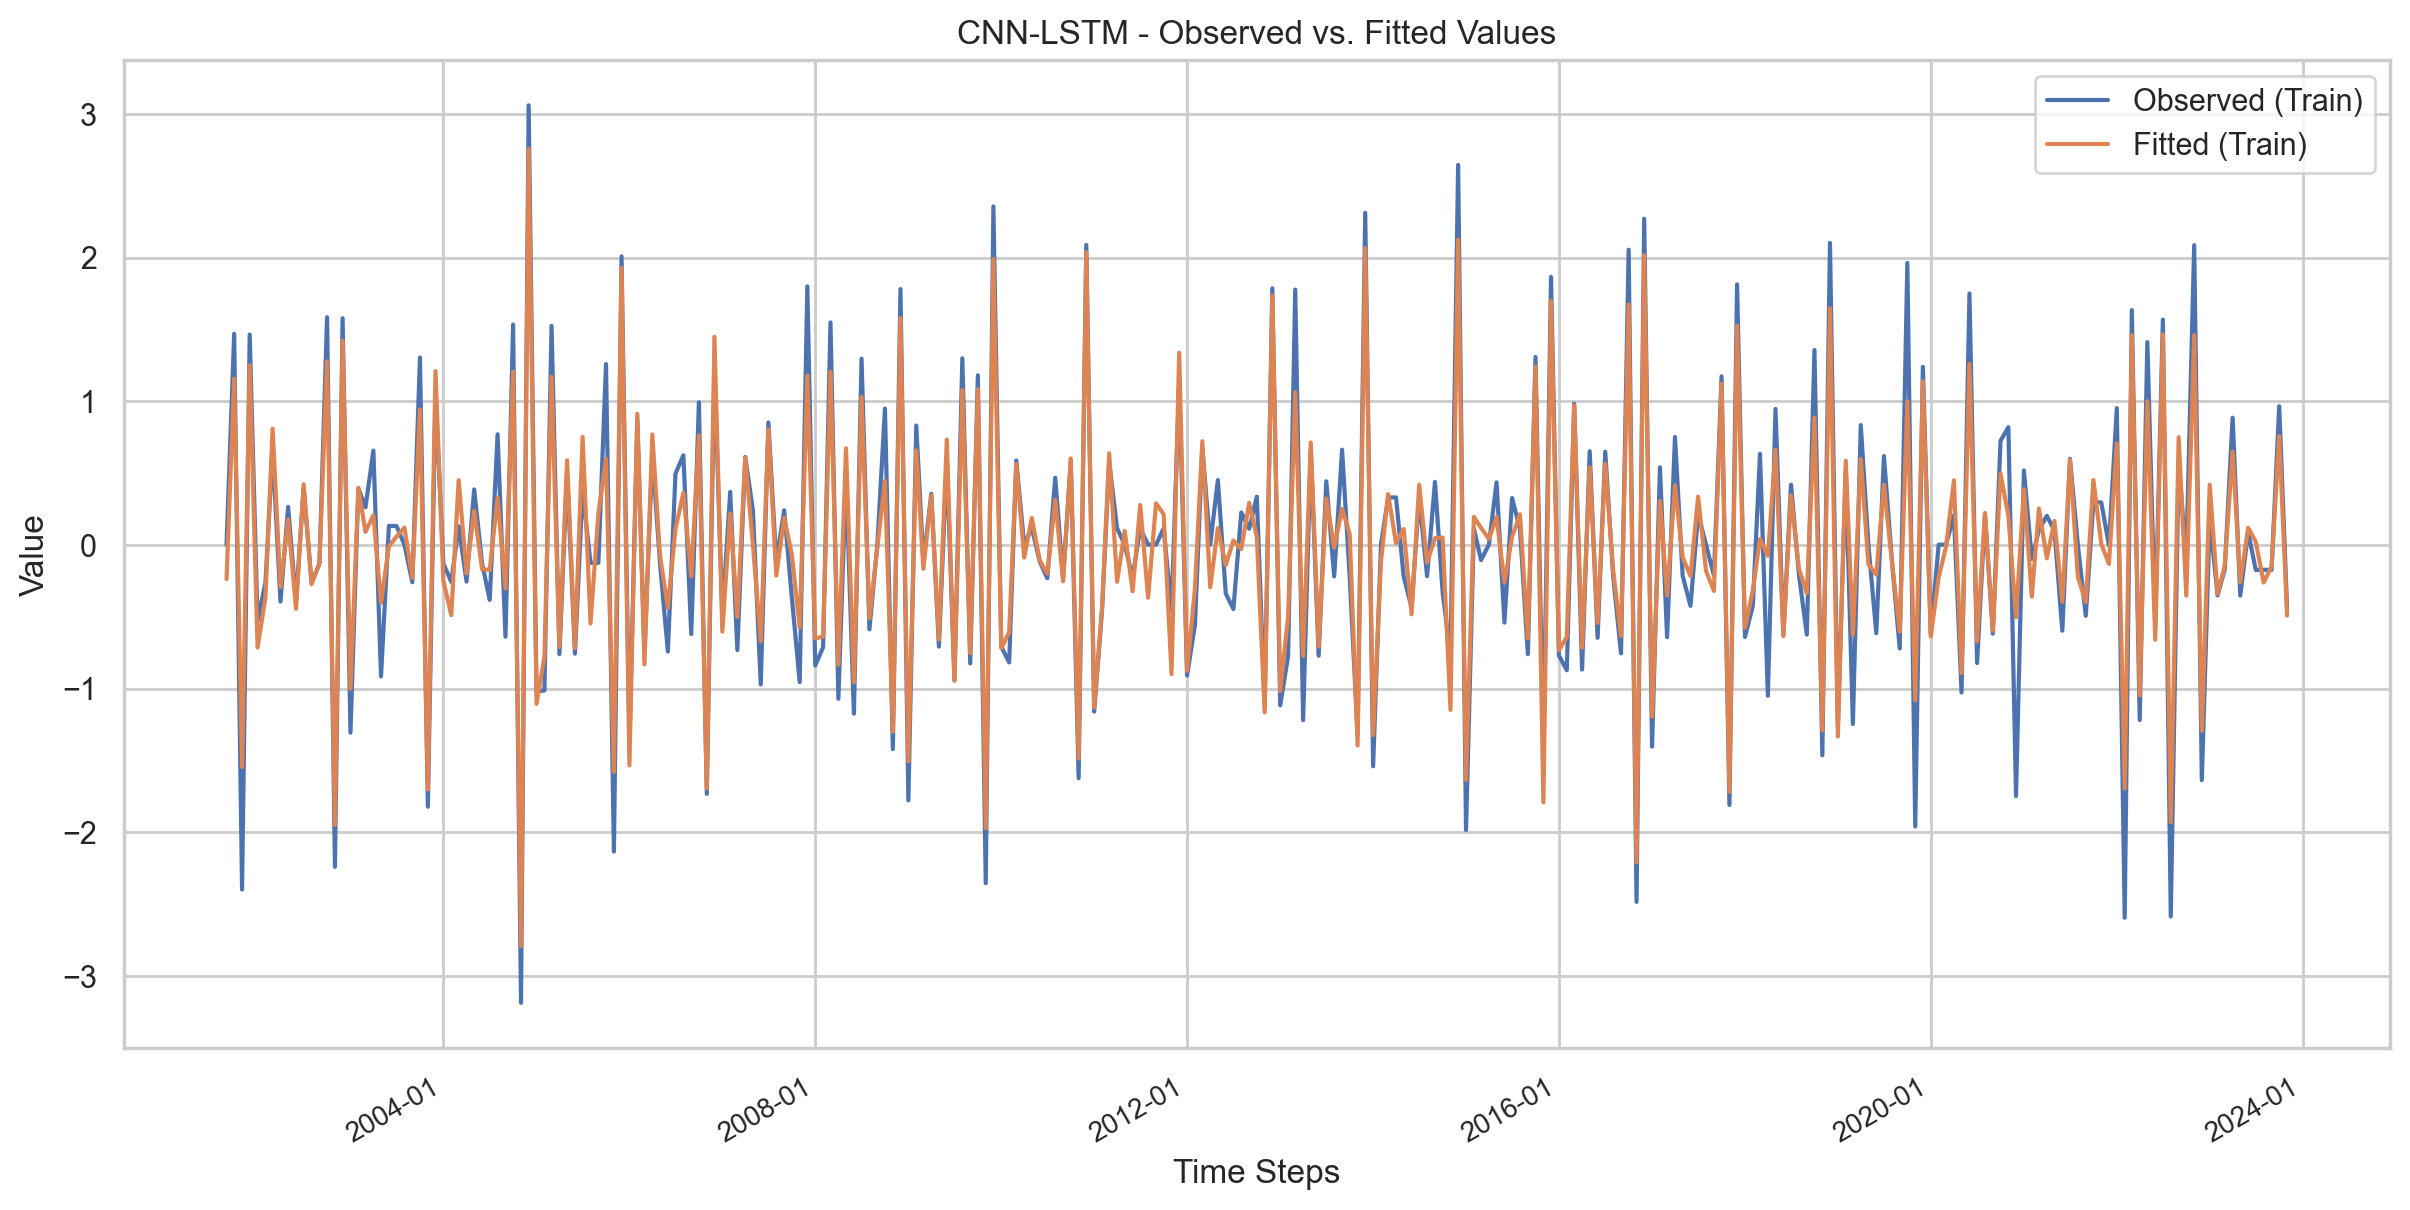

In [27]:
df_time = add_time_features(df_nfe)
model_C1D_time, X_train_C1D_time, X_test_C1D_time, mae_C1D_time, rmse_C1D_time, fnames_C1D_time = conv1D(df_time,target, test_size, 30)

3 CNN-LSTM 1D NFE Model + 12 step look back

Mean Absolute Error (MAE): 0.35456057
Root Mean Squared Error (RMSE): 0.42271043


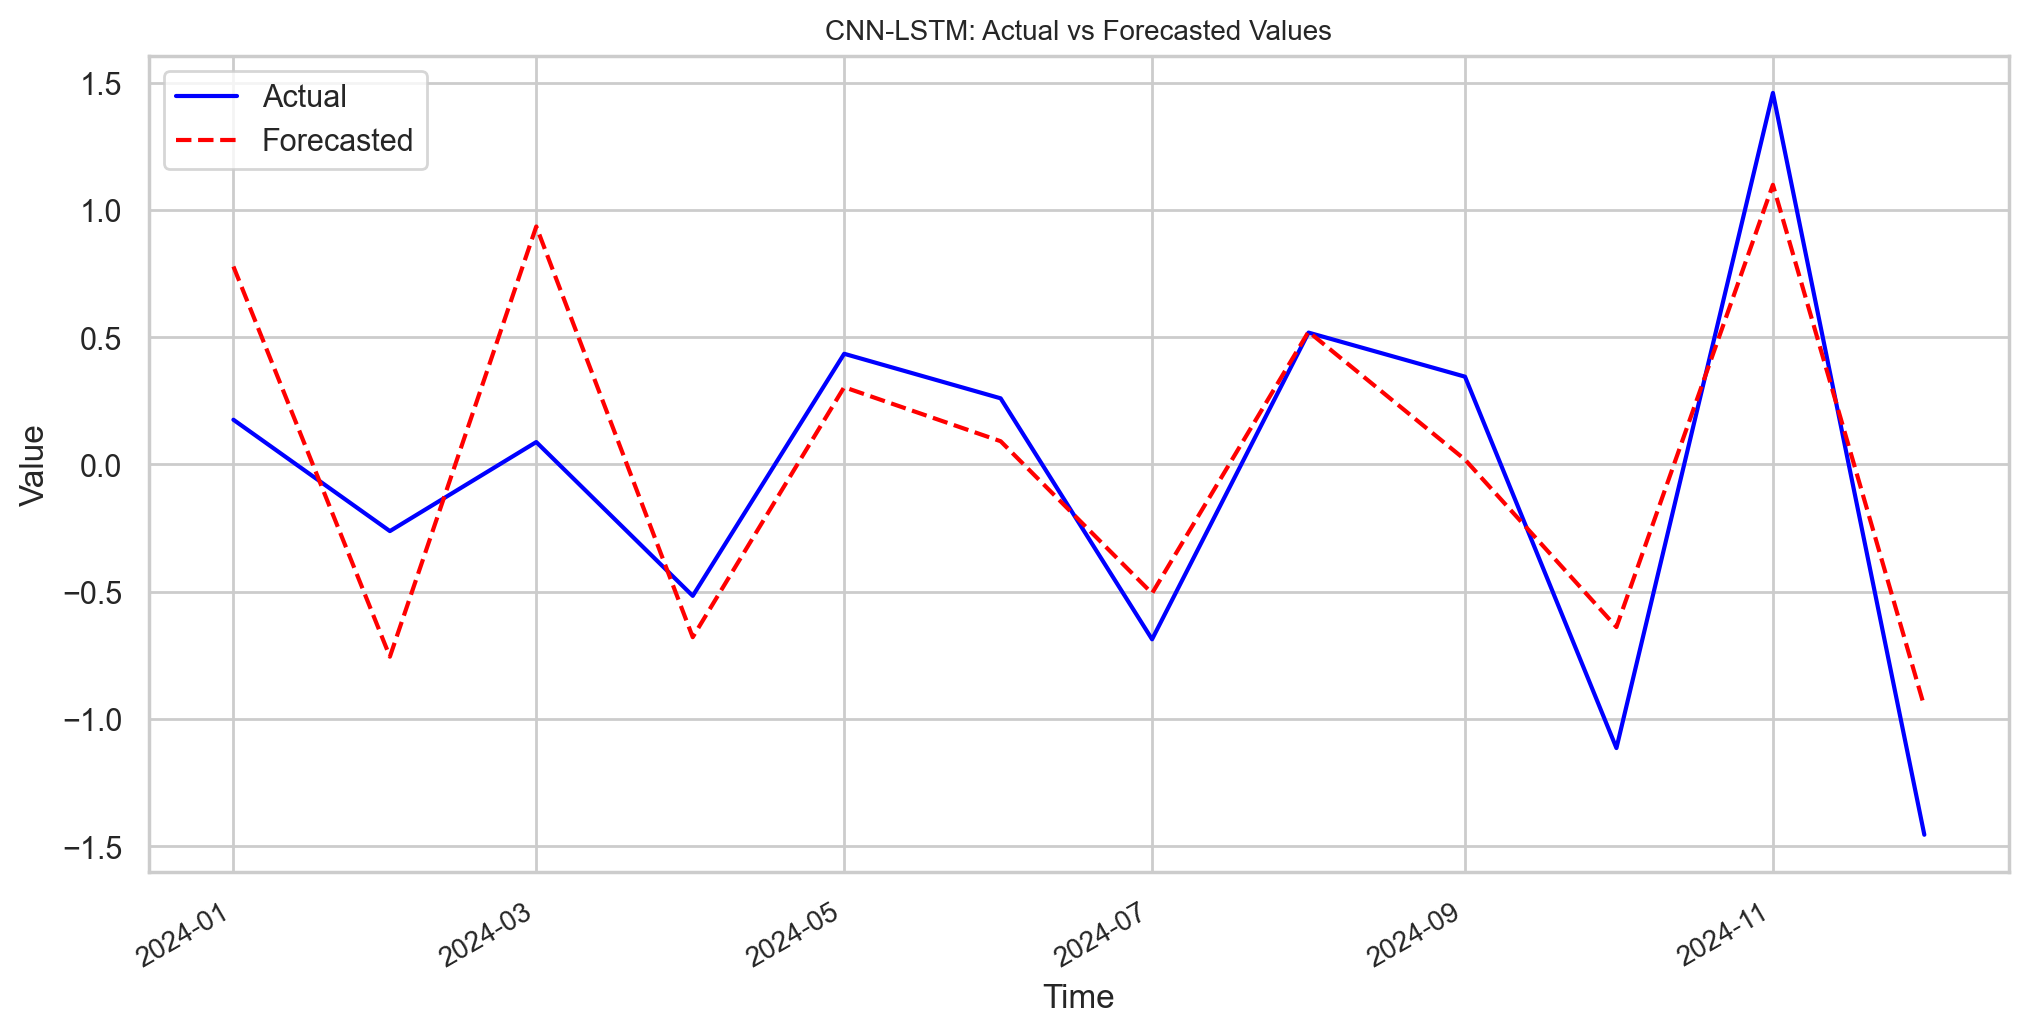

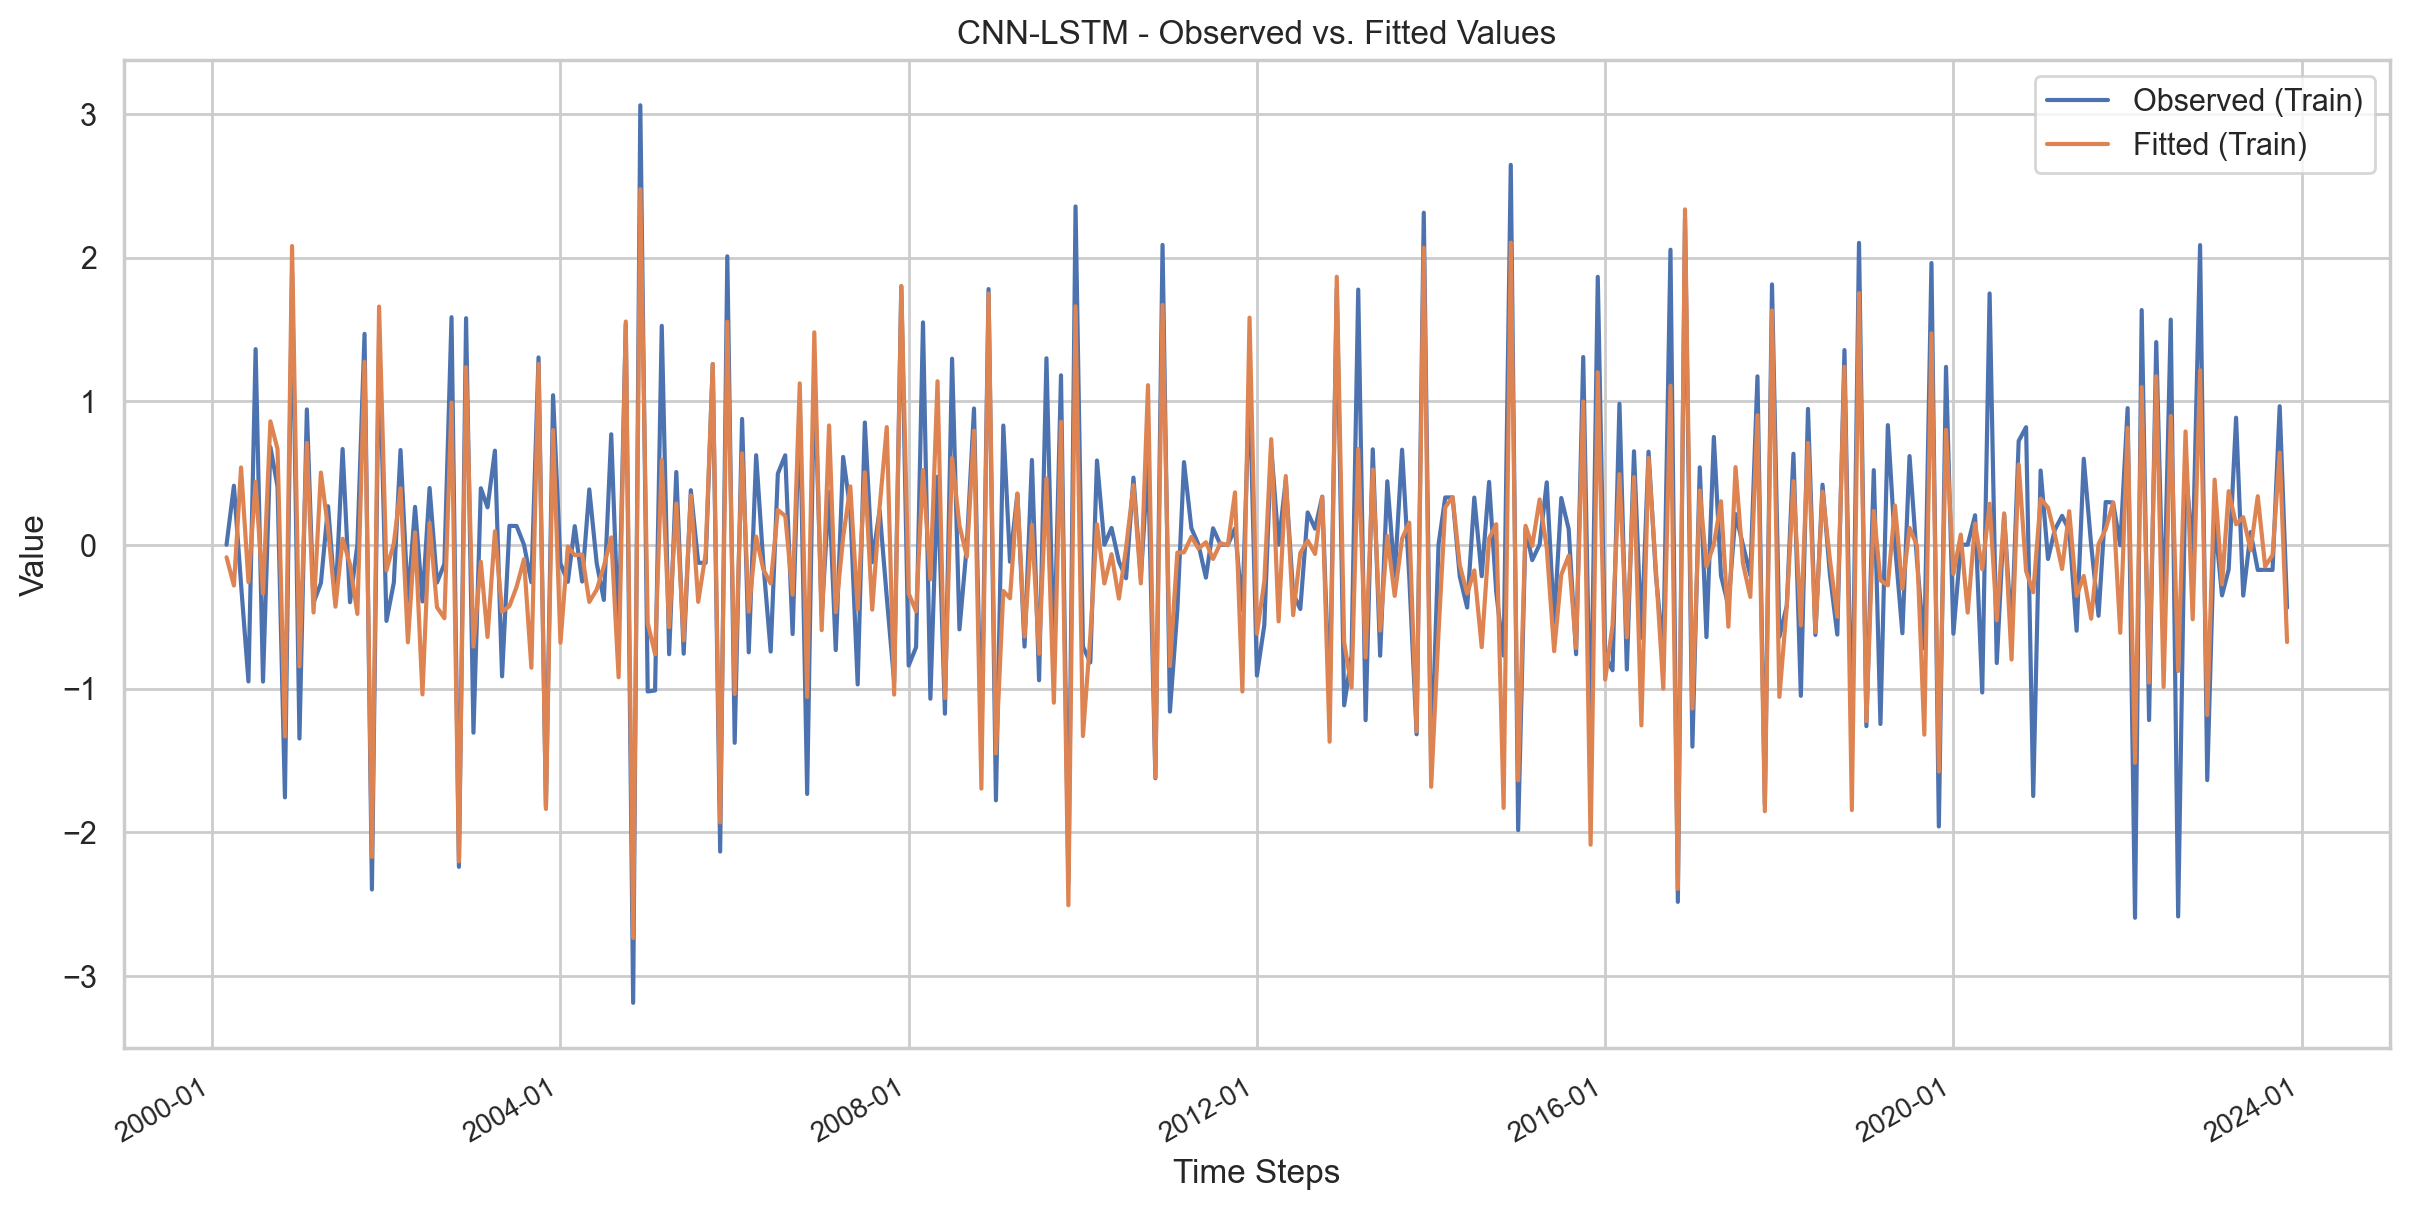

In [28]:
model_CL1D_nfe, X_train_CL1D_nfe, X_test_CL1D_nfe, mae_CL1D_nfe, rmse_CL1D_nfe, fnames_CL1D_nfe = convlstm1D(df_nfe, target, test_size, 12)

4 CNN-LSTM Model + Time Engineering + 30 step look back (ACF/PACF guided)

Mean Absolute Error (MAE): 0.15944326
Root Mean Squared Error (RMSE): 0.18229324


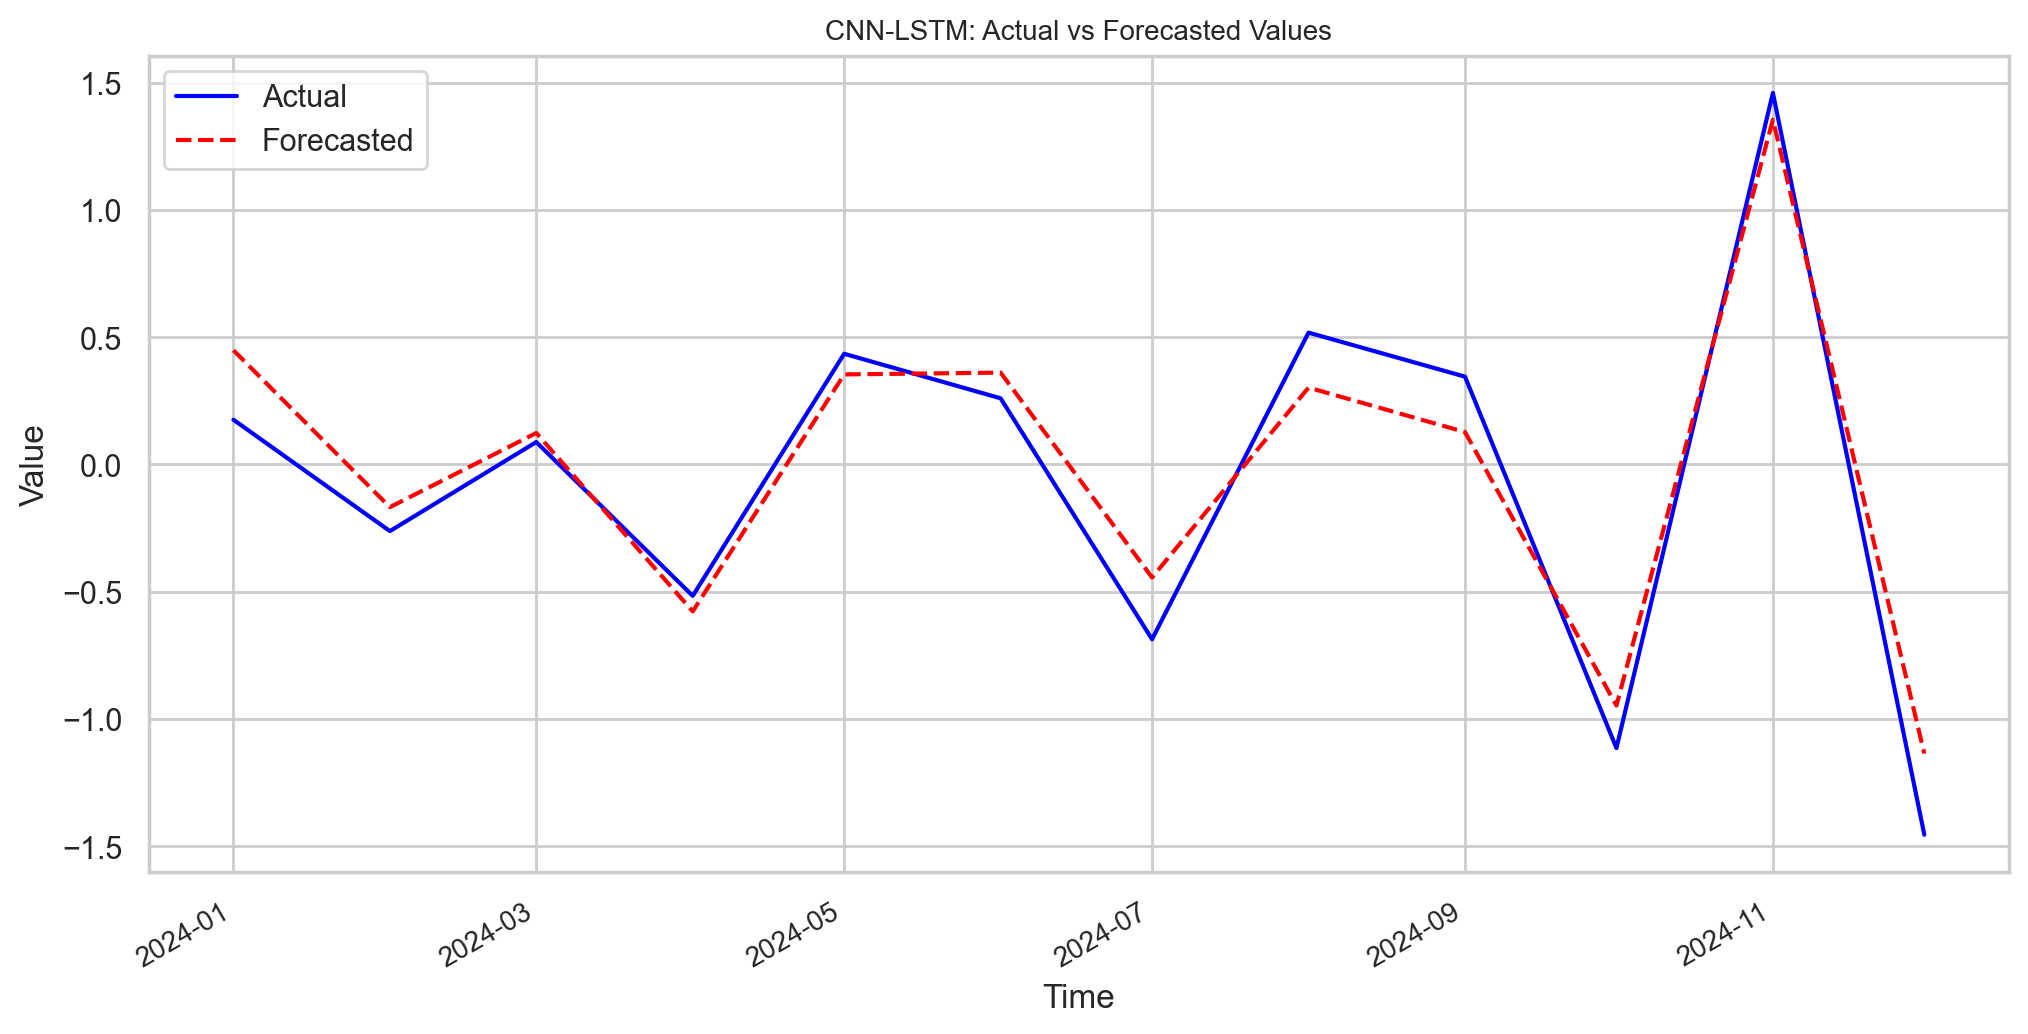

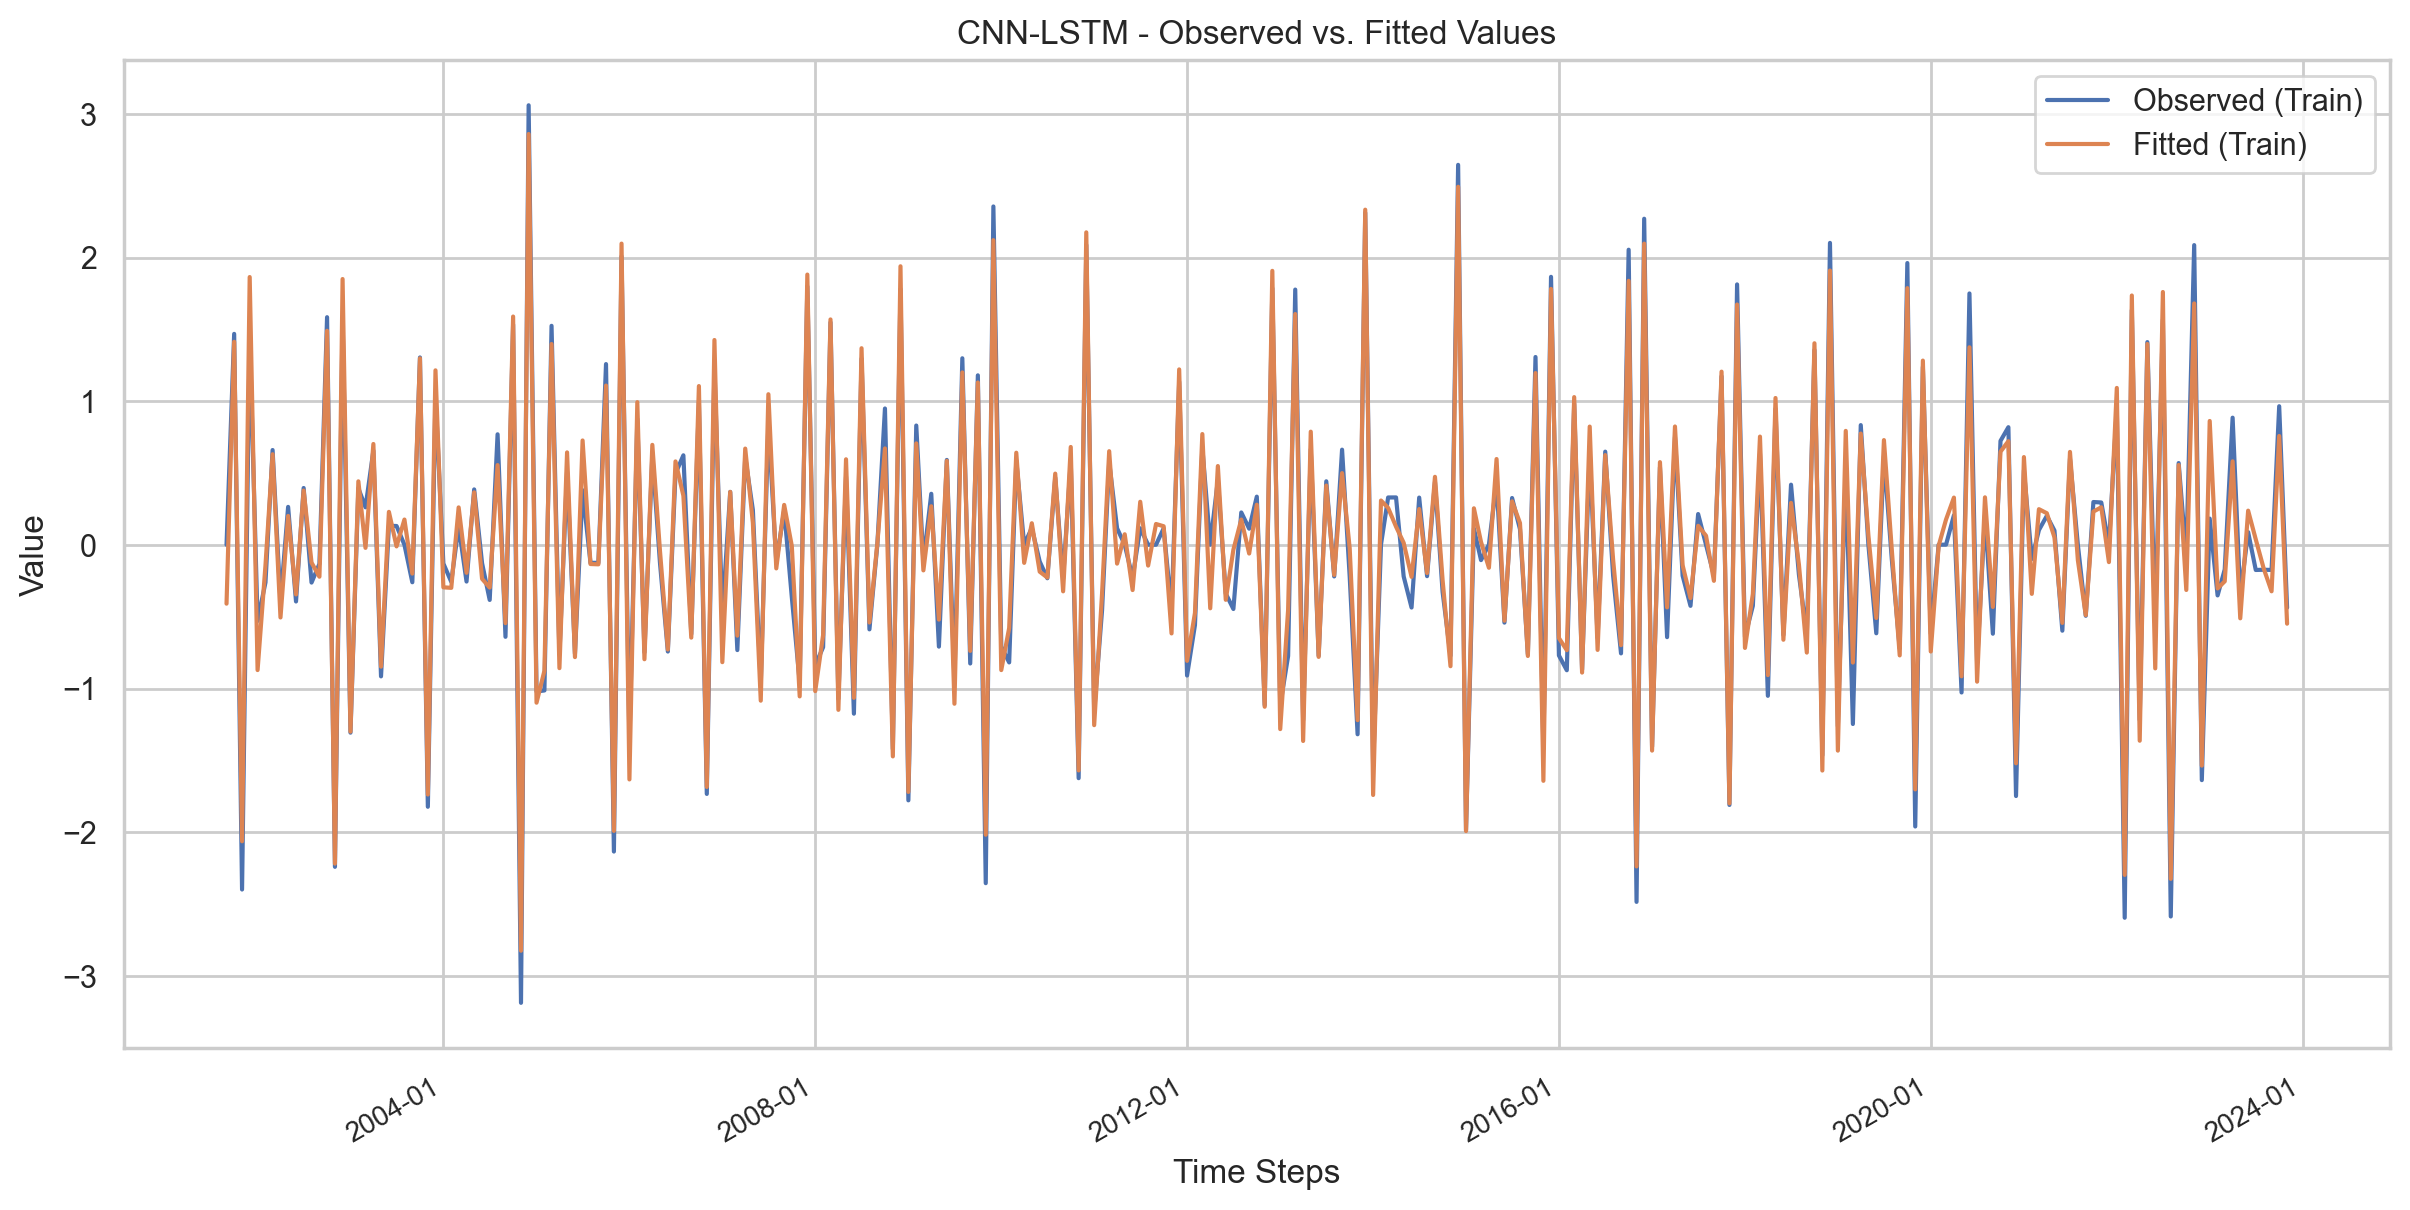

In [29]:
model_CL1D_time, X_train_CL1D_time, X_test_CL1D_time, mae_CL1D_time, rmse_CL1D_time, fnames_CL1D_time = convlstm1D(df_time, target, test_size, 30)

5. CNN-LSTM Model VAE + 12 Step look back

In [30]:
df_vae = df[vae_cpi_cols]

Mean Absolute Error (MAE): 0.71818675
Root Mean Squared Error (RMSE): 0.92240575


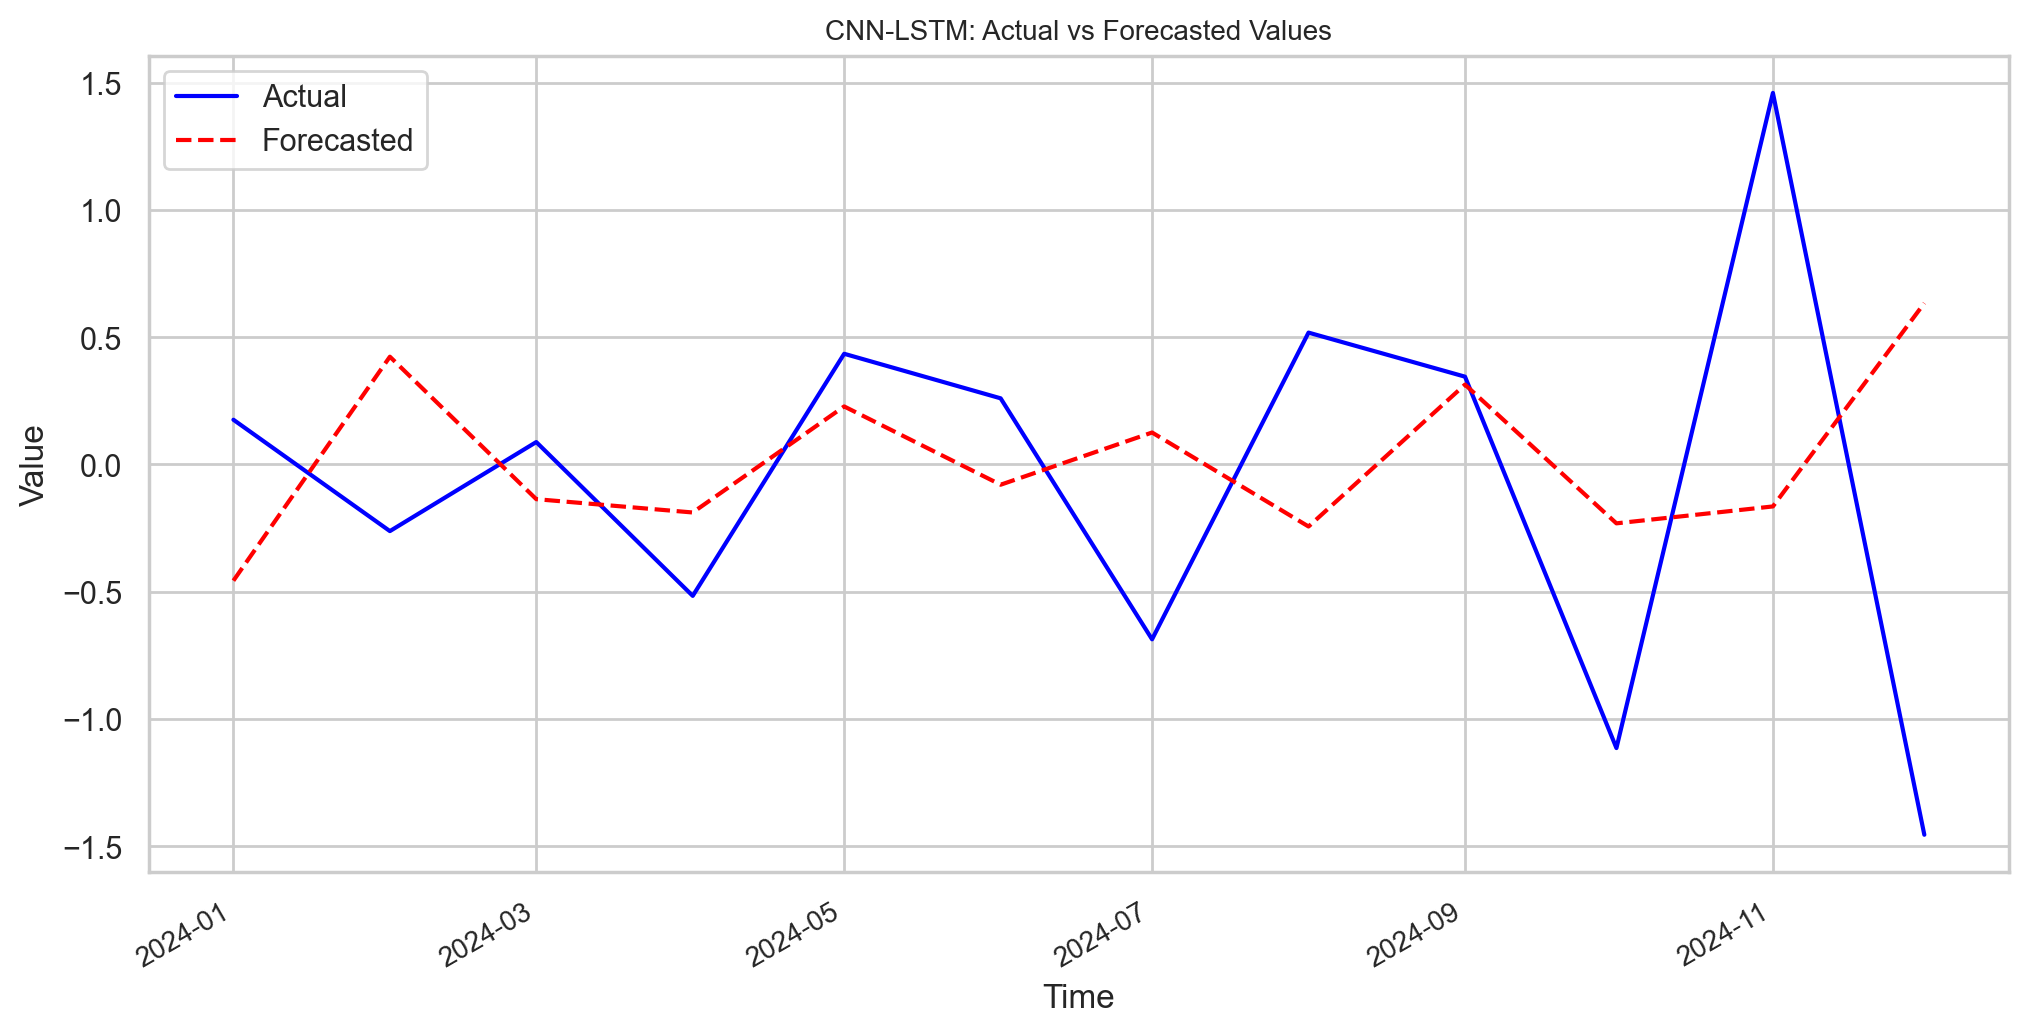

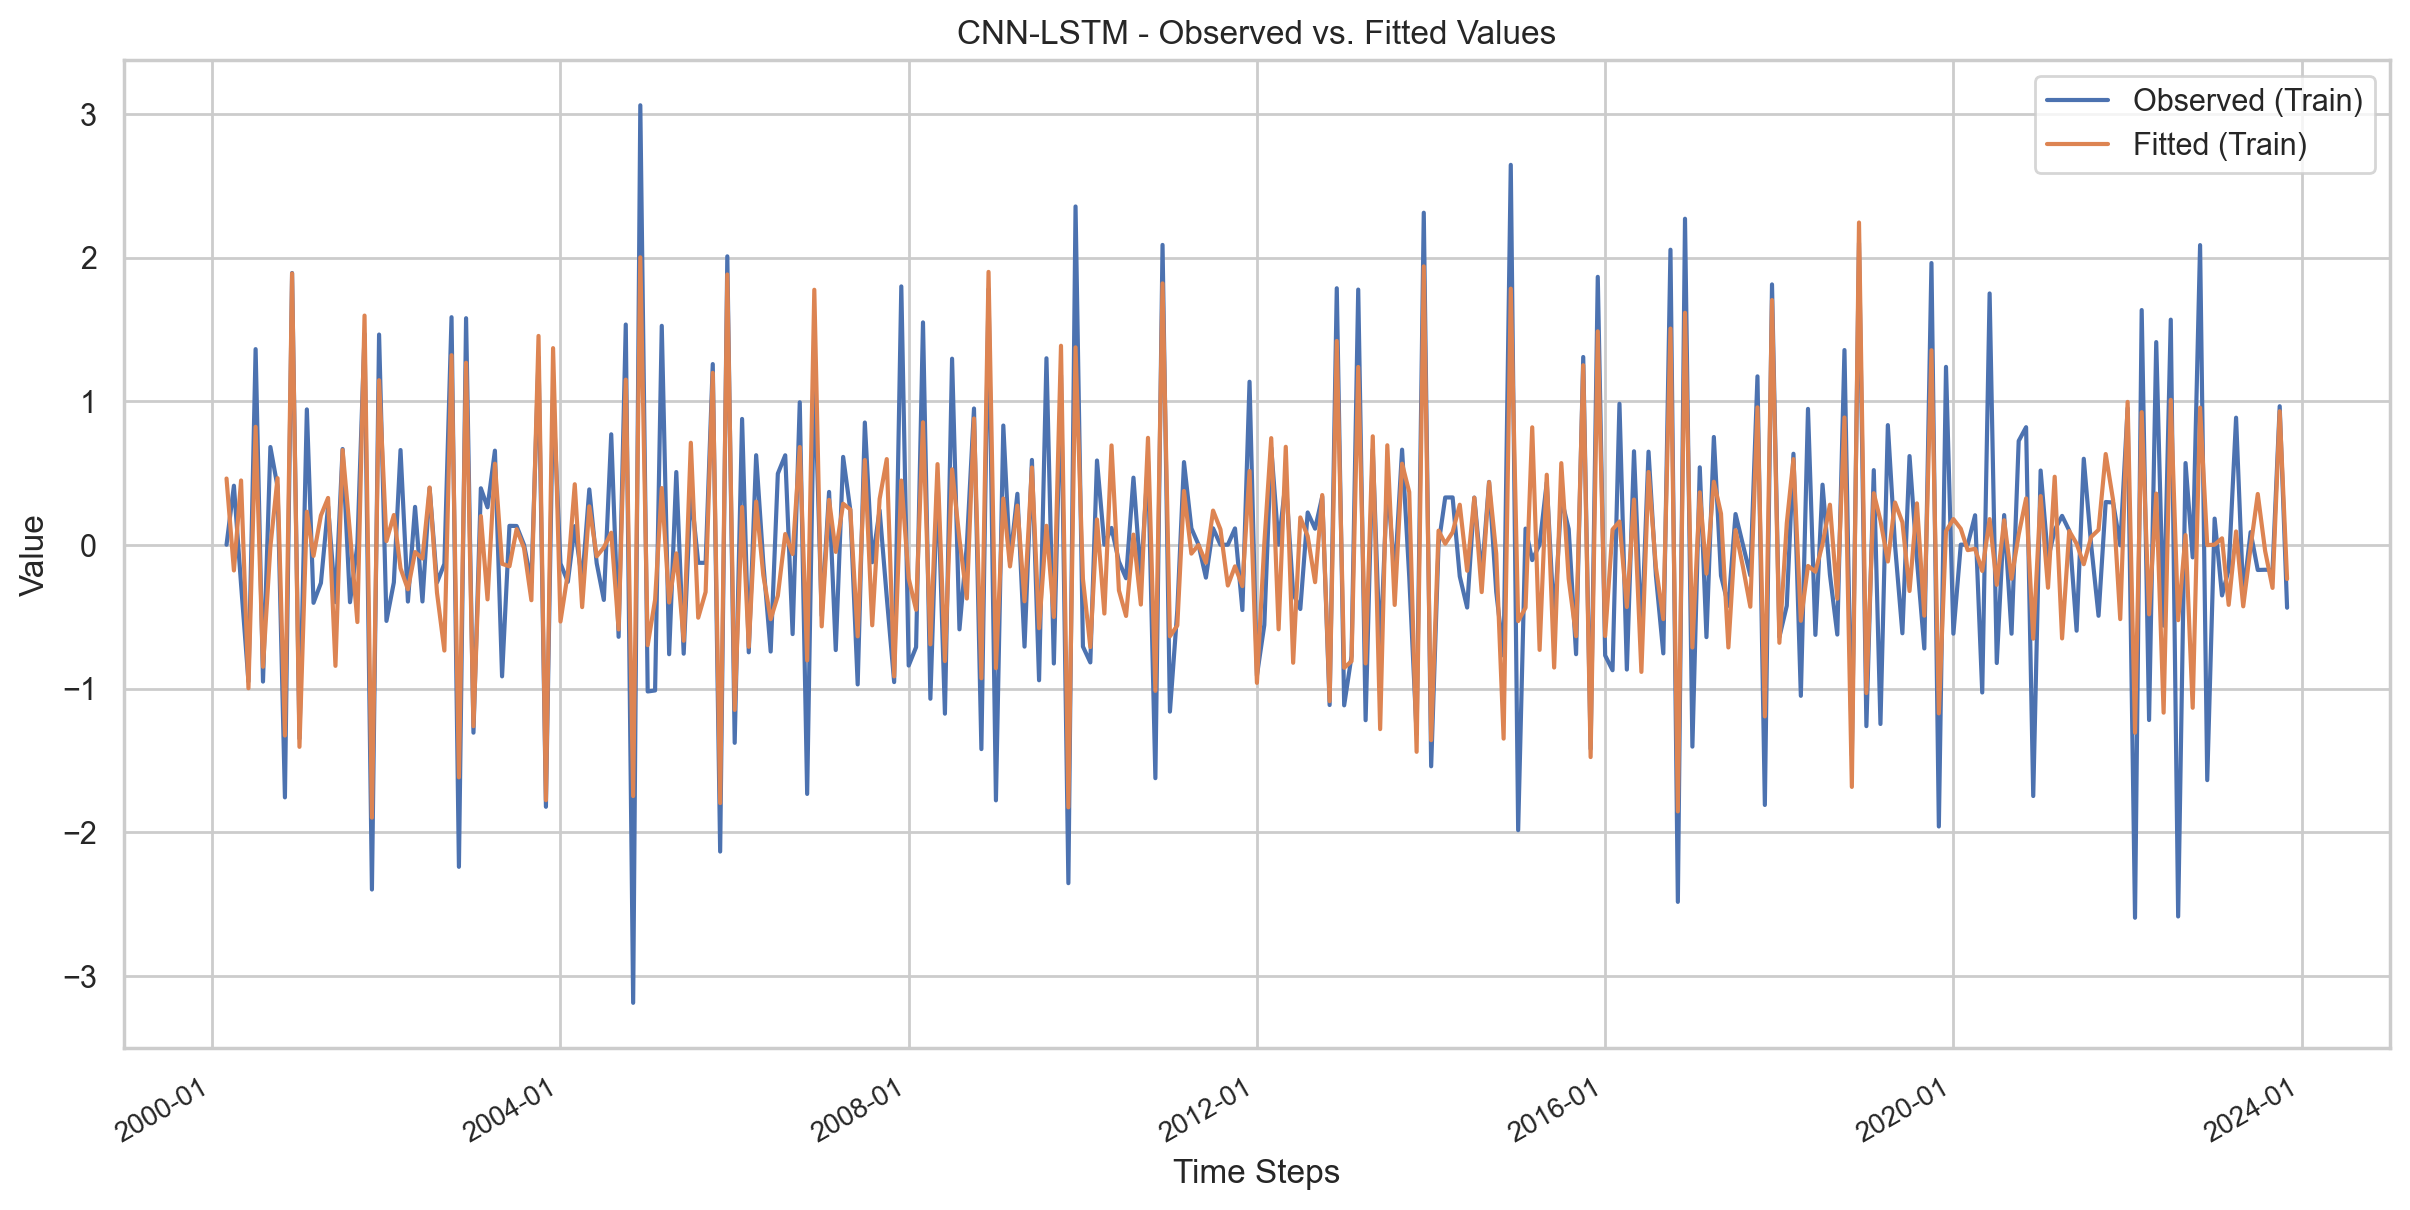

In [31]:
model_CL1D_vae, X_train_CL1D_vae, X_test_CL1D_vae, mae_CL1D_vae, rmse_CL1D_vae, fnames_CL1D_vae = convlstm1D(df_vae, target, test_size, 12)

6. CNN-LSTM Model VAE + Time Engineering + 30 step look back (ACF/PACF Guided)

Mean Absolute Error (MAE): 0.35731547
Root Mean Squared Error (RMSE): 0.47510991


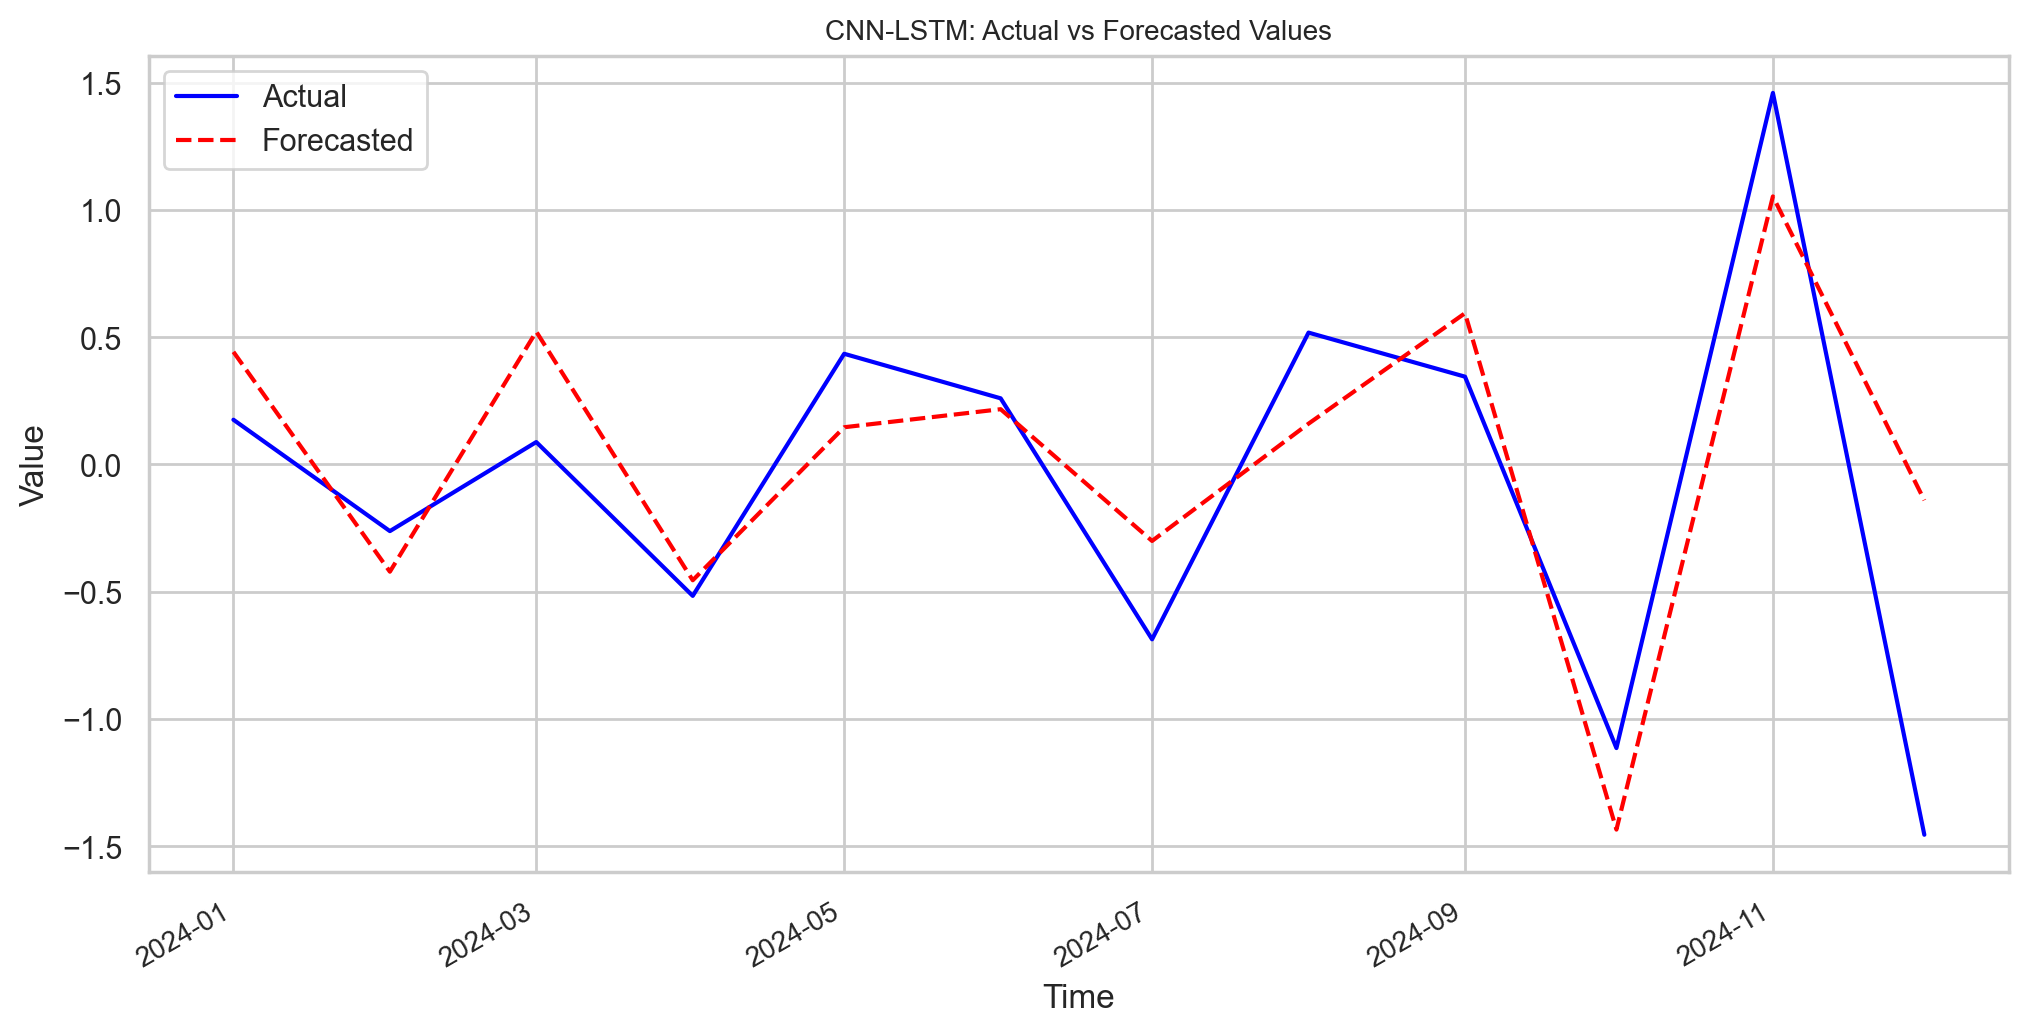

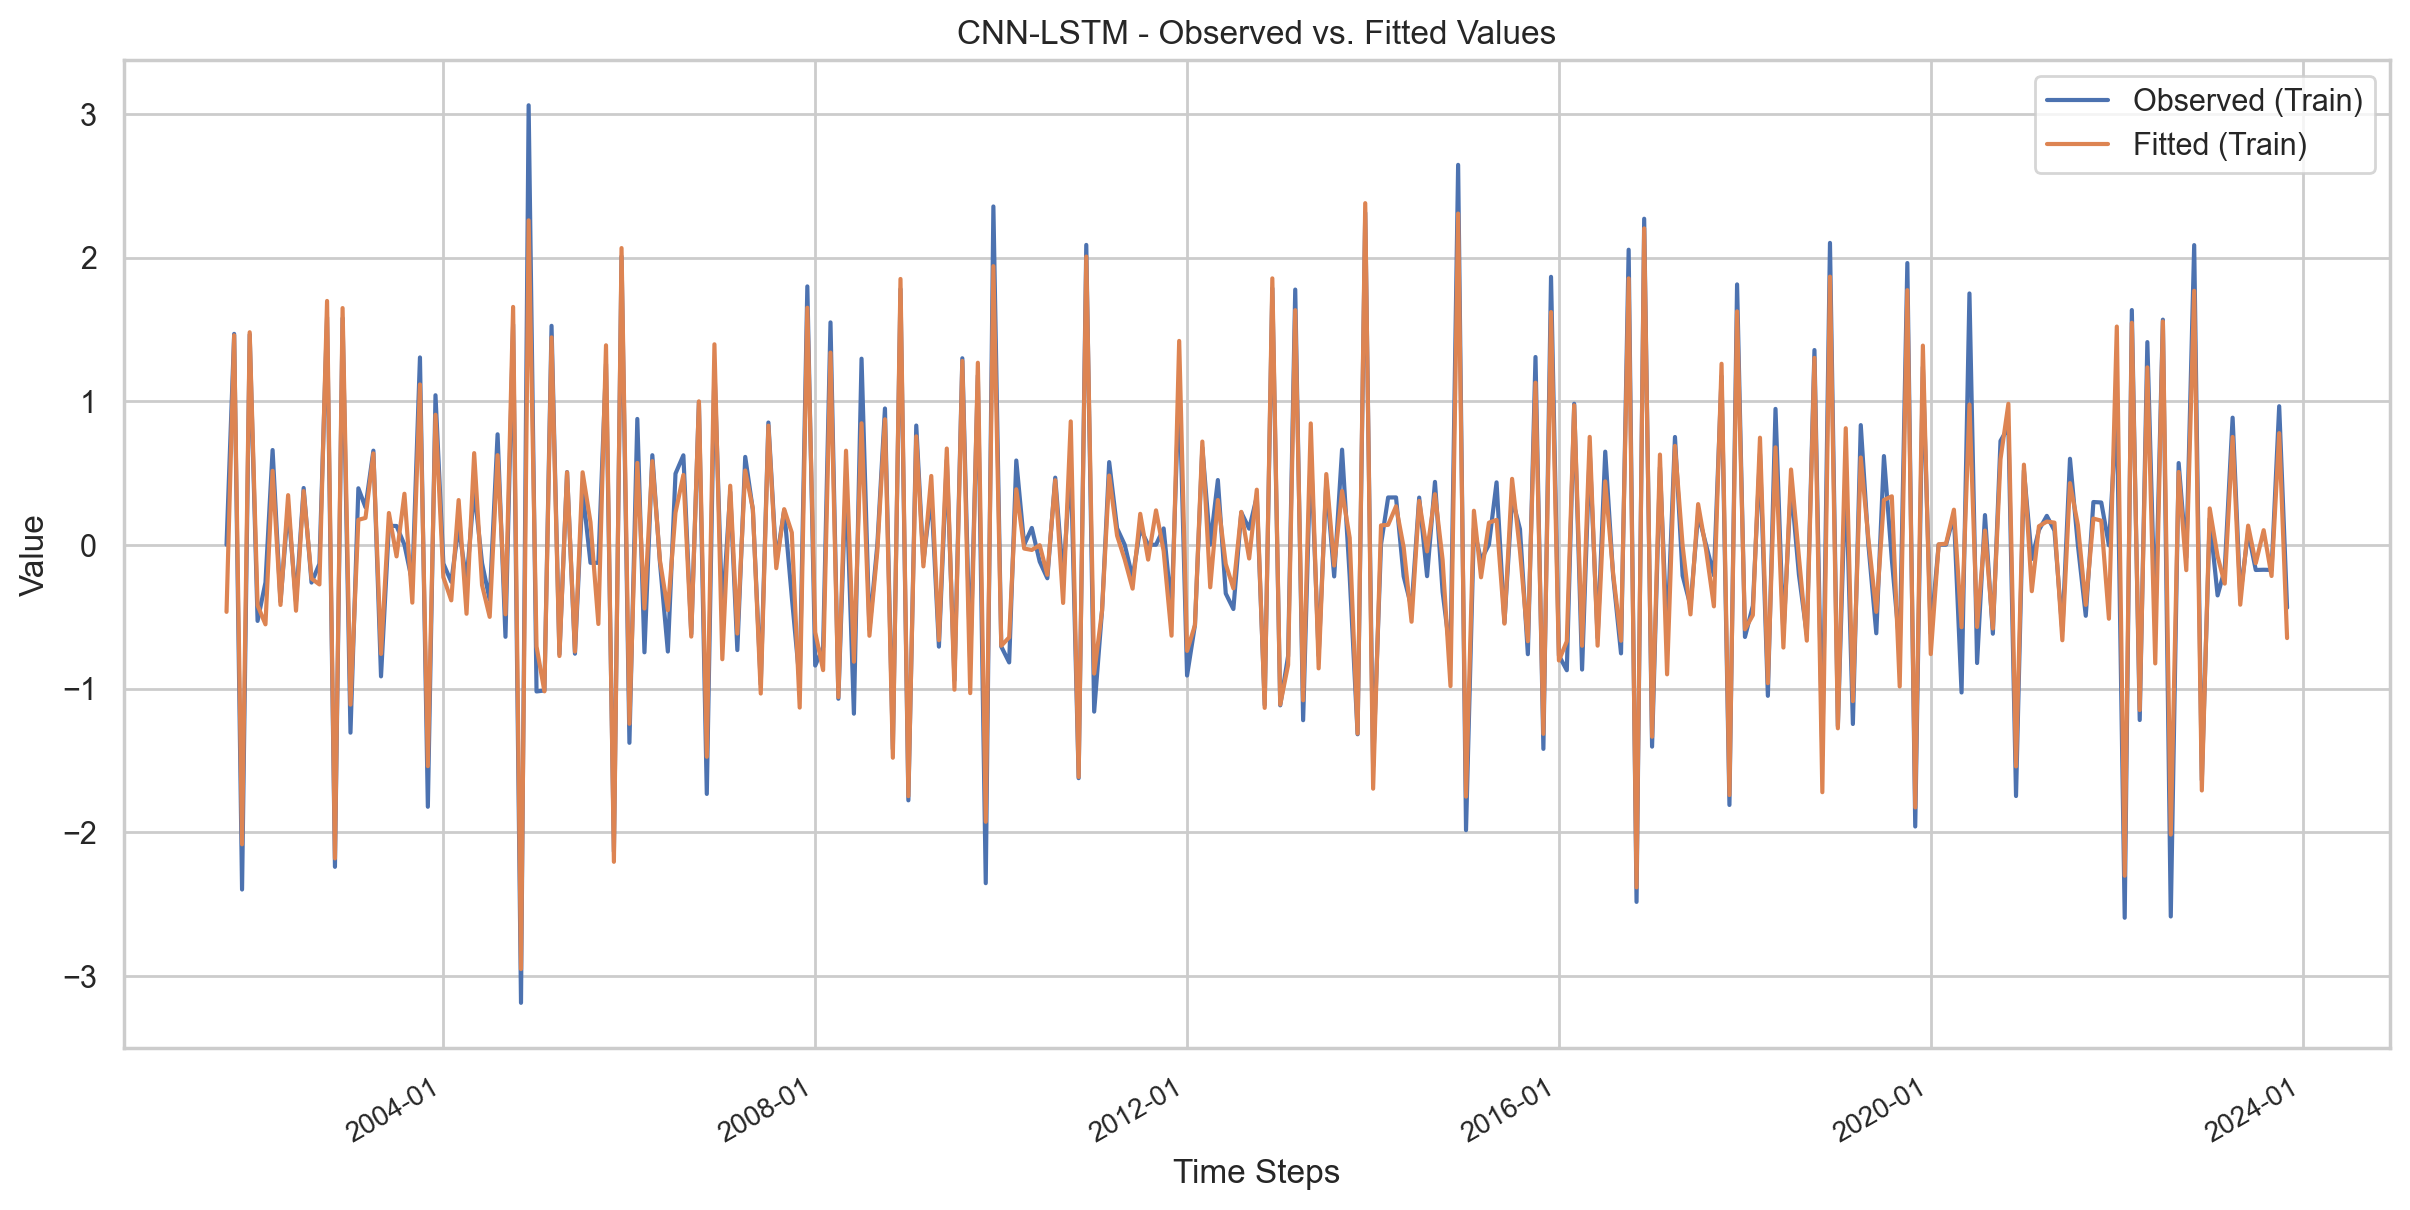

In [32]:
df_vae_time = add_time_features(df_vae)
model_CL1D_vae_time, X_train_CL1D_vae_time, X_test_CL1D_vae_time, mae_CL1D_vae_time, rmse_CL1D_vae_time, fnames_CL1D_vae_time = convlstm1D(df_vae_time, target, test_size, 30)

7. CNN-LSTM 2D + NFE + 12 Steps


Mean Absolute Error (MAE): 0.68257937
Root Mean Squared Error (RMSE): 0.79202318


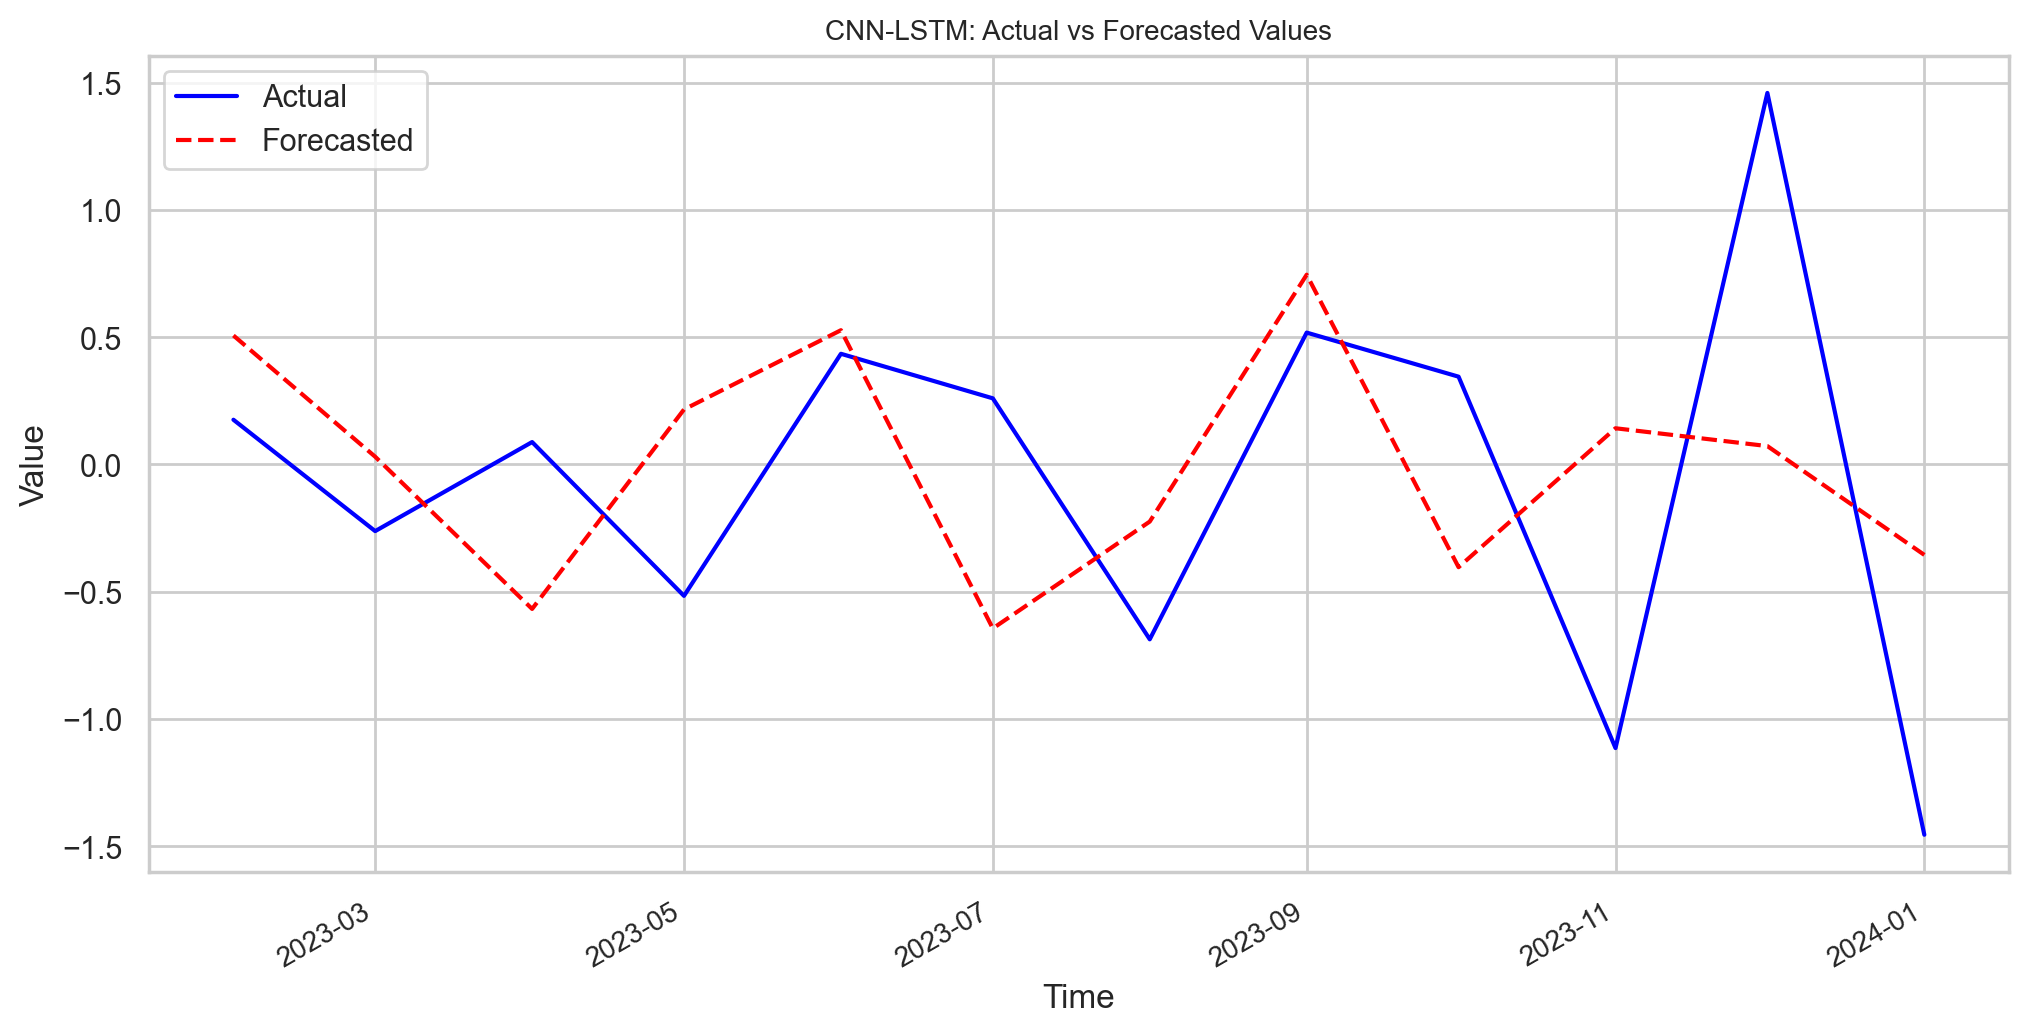

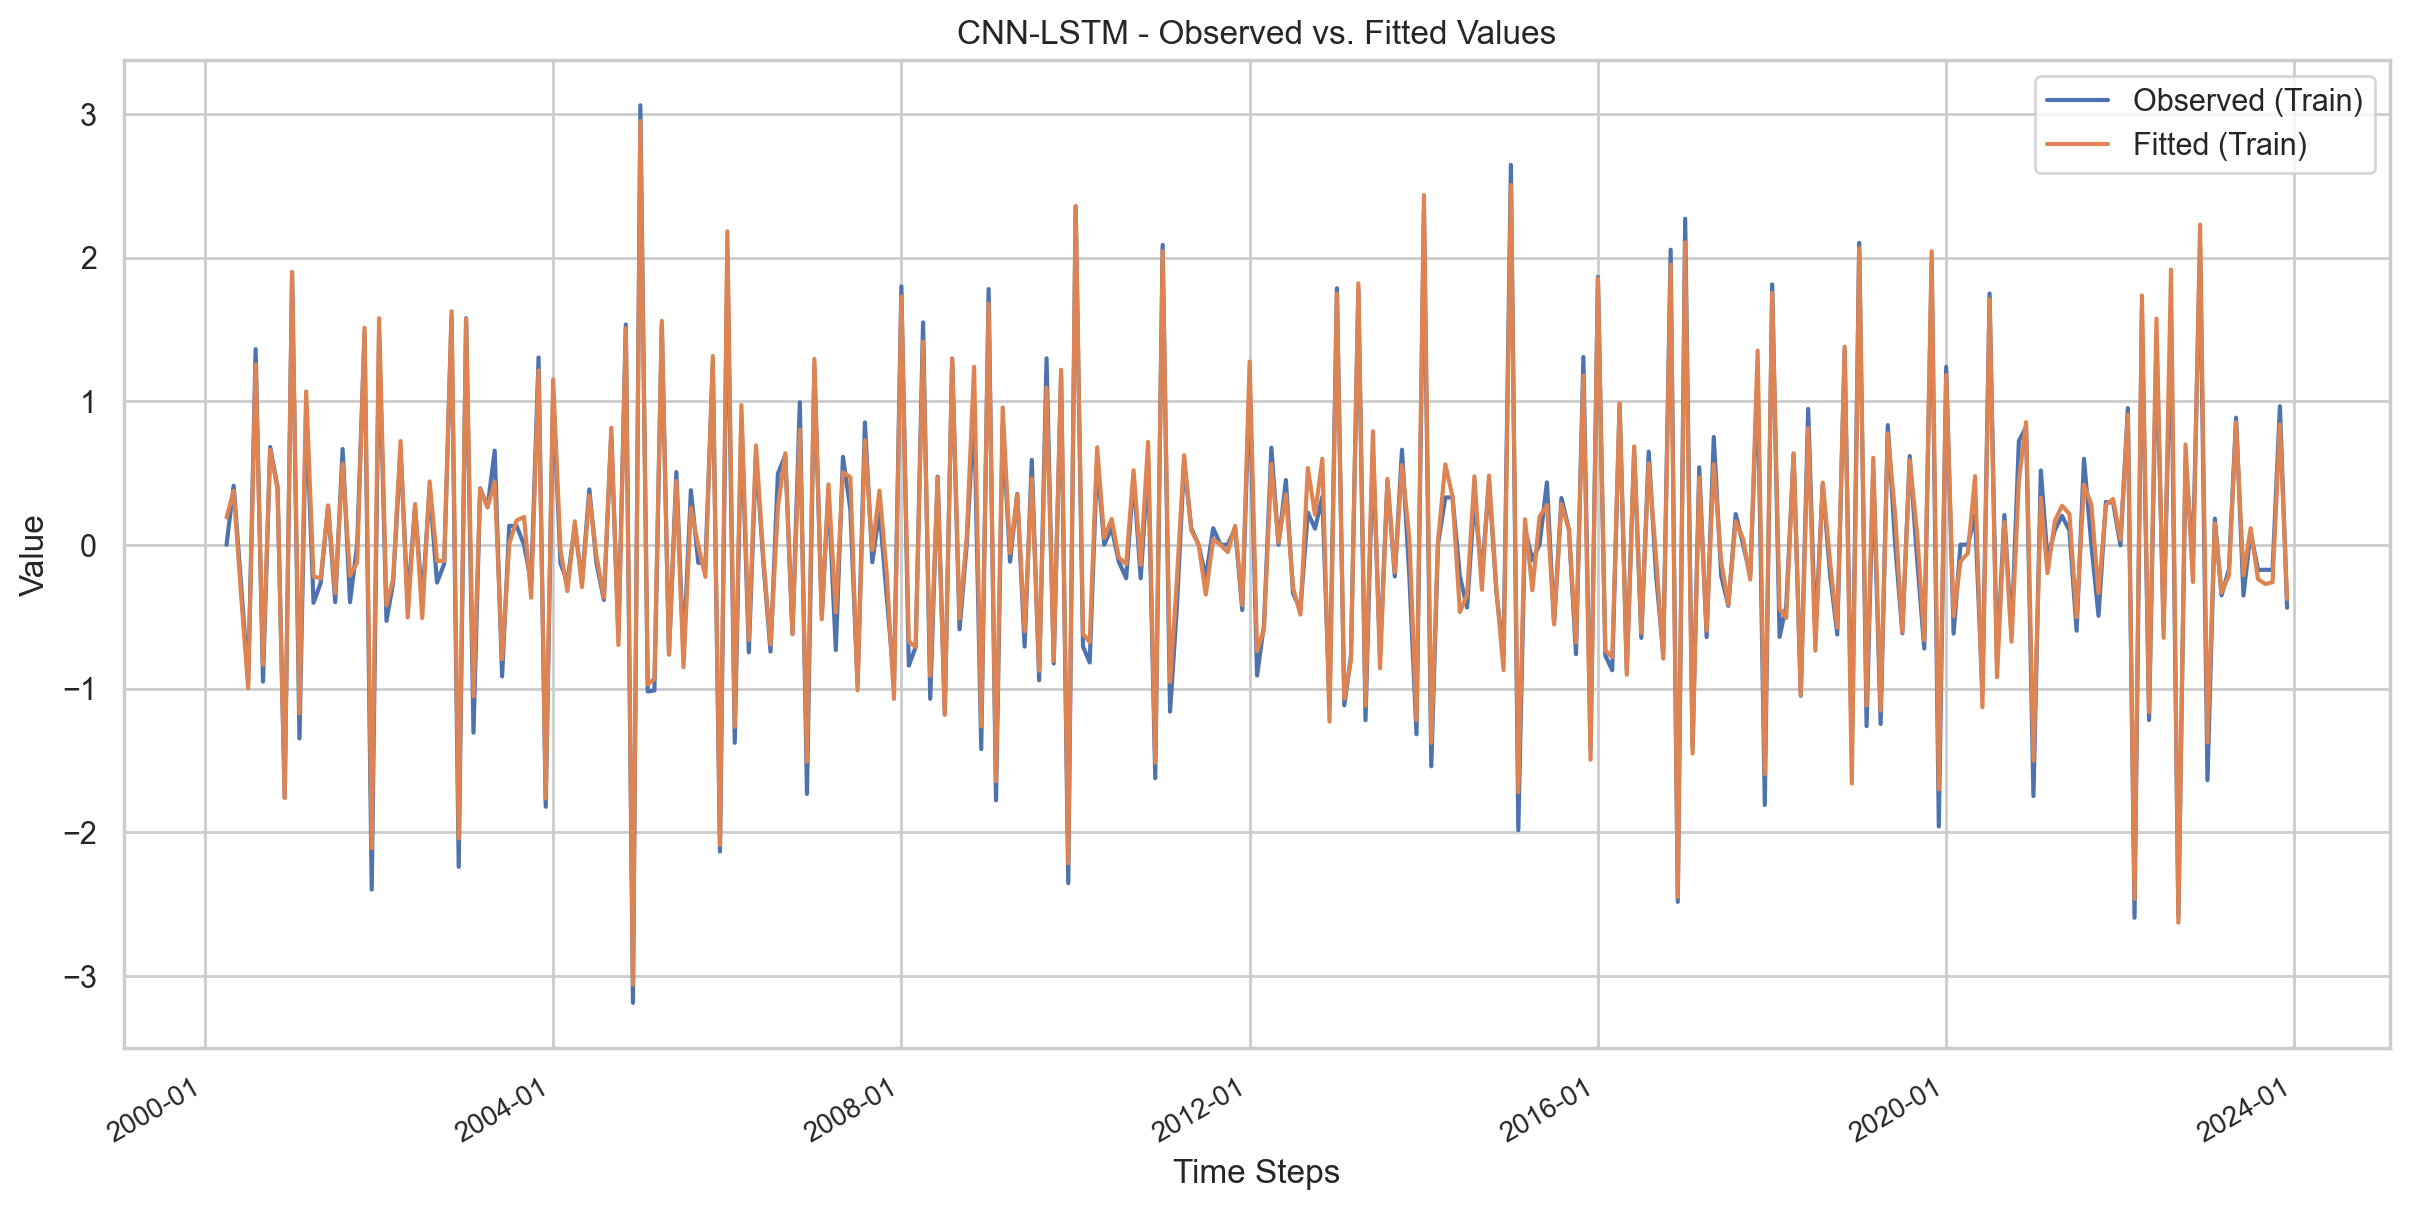

In [33]:
model_CL2D_nfe, X_train_CL2D_nfe, X_test_CL2D_nfe, mae_CL2D_nfe, rmse_CL2D_nfe, fnames_CL2D_nfe = convlstm2D(df_nfe, target, test_size, 12)

In [34]:

print(f"1. Base CNN Model NFE + 12 step look back MAE: {mae_C1D_nfe:.4f}")
print(f"2. Base CNN Model + Time Engineering + 30 step look back MAE: {mae_C1D_time:.4f}")
print(f"3. CNN-LSTM Model NFE + 12 step look back MAE: {mae_CL1D_nfe:.4f}")
print(f"4. CNN-LSTM Model + Time Engineering + 30 step look back MAE: {mae_CL1D_time:.4f}")
print(f"5. CNN-LSTM Model VAE + 12 step look back MAE: {mae_CL1D_vae:.4f}")
print(f"6. CNN-LSTM Model VAE + Time Engineering + 30 step look back MAE: {mae_CL1D_vae_time:.4f}")
print(f"7. CNN-LSTM 2D NFE + 12 step look back MAE: {mae_CL2D_nfe:.4f}")
print(f'8. VAR (MAE): {var_mae}')
print(f'9. ARIMA (MAE): {arima_mae}')
print(f'10. SARIMA (MAE): {sarima_mae}')

1. Base CNN Model NFE + 12 step look back MAE: 0.3135
2. Base CNN Model + Time Engineering + 30 step look back MAE: 0.2847
3. CNN-LSTM Model NFE + 12 step look back MAE: 0.3546
4. CNN-LSTM Model + Time Engineering + 30 step look back MAE: 0.1594
5. CNN-LSTM Model VAE + 12 step look back MAE: 0.7182
6. CNN-LSTM Model VAE + Time Engineering + 30 step look back MAE: 0.3573
7. CNN-LSTM 2D NFE + 12 step look back MAE: 0.6826
8. VAR (MAE): 0.5880361664859162
9. ARIMA (MAE): 0.6431854693794415
10. SARIMA (MAE): 0.5533733717721651


# SHAP Value Estimation for CNN-LSTM Model

In [35]:

def get_model_input_shape(model):
    """Return the input shape of the first layer (excluding batch size)."""
    return model.input_shape[1:]

def create_model_predict_fn(model, input_shape):
    """Wrapper to adapt SHAP 2D input back to model's expected input shape."""
    def model_predict(X_flat):
        X = X_flat.reshape((X_flat.shape[0], *input_shape))
        preds = model.predict(X, verbose=0) # This will have shape (num_samples, 12)
        return preds.sum(axis=1)
    return model_predict

def shappy(model, X_train, X_to_explain, feature_names):
    """
    Calculates SHAP values using a background distribution from the training set.
    """
    input_shape = get_model_input_shape(model)
    timesteps = input_shape[0]

    # --- Create a background dataset from X_train ---
    X_train_flat = X_train.reshape((X_train.shape[0], -1))

    num_background_samples = min(100, X_train.shape[0])
    background_data = shap.kmeans(X_train_flat, num_background_samples)

    # --- Prepare the data we want to explain ---
    num_samples_to_explain = X_to_explain.shape[0]
    X_explain_flat = X_to_explain.reshape((num_samples_to_explain, -1))

    # Create repeated column names for the DataFrames
    repeated_feature_names = feature_names * timesteps
    X_explain_df = pd.DataFrame(X_explain_flat, columns=repeated_feature_names)
    background_df = pd.DataFrame(background_data.data, columns=repeated_feature_names)

    # --- Create the explainer using the background data ---
    model_predict = create_model_predict_fn(model, input_shape)
    explainer = shap.KernelExplainer(model_predict, background_df)

    # --- Calculate SHAP values for the instance(s) you want to explain ---
    print(f"Calculating SHAP values for {num_samples_to_explain} sample(s)...")
    shap_values = explainer.shap_values(X_explain_df, nsamples="auto")

    # Convert SHAP values to DataFrame and aggregate by feature name
    if len(shap_values.shape) == 1:
        shap_values = shap_values.reshape(1, -1)

    shap_df = pd.DataFrame(shap_values, columns=repeated_feature_names)
    mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)

    return shap_values, mean_abs_importance.index.tolist(), shap_df

X_train From best trained CNN model. Using train because SHAP needs series of samples and our X-test is just one sample

In [45]:
# Create a subset of your training data to explain
X_train_subset = X_train_CL1D_nfe[:50]


In [46]:
shap_values_subset, important_features, X_explain_df_subset = shappy(model_CL1D_nfe, X_train_CL1D_nfe, X_train_subset, fnames_CL1D_nfe)

Calculating SHAP values for 50 sample(s)...


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_3659/2035036859.py:48: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_3659/3888669791.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  aggregated_shap_values = shap_df.groupby(level=0, axis=1).sum()
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_3659/3888669791.py:18: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  aggregated_features = X_explain_df_subset.groupby(level=0, axis=1).mean()


Generating Aggregated SHAP summary plot...


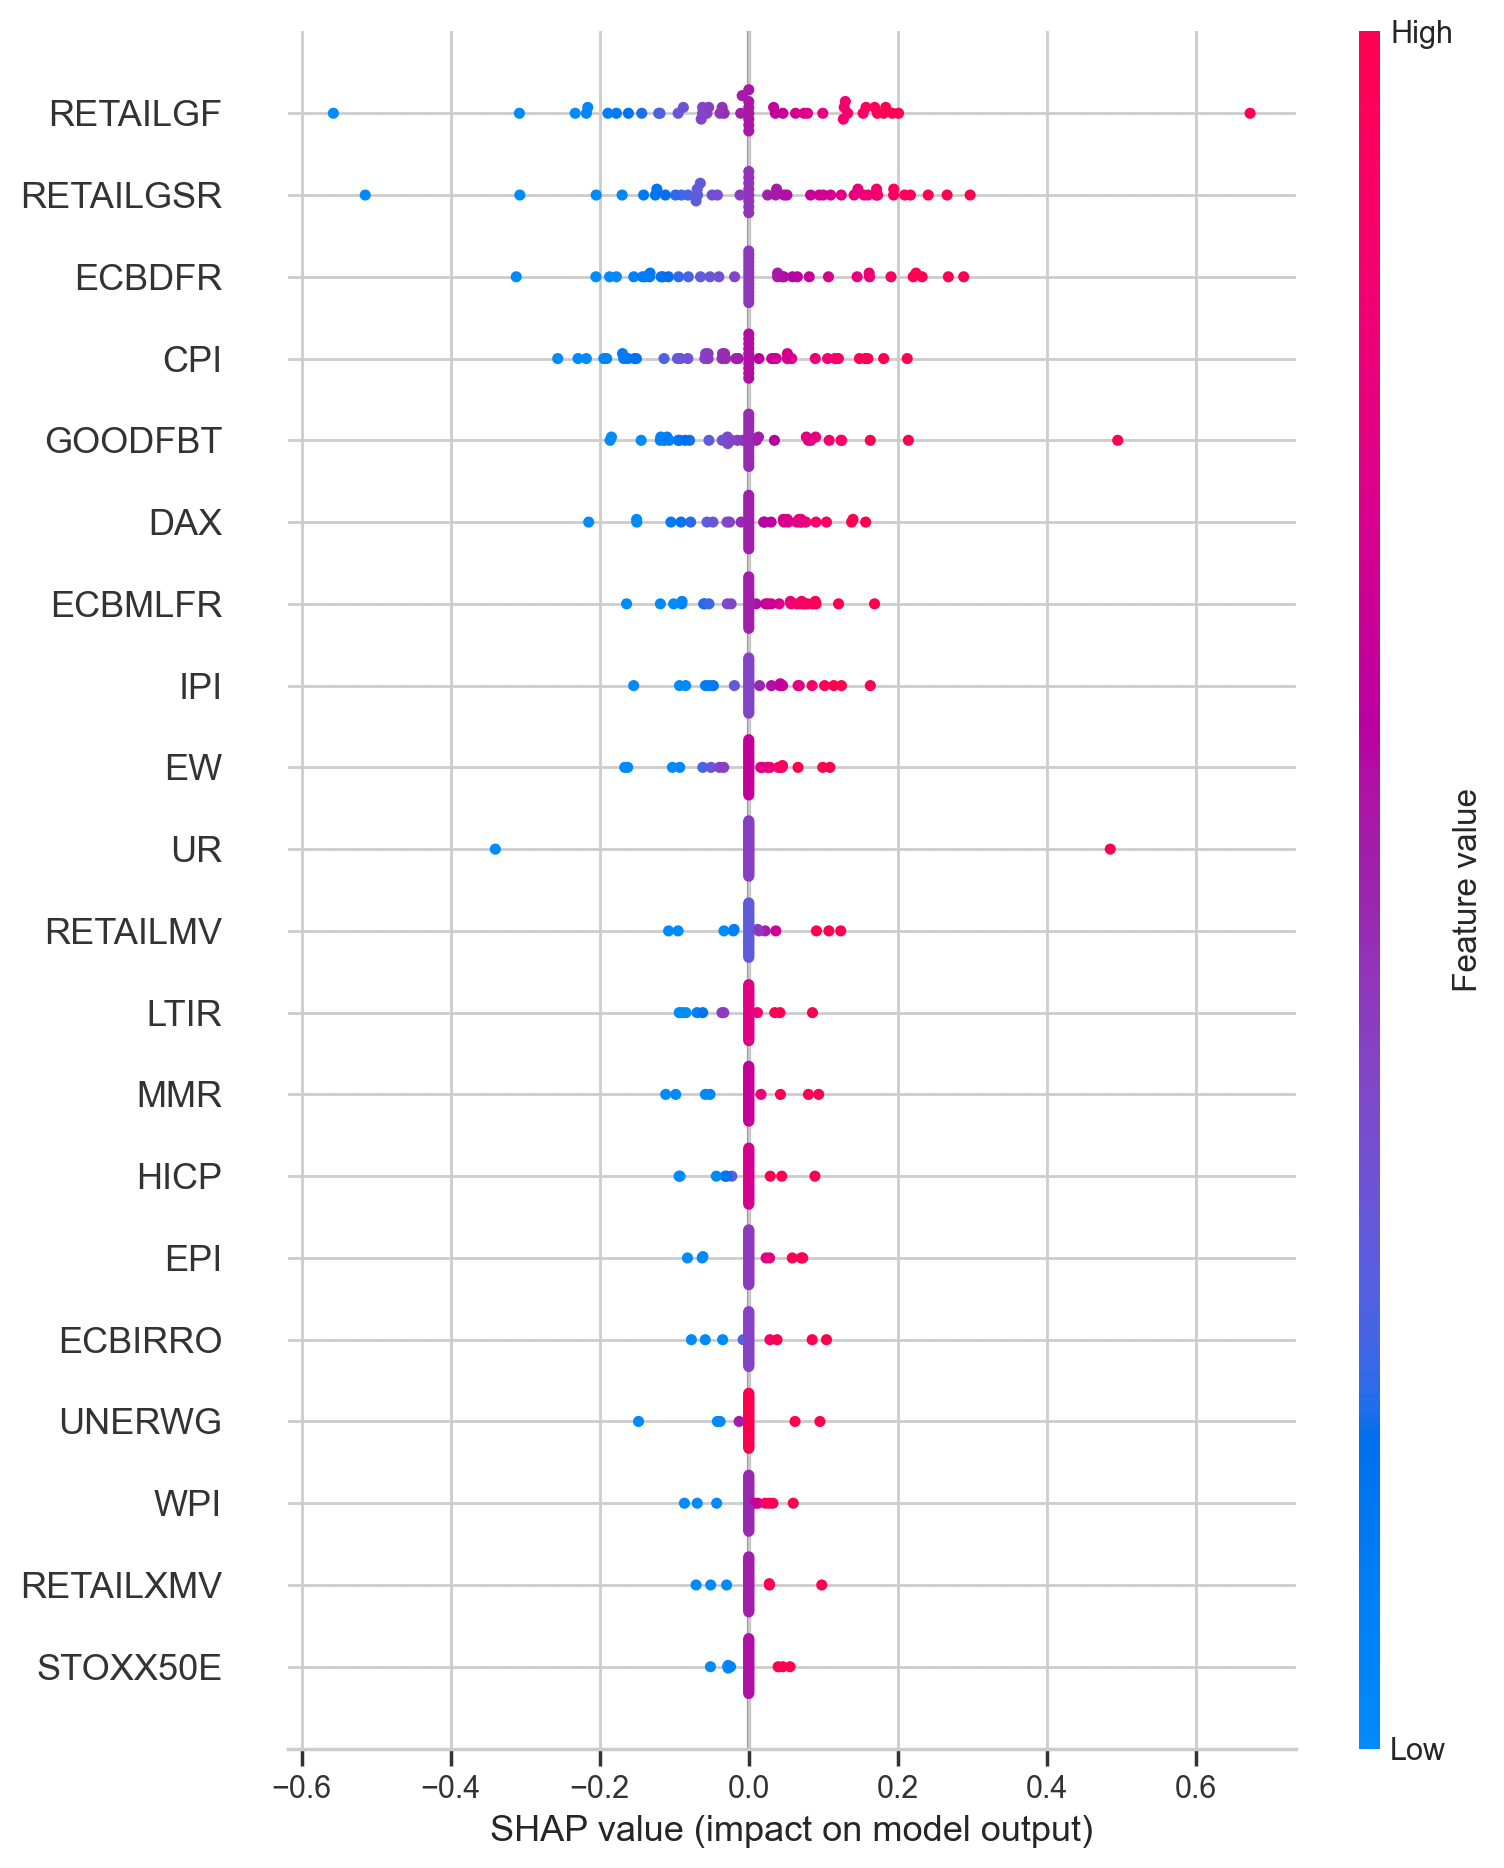

In [47]:
#------------------------------------------------------------------
# Aggregation Step: Aggregatng SHAP values importance along samples and across dimensions (lags)
#------------------------------------------------------------------

# 1. Create a DataFrame for the SHAP values with original (duplicated) feature names.
# This is the key to enabling the groupby operation.
repeated_feature_names = fnames_C1D_nfe * X_train_C1D_nfe.shape[1] # shape[1] is timesteps
shap_df = pd.DataFrame(shap_values_subset, columns=repeated_feature_names)


# 2. Aggregate the SHAP values by summing them up for each base feature.
# For each sample, this calculates: CPI_total_shap = CPI_t-1_shap + CPI_t-2_shap + ...
aggregated_shap_values = shap_df.groupby(level=0, axis=1).sum()

# 3. For the feature values (used for coloring), aggregate by taking the mean.
# For each sample, this calculates: CPI_mean_value = mean(CPI_t-1, CPI_t-2, ...)
# This gives a representative value for each feature to color the SHAP dots.
aggregated_features = X_explain_df_subset.groupby(level=0, axis=1).mean()

# Ensure the columns are in the same order for both DataFrames
aggregated_features = aggregated_features[aggregated_shap_values.columns]


#------------------------------------------------------------------
# Final Plotting Step
#------------------------------------------------------------------
print("Generating Aggregated SHAP summary plot...")
fig, ax = plt.subplots(figsize=(10, 8))

# Now, plot using the aggregated values.
# We pass the NumPy array of SHAP values and the DataFrame of feature values.
shap.summary_plot(
    aggregated_shap_values.values,
    aggregated_features,
    show=False
)

# Customize font sizes as before
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)

ax.set_title("Aggregated SHAP Feature Importance")
plt.show()

# ***Top Influential Variables***

In [50]:

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(aggregated_shap_values.values).mean(axis=0)

# Create a dictionary mapping feature names to their importance
shap_importance_dict = dict(zip(important_features, shap_importance))

# Sort features by importance (descending order)
sorted_features = sorted(shap_importance_dict, key=shap_importance_dict.get, reverse=True)



In [51]:
# Convert the dictionary to a list of (feature, importance) tuples
shap_importance_list = list(shap_importance_dict.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
shap_importance_list.sort(key=lambda item: item[1], reverse=True)

# Print the sorted feature names and their importance values
print("SHAP Feature Importance (Descending Order):")
for feature, importance in shap_importance_list:
    print(f"{feature}: {importance:.8f}") # You can adjust the formatting of the importance value

SHAP Feature Importance (Descending Order):
HICP: 0.12165501
ECBIRRO: 0.11582211
CPI: 0.09300100
RETAILGSR: 0.08465552
EW: 0.06550396
ECBDFR: 0.04549235
DAX: 0.04034392
RETAILMV: 0.02811737
IPI: 0.02486061
PPIIP: 0.01650525
UNERWG: 0.01363440
LTIR: 0.01283973
EPI: 0.01105242
UR: 0.00950559
ECBMLFR: 0.00916933
GOODFBT: 0.00867491
STOXX50E: 0.00798350
AGRPROD: 0.00722779
WPI: 0.00609684
RETAILXMV: 0.00599770
MMR: 0.00529370
RETAILGF: 0.00525010


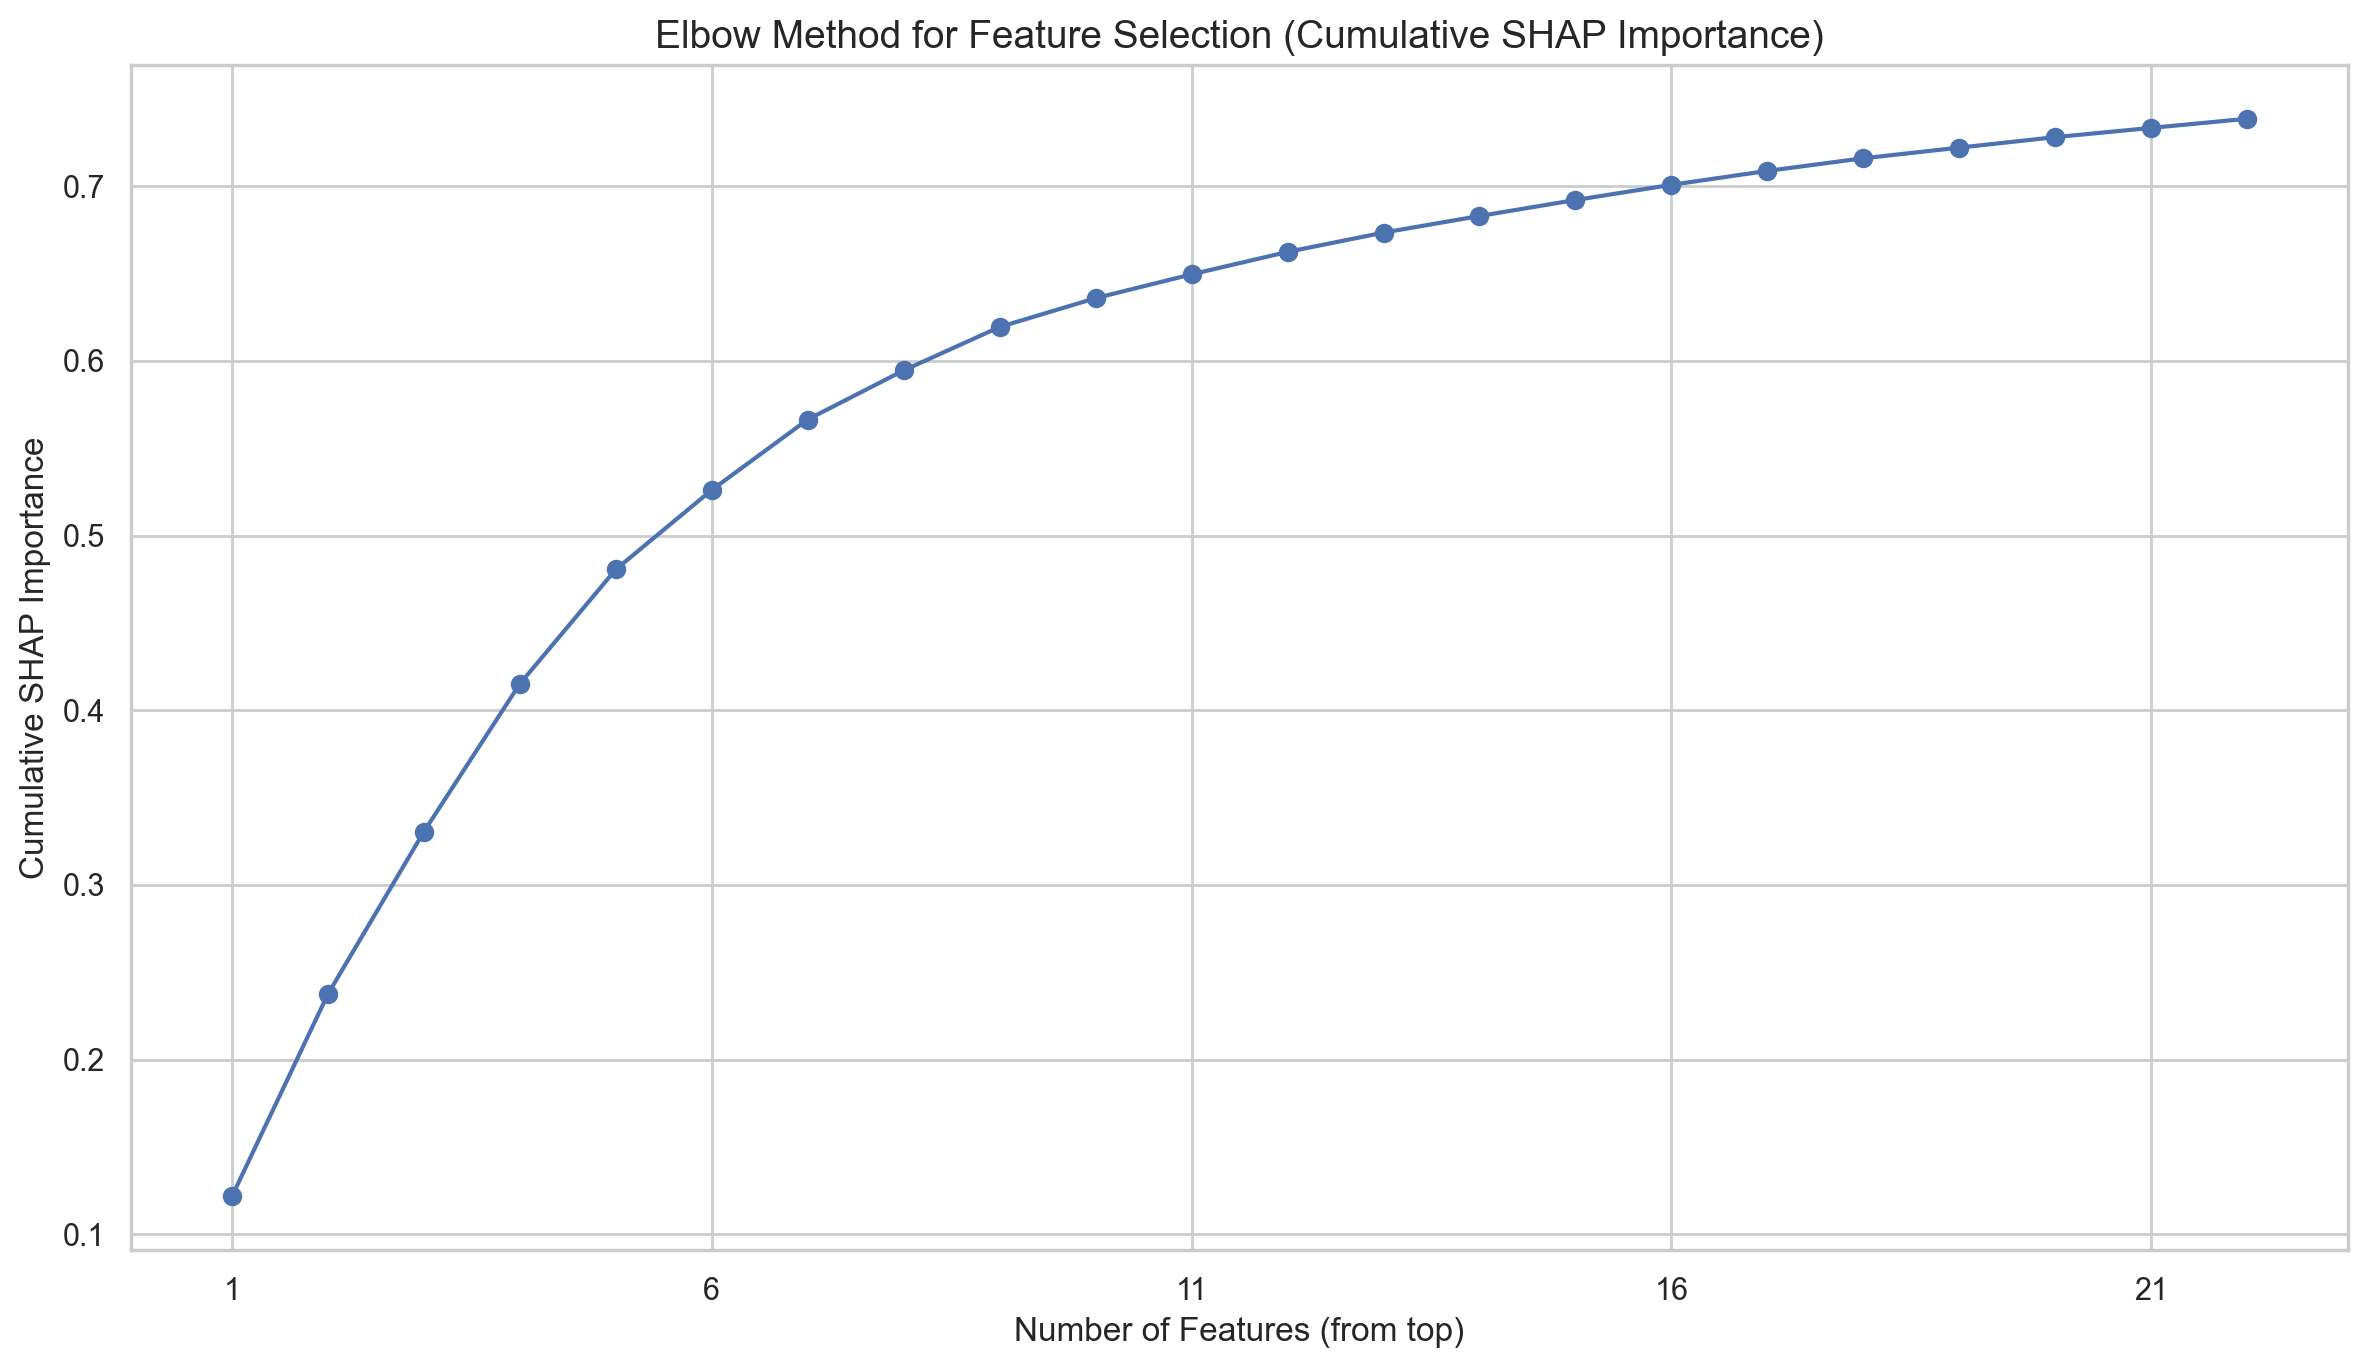

In [52]:
# Extract importance values
importance_values = [item[1] for item in shap_importance_list]

# Calculate cumulative importance
cumulative_importance = [sum(importance_values[:i+1]) for i in range(len(importance_values))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(importance_values) + 1), cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(importance_values) + 1, 5))

plt.tight_layout()
plt.show()

In [53]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
# one_third = len(sorted_features) // 3
top_influential_variables = np.array(sorted_features)[:19]

# Print the top influential variables
print("*** Top 31 influential variables based on elbow ***")
print(top_influential_variables)
print("*** All variables sorted in order of influence ***")
print(sorted_features)

*** Top 31 influential variables based on elbow ***
['HICP' 'ECBIRRO' 'CPI' 'RETAILGSR' 'EW' 'ECBDFR' 'DAX' 'RETAILMV' 'IPI'
 'PPIIP' 'UNERWG' 'LTIR' 'EPI' 'UR' 'ECBMLFR' 'GOODFBT' 'STOXX50E'
 'AGRPROD' 'WPI']
*** All variables sorted in order of influence ***
['HICP', 'ECBIRRO', 'CPI', 'RETAILGSR', 'EW', 'ECBDFR', 'DAX', 'RETAILMV', 'IPI', 'PPIIP', 'UNERWG', 'LTIR', 'EPI', 'UR', 'ECBMLFR', 'GOODFBT', 'STOXX50E', 'AGRPROD', 'WPI', 'RETAILXMV', 'MMR', 'RETAILGF']


#SHAP

In [54]:
shap_cols = np.append(top_influential_variables, "CPI_t+1")

In [56]:
print(shap_cols)

['HICP' 'ECBIRRO' 'CPI' 'RETAILGSR' 'EW' 'ECBDFR' 'DAX' 'RETAILMV' 'IPI'
 'PPIIP' 'UNERWG' 'LTIR' 'EPI' 'UR' 'ECBMLFR' 'GOODFBT' 'STOXX50E'
 'AGRPROD' 'WPI' 'CPI_t+1']


CNN+LSTM 1D + Time + Shap

Mean Absolute Error (MAE): 0.14774081
Root Mean Squared Error (RMSE): 0.24499871


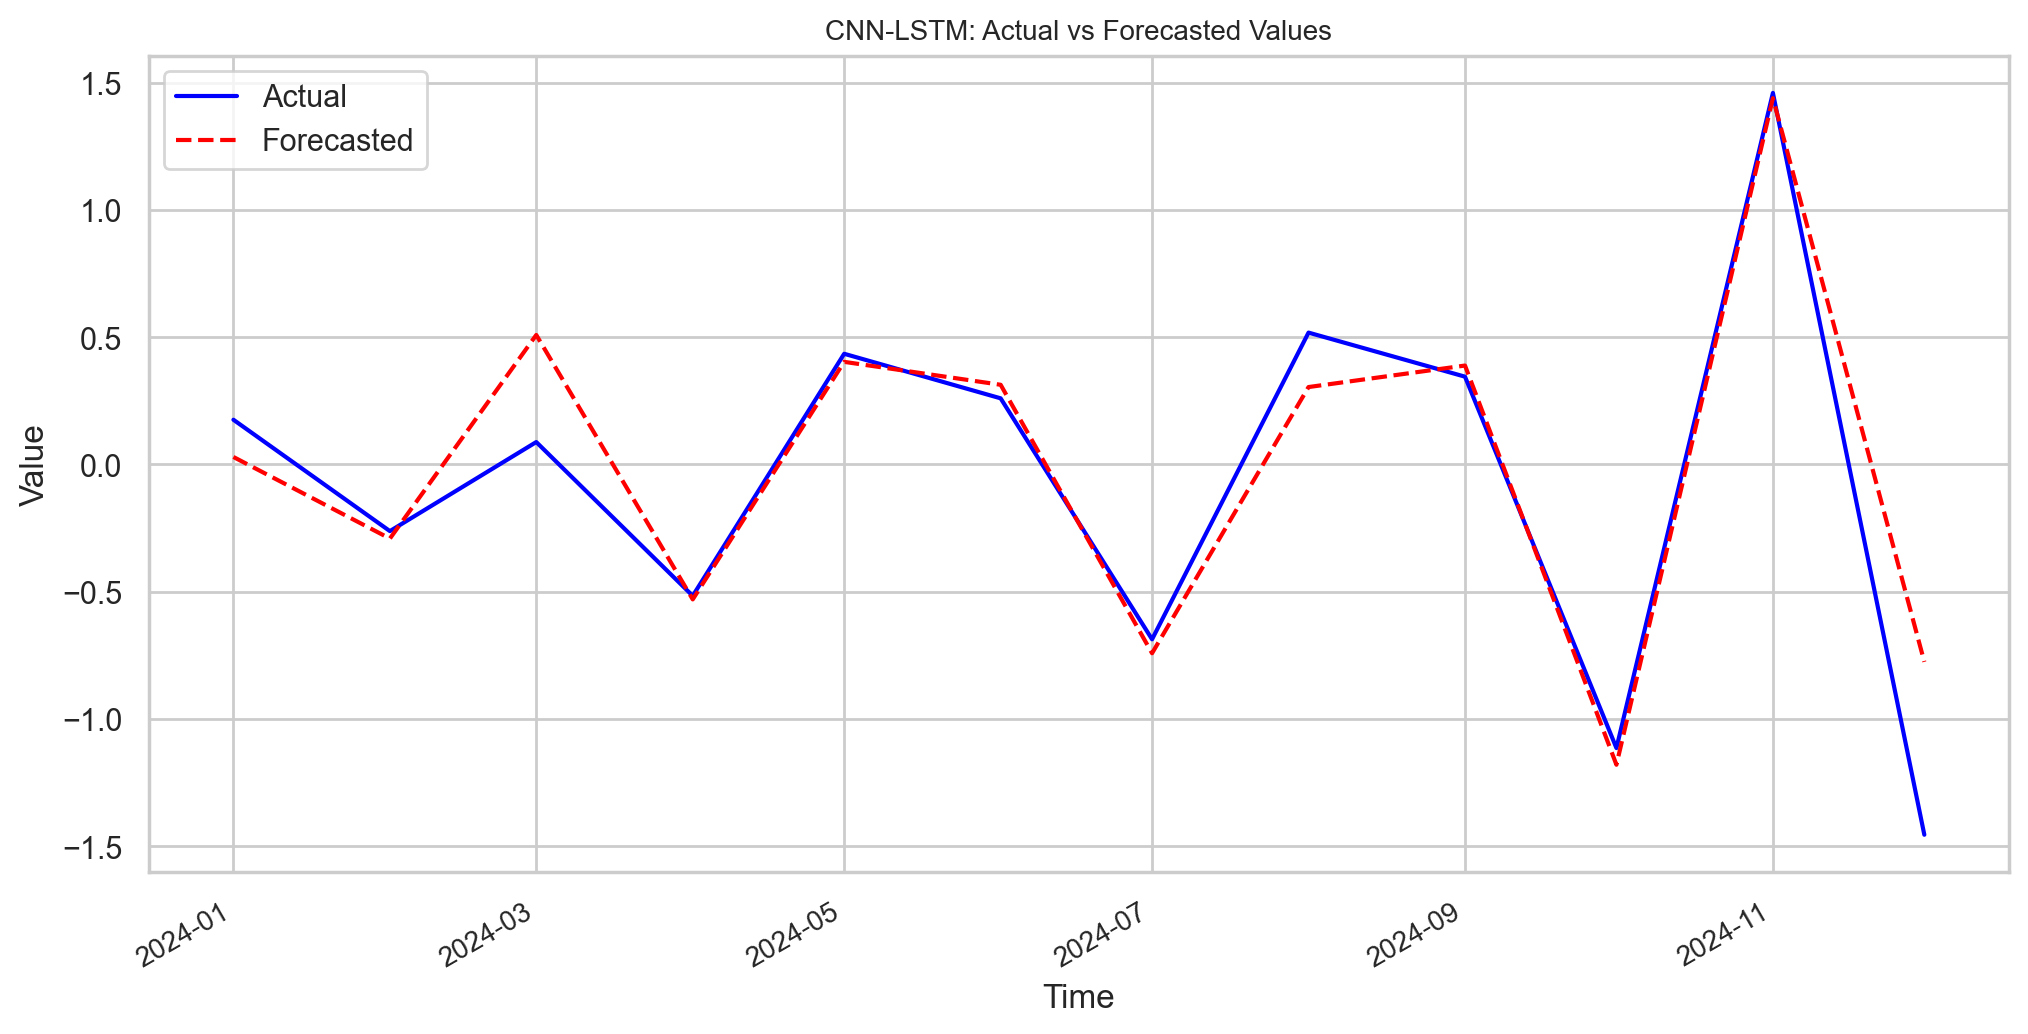

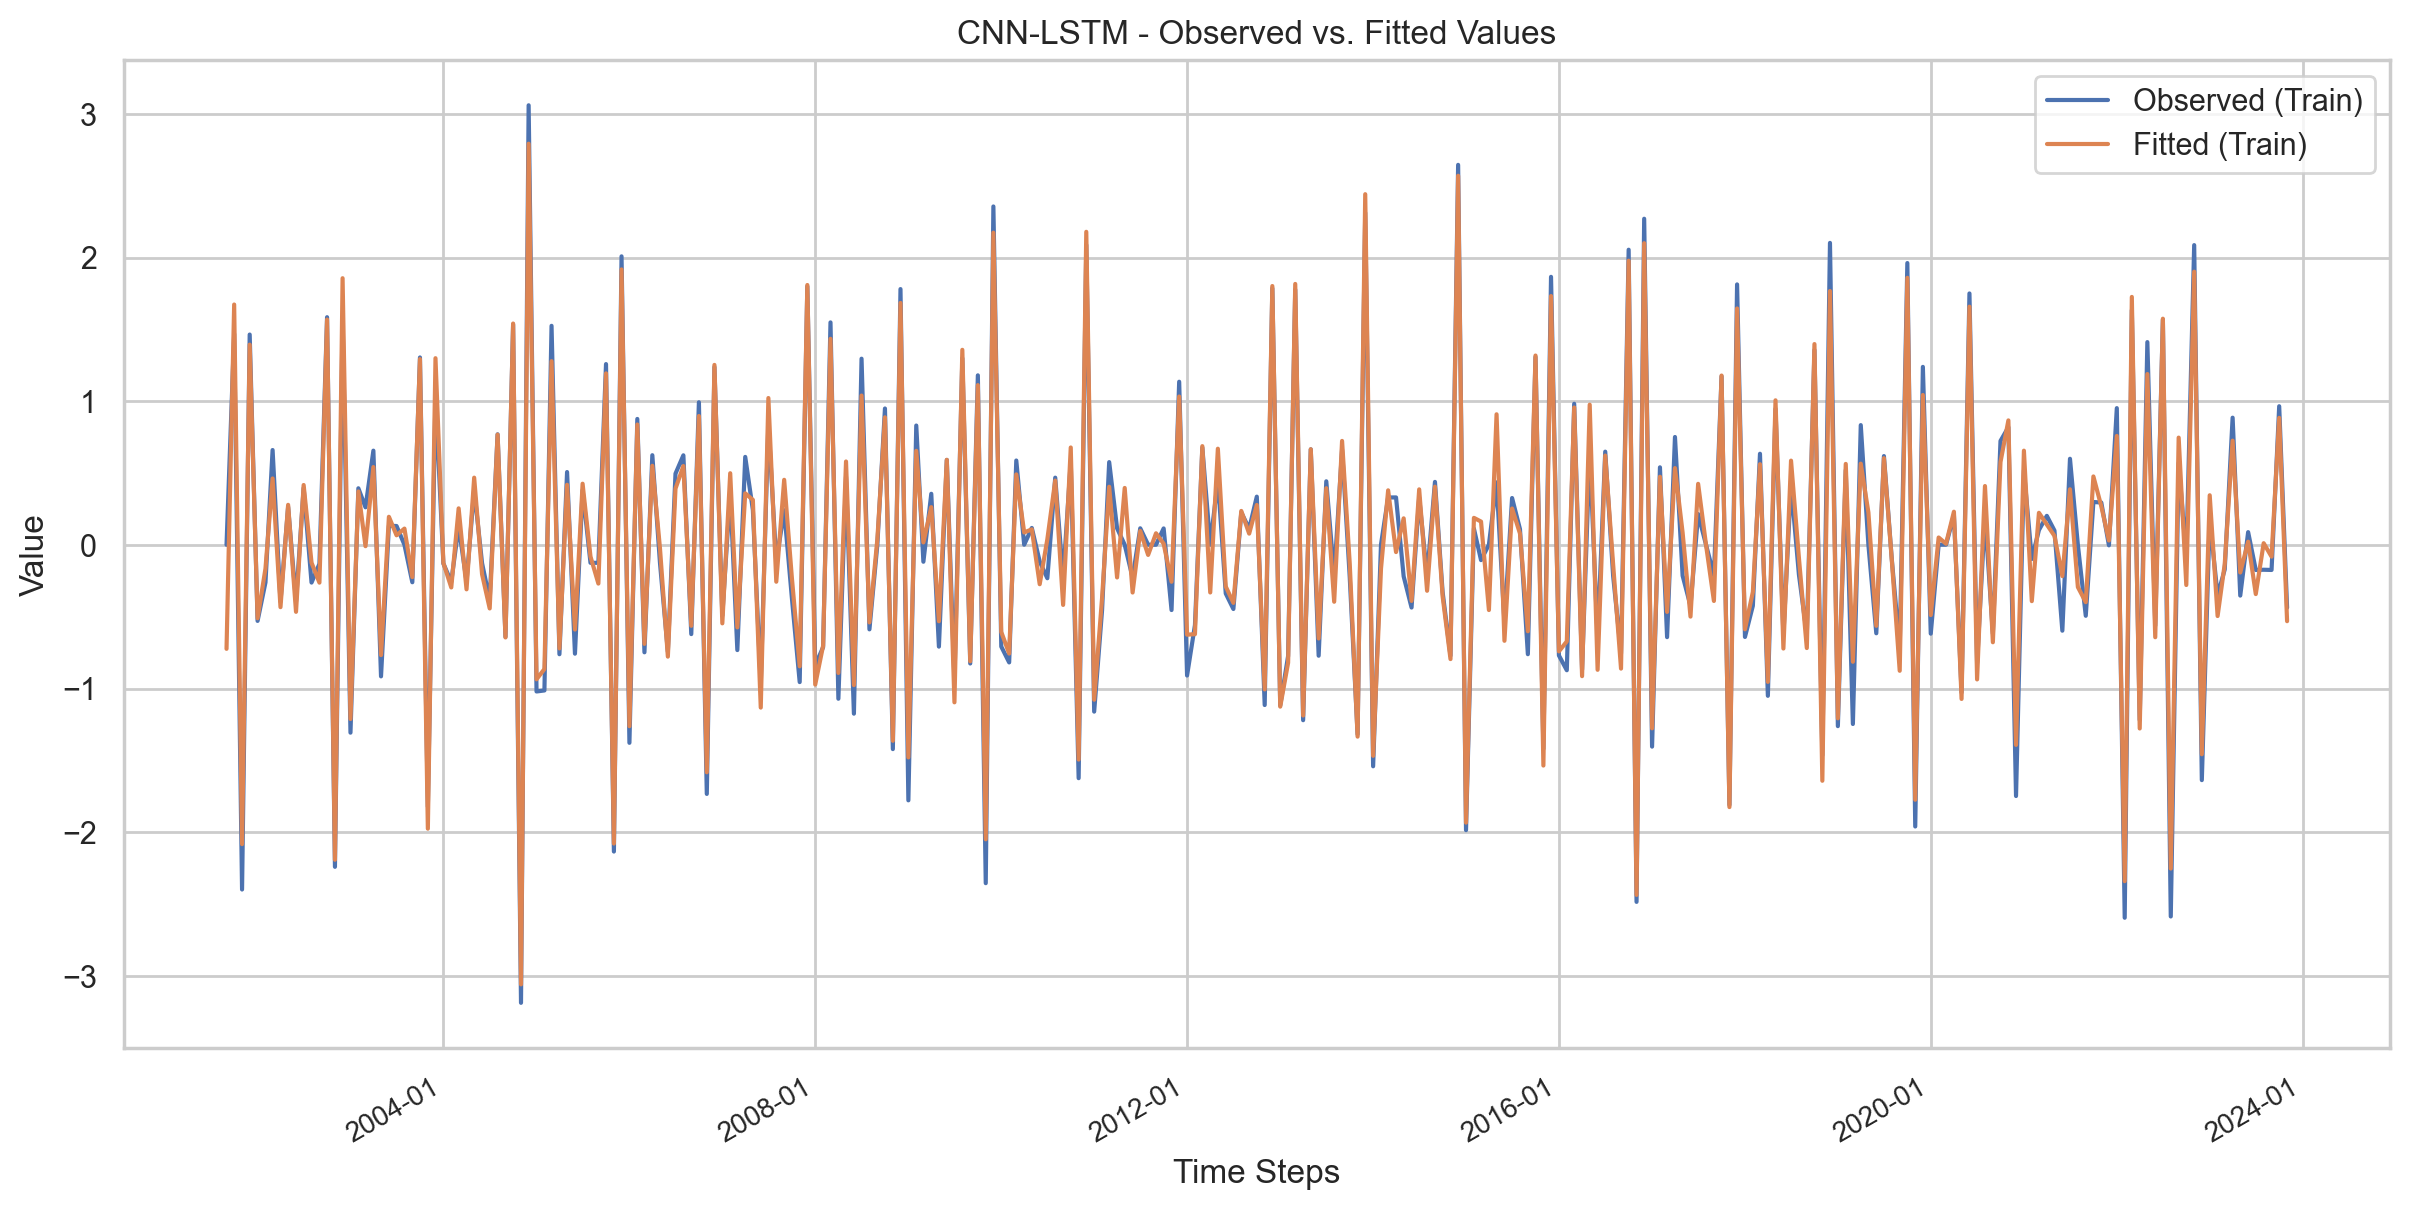

In [60]:
df_shap = df[shap_cols]
df_shap_time = add_time_features(df_shap)
model_CL1D_time_shap, X_train_CL1D_time_shap, X_test_CL1D_time_shap, mae_CL1D_time_shap, rmse_CL1D_time_shap, fnames_CL1D_time_shap = convlstm1D(df_shap_time, target, test_size, 30)


# ***Robust Test***

# ***ALL Models***

In [68]:


def train_and_evaluate_arima_model(data, auto_arima_model, forecast_horizon, title='ARIMA: Observed vs Fitted', target_column=target, test_size=test_size):
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]
    # Extract target series
    train_series = train_df[target_column]
    test_series = test_df[target_column]
    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()
    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=forecast_horizon)
    # Build output DataFrame
    forecast_index = test_series.index[:forecast_horizon]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:forecast_horizon]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))
    abs_error = np.abs(actual_series.values - forecast_df[target].values)
    return mae, rmse, abs_error

def train_eval_convlstm2D(data, target, test_size=test_size, lookback=12):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size, sequence_length=lookback)
    model = build_model_convlstm2D(input_shape)
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def train_eval_conv1D(data, target, test_size=test_size, lookback=12):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_conv1D(input_shape)
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def train_eval_convlstm1D(data, target, test_size=test_size, lookback=12):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_convlstm1D((X_train.shape[1], X_train.shape[2]))
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    abs_error = np.abs(y_test_actual.flatten() - predictions_actual.flatten())
    return mae, rmse, abs_error

def train_and_evaluate_var_model(data, lag_order, test_size):
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]
    # Fit the VAR model
    model = VAR(train_df)
    var_model = model.fit(lag_order)

    input_data = train_df.values[-lag_order:]
    forecast = var_model.forecast(y=input_data, steps=test_size)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # Extract actual and forecasted values for CPI
    actual_cpi = test_df[target]
    forecasted_cpi = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))
    var_abs_error = np.abs(actual_cpi.values - forecasted_cpi.values)
    return mae, rmse, var_abs_error

def train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size, target_column=target):

    # Extract target series for SARIMA
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series for SARIMA
    train_cpi_arima = train_df[target_column]
    test_cpi_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_cpi_arima.index = pd.to_datetime(train_cpi_arima.index)

    history = train_cpi_arima.tolist()
    sarima_model = SARIMAX(history,
                           order=auto_arima_model_sarima.order,
                           seasonal_order=auto_arima_model_sarima.seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)
    forecast_df = pd.DataFrame(forecast, index=test_cpi_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpi_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpi_arima, forecast_df[target_column]))
    forecasted_cpi = forecast_df[target_column]
    abs_error = np.abs(test_cpi_arima.values - forecasted_cpi.values)
    return mae_sarima, rmse_sarima, abs_error


# 100 Subsample run

In [69]:
series_name = "dfCPI_full_dataset_subsample"

# Column Definitions

In [70]:
main_nfe_cols = main_vars_n_target_cols
main_vae_cols = vae_cpi_cols
test_size = 12


Error Arrays

In [85]:
var_maes = []
var_rmses = []
var_all_forecasts = []

arima_maes = []
arima_rmses = []
arima_all_forecasts = []

sarima_maes = []
sarima_rmses = []
sarima_all_forecasts = []

c1D_base_maes = []
c1D_base_rmses = []
c1D_base_all_predictions = []

c1D_nfe_maes = []
c1D_nfe_rmses = []
c1D_nfe_all_predictions = []

c1D_time_maes = []
c1D_time_rmses = []
c1D_time_all_predictions = []

cl1D_nfe_maes = []
cl1D_nfe_rmses = []
cl1D_nfe_all_predictions = []

cl1D_time_maes = []
cl1D_time_rmses = []
cl1D_time_all_predictions = []

cl1D_vae_maes = []
cl1D_vae_rmses = []
cl1D_vae_all_predictions = []

cl1D_vae_time_maes = []
cl1D_vae_time_rmses = []
cl1D_vae_time_all_predictions = []

cl2D_nfe_maes = []
cl2D_nfe_rmses = []
cl2D_nfe_all_predictions = []

cl1D_time_shap_maes = []
cl1D_time_shap_rmses = []
cl1D_time_shap_all_predictions = []




In [86]:
# Pre-load all data
all_data_dict = {}
print("Loading all CSVs into memory...")
for i in tqdm(range(100), desc="Loading data"):
    filename = f"{series_name}_{i + 1}.csv"
    file_path = os.path.join(all_Series_CPI_target_dir, filename)
    df = pd.read_csv(file_path, index_col = 0)
    df.index.name = 'DATE' # Set the name of the index
    all_data_dict[i + 1] = df
print("All CSVs loaded.\n")

Loading all CSVs into memory...


Loading data: 100%|██████████| 100/100 [00:00<00:00, 670.12it/s]

All CSVs loaded.



In [88]:

for i in tqdm(range(100), desc="Processing models"):
    data = all_data_dict[i + 1]
    sub_df = data[main_nfe_cols]
    sub_df_time = add_time_features(sub_df)
    sub_df_vae = data[main_vae_cols]
    sub_df_vae_time = add_time_features(sub_df_vae)
    sub_df_shap = data[shap_cols]
    sub_df_time_shap = add_time_features(sub_df_shap)
    var_df = data[granger_sig_exp_vars]

    # 0 CONV1D NFE BASE NO LOOKBACK
    c1D_base_mae, c1D_base_rmse, c1D_base_all_prediction = train_eval_conv1D(sub_df, target, test_size=test_size, lookback=1)
    c1D_base_maes.append(c1D_base_mae)
    c1D_base_rmses.append(c1D_base_rmse)
    c1D_base_all_predictions.append(c1D_base_all_prediction)

    # 1 CONV1D NFE
    c1D_nfe_mae, c1D_nfe_rmse, c1D_nfe_all_prediction = train_eval_conv1D(sub_df, target, test_size=test_size, lookback=12)
    c1D_nfe_maes.append(c1D_nfe_mae)
    c1D_nfe_rmses.append(c1D_nfe_rmse)
    c1D_nfe_all_predictions.append(c1D_nfe_all_prediction)

    # 2 CONV1D TIME + 30 Step
    c1D_time_mae, c1D_time_rmse, c1D_time_all_prediction = train_eval_conv1D(sub_df_time, target, test_size=test_size, lookback=30)
    c1D_time_maes.append(c1D_time_mae)
    c1D_time_rmses.append(c1D_time_rmse)
    c1D_time_all_predictions.append(c1D_time_all_prediction)

    # 3 CONVLSTM1D NFE
    cl1D_nfe_mae, cl1D_nfe_rmse, cl1D_nfe_all_prediction = train_eval_convlstm1D(sub_df, target, test_size=test_size, lookback=12)
    cl1D_nfe_maes.append(cl1D_nfe_mae)
    cl1D_nfe_rmses.append(cl1D_nfe_rmse)
    cl1D_nfe_all_predictions.append(cl1D_nfe_all_prediction)

    # 4 CONVLSTM1D + TIME 30 Step
    cl1D_time_mae, cl1D_time_rmse, cl1D_time_all_prediction = train_eval_convlstm1D(sub_df_time, target, test_size=test_size, lookback=30)
    cl1D_time_maes.append(cl1D_time_mae)
    cl1D_time_rmses.append(cl1D_time_rmse)
    cl1D_time_all_predictions.append(cl1D_time_all_prediction)

    # 5 CONVLSTM1D + SHAP + TIME 30 Step
    cl1D_time_shap_mae, cl1D_time_shap_rmse, cl1D_time_shap_all_prediction = train_eval_convlstm1D(sub_df_time_shap, target, test_size=test_size, lookback=30)
    cl1D_time_shap_maes.append(cl1D_time_shap_mae)
    cl1D_time_shap_rmses.append(cl1D_time_shap_rmse)
    cl1D_time_shap_all_predictions.append(cl1D_time_shap_all_prediction)

    # 6 CONVLSTM1D VAE
    cl1D_vae_mae, cl1D_vae_rmse, cl1D_vae_all_prediction = train_eval_convlstm1D(sub_df_vae, target, test_size=test_size, lookback=12)
    cl1D_vae_maes.append(cl1D_vae_mae)
    cl1D_vae_rmses.append(cl1D_vae_rmse)
    cl1D_vae_all_predictions.append(cl1D_vae_all_prediction)

    # 7 CONVLSTM1D VAE + TIME 30 Step
    cl1D_vae_mae_time, cl1D_vae_time_rmse, cl1D_vae_time_all_prediction = train_eval_convlstm1D(sub_df_vae_time, target, test_size=test_size, lookback=30)
    cl1D_vae_time_maes.append(cl1D_vae_mae_time)
    cl1D_vae_time_rmses.append(cl1D_vae_time_rmse)
    cl1D_vae_time_all_predictions.append(cl1D_vae_time_all_prediction)

    # 8 CONVLSTM2D NFE
    cl2D_nfe_mae, cl2D_nfe_rmse, cl2D_nfe_all_prediction = train_eval_convlstm2D(sub_df, target, test_size=test_size, lookback=12)
    cl2D_nfe_maes.append(cl2D_nfe_mae)
    cl2D_nfe_rmses.append(cl2D_nfe_rmse)
    cl2D_nfe_all_predictions.append(cl2D_nfe_all_prediction)

    # 9 VAR
    var_mae, var_rmse, var_forecasted_cpi = train_and_evaluate_var_model(var_df, var_lag_order, test_size=test_size)
    var_maes.append(var_mae)
    var_rmses.append(var_rmse)
    var_all_forecasts.append(var_forecasted_cpi)

    # 10 ARIMA
    arima_mae, arima_rmse, arima_forecasted = train_and_evaluate_arima_model(sub_df, auto_arima_model_arima, test_size=test_size, forecast_horizon=12)
    arima_maes.append(arima_mae)
    arima_rmses.append(arima_rmse)
    arima_all_forecasts.append(arima_forecasted)

    # 11 SARIMA
    sarima_mae, sarima_rmse, sarima_forecasted_cpi = train_and_evaluate_sarima_model(sub_df, auto_arima_model_sarima, test_size, target_column=target)
    sarima_maes.append(sarima_mae)
    sarima_rmses.append(sarima_rmse)
    sarima_all_forecasts.append(sarima_forecasted_cpi)


Processing models: 100%|██████████| 100/100 [11:33:56<00:00, 416.36s/it] 


# Save Results

In [89]:

print("VAR")
print(np.mean(var_all_forecasts[0]))
print("SARIMA")
print(np.mean(sarima_all_forecasts[0]))
print("ARIMA")
print(np.mean(arima_all_forecasts[0]))
print("C1D_BASE")
print(np.mean(c1D_base_all_predictions[0]))
print("C1D_NFE")
print(np.mean(c1D_nfe_all_predictions[0]))
print("C1D Time")
print(np.mean(c1D_time_all_predictions[0]))
print("CL1D NFE")
print(np.mean(cl1D_nfe_all_predictions[0]))
print("CL1D TIME")
print(np.mean(cl1D_time_all_predictions[0]))
print("CL1D VAE")
print(np.mean(cl1D_vae_all_predictions[0]))
print("CL1D VAE TIME")
print(np.mean(cl1D_vae_time_all_predictions[0]))
print("CL2D NFE")
print(np.mean(cl2D_nfe_all_predictions[0]))
print("CL1D-TIME-SHAP")
print(np.mean(cl1D_time_shap_all_predictions[0]))



VAR
0.46022416921834863
SARIMA
0.5173786714481937
ARIMA
0.8740315412891402
C1D_BASE
0.7832670634509823
C1D_NFE
0.22204007866382172
C1D Time
0.22165206579061325
CL1D NFE
0.2312854908621208
CL1D TIME
0.11309778848847359
CL1D VAE
0.4099651704004404
CL1D VAE TIME
0.21840371095909702
CL2D NFE
1.376299302835611
CL1D-TIME-SHAP
0.16174217066622995


In [90]:
# Directory to save output
output_dir = "cpi_multi_step_model_results"
os.makedirs(output_dir, exist_ok=True)

# Model data
model_results = {
    "VAR": (var_maes, var_rmses, var_all_forecasts),
    "ARIMA": (arima_maes, arima_rmses, arima_all_forecasts),
    "SARIMA": (sarima_maes, sarima_rmses, sarima_all_forecasts),
    "C1D-BASE": (c1D_base_maes, c1D_base_rmses, c1D_base_all_predictions),
    "C1D-NFE": (c1D_nfe_maes, c1D_nfe_rmses, c1D_nfe_all_predictions),
    "C1D-TIME": (c1D_time_maes, c1D_time_rmses, c1D_time_all_predictions),
    "CL1D-NFE": (cl1D_nfe_maes, cl1D_nfe_rmses, cl1D_nfe_all_predictions),
    "CL1D-TIME": (cl1D_time_maes, cl1D_time_rmses, cl1D_time_all_predictions),
    "CL1D-TIME-SHAP": (cl1D_time_shap_maes, cl1D_time_shap_rmses, cl1D_time_shap_all_predictions),
    "CL1D-VAE": (cl1D_vae_maes, cl1D_vae_rmses, cl1D_vae_all_predictions),
    "CL1D-VAE-TIME": (cl1D_vae_time_maes, cl1D_vae_time_rmses, cl1D_vae_time_all_predictions),
    "CL2D-NFE": (cl2D_nfe_maes, cl2D_nfe_rmses, cl2D_nfe_all_predictions),
}

# Save MAEs
mae_df = pd.DataFrame({model: maes for model, (maes, _, _) in model_results.items()})
mae_df.index.name = "Iteration"
mae_df.to_csv(os.path.join(output_dir, "all_mae.csv"))

# Save RMSEs
rmse_df = pd.DataFrame({model: rmses for model, (_, rmses, _) in model_results.items()})
rmse_df.index.name = "Iteration"
rmse_df.to_csv(os.path.join(output_dir, "all_rmse.csv"))

forecast_wide_1 = pd.DataFrame()
for model, (_, _, forecasts) in model_results.items():
    forecasts_array = np.squeeze(np.array(forecasts))
    # Limit to first 100 iterations
    forecasts_array = forecasts_array[:100, :]
    col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
    forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
    forecast_wide_1 = pd.concat([forecast_wide_1, forecast_df], axis=1)
# Limit the DataFrame index to first 100 iterations
forecast_wide_1 = forecast_wide_1.iloc[:100, :]
forecast_wide_1.index.name = "Iteration"
forecast_wide_1.to_csv(os.path.join(output_dir, "all_forecasts.csv"))


# THE END